In [3]:
import re # for punctuation strip
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/irmakergin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# read analysis/organized_data_no_typo.csv
df = pd.read_csv('/Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/data/data_no_typo.csv')

NameError: name 'pd' is not defined

1. Word by word comparison using GloVe. Take the max cosine similarity value for each word, sum up all word's scores. This way, we can accout for the number of word written AND their similarity scores. We will call this method *GLoVe- Written Summary*

In [ ]:
filepath = "/content/drive/MyDrive/semantic_similarity_calculation/glove.6B.300d.txt"

word_list = {}
vectors = []
with open(filepath, encoding="utf8") as f:
    i = 0
    for line in f:
        word, *vector = line.split()
        vectors.append(np.array(
                    vector, dtype=np.float32).reshape((1, -1)))
        word_list[word] = i
        i+=1

embedding_matrix = np.concatenate(vectors, axis=0)

In [ ]:
def compute_cosine_similarity(v1, v2):
    return v1@v2/(np.linalg.norm(v1)*np.linalg.norm(v2))

In [ ]:
# Let's see one example

# Create an empty list for similarity matrices
similarity_matrices = []

# Create counters
total_matrices = 0
non_empty_matrices = 0

for index, row in df.iterrows():
    summary = row['textbox.text_corrected_manual']
    stimulus = row['segment_text']
    print(summary, "\n\n", stimulus)
    break

NameError: name 'df' is not defined

In [ ]:
# Create an empty list for similarity matrices
similarity_matrices = []

# Create counters
total_matrices = 0
non_empty_matrices = 0

# List to keep track of indices with empty similarity matrices
empty_matrix_indices = []

for index, row in df.iterrows():
    summary = row['textbox.text_corrected_manual']
    stimulus = row['segment_text']

    if pd.notna(summary):
        stimulus_words = [re.sub(r'[^\w\s]', '', w).lower() for w in stimulus.split()]
        summary_words = [re.sub(r'[^\w\s]', '', w).lower() for w in summary.split()]

        # Initialize the similarity matrix
        similarity_matrix = np.zeros([len(stimulus_words), len(summary_words)])

        for wi, stim_word in enumerate(stimulus_words):
            if stim_word in word_list:
                v_wi = embedding_matrix[word_list[stim_word]]
                for wj, summary_word in enumerate(summary_words):
                    if summary_word in word_list:
                        v_wj = embedding_matrix[word_list[summary_word]]
                        similarity_matrix[wi, wj] = compute_cosine_similarity(v_wi, v_wj)

        total_matrices += 1
        if np.any(similarity_matrix != 0):
            non_empty_matrices += 1
        else:
            empty_matrix_indices.append(index)

        similarity_matrices.append(similarity_matrix)

# Sanity check
print(f"Total similarity matrices calculated: {total_matrices}")
print(f"Non-empty similarity matrices: {non_empty_matrices}")

# Print the rows that have an empty similarity matrix
if empty_matrix_indices:
    print("Rows with empty similarity matrices:")
    print(df.loc[empty_matrix_indices])
else:
    print("No empty similarity matrices found.")

Total similarity matrices calculated: 1484
Non-empty similarity matrices: 1484
No empty similarity matrices found.


Stimulus Text: If you don't have any questions about the material then state your name and agency and go ahead whenever you're ready thanks so much I try to swallow but my throat is too dry This is the kind of room that's hard to do well in If they're in the mood to talk I can crack a few jokes make a small connection give myself a moment to settle down but these girls are all business I look down at the paper I'm not going to panic or ask for more time or tell them I didn't really have a chance to go over it yet I'm going to remain calm as if I'm a professional


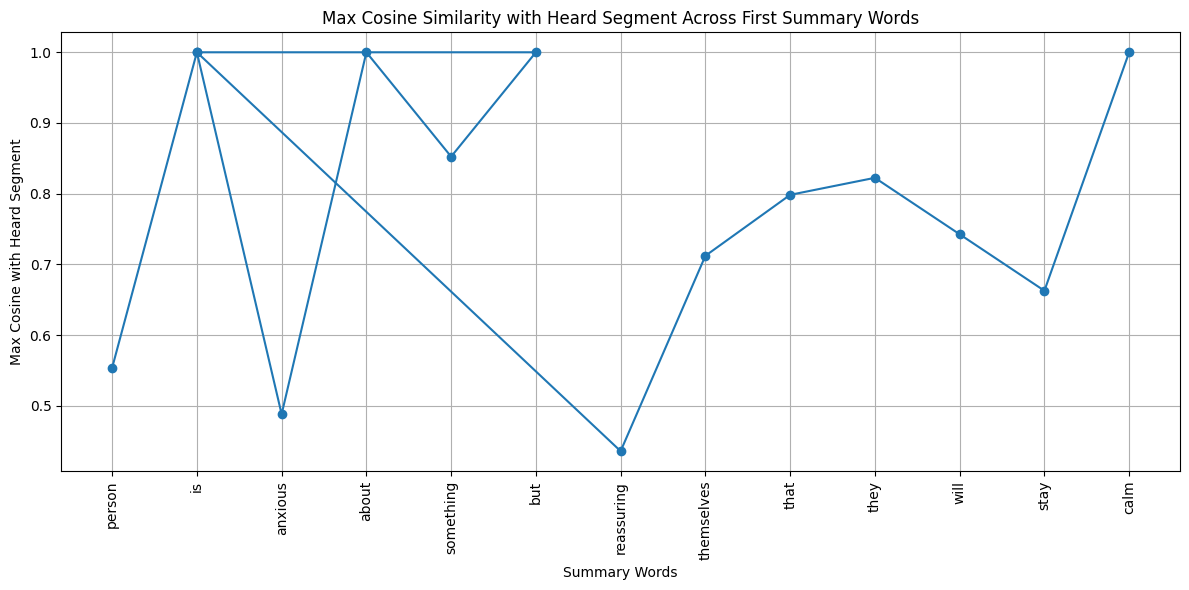

[0.55356956 1.         0.4880372  1.00000012 0.85237396 1.
 1.         0.43573183 0.71207315 0.79831308 0.82241863 0.74254537
 0.66264647 0.99999994]


In [ ]:
# Assuming we want to plot for the first summary-> x2 segment
if len(similarity_matrices) > 0:
    first_similarity_matrix = similarity_matrices[0]
    first_summary_words = [re.sub(r'[^\w\s]', '', w).lower() for w in df.iloc[0]['textbox.text_corrected_manual'].split()]

 # Print the stimulus text for the first summary
    first_stimulus_text = df.iloc[0]['segment_text']
    print("Stimulus Text:", first_stimulus_text)

    plt.figure(figsize=(12, 6))
    plt.plot(first_summary_words, first_similarity_matrix.max(0), marker='o')
    plt.xticks(rotation=90)
    plt.xlabel("Summary Words")
    plt.ylabel("Max Cosine with Heard Segment")
    plt.title("Max Cosine Similarity with Heard Segment Across First Summary Words")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(first_similarity_matrix.max(0))

In [ ]:
# take the max value for each word and calculate total similarity score for each summary

# create a list to store the sum of maximum similarity scores for each summary
sum_max_similarities = []

# loop through each similarity matrix to calculate the sum of maximum similarity scores
for similarity_matrix in similarity_matrices:
    # take cosine similarty not disctance
    #similarity_matrix = 1 - similarity_matrix

    # Calculate the max similarity value for each word in the summary (across all stimulus words)
    max_values = np.max(similarity_matrix, axis=0)

    # sum these maximum similarity values
    sum_max_similarity = np.sum(max_values) if max_values.size > 0 else 0

    # append the sum to the list
    sum_max_similarities.append(sum_max_similarity)

# Sanity check- count the number of successfully calculated sum_max_similarity values
successful_calculations = len(sum_max_similarities) - np.count_nonzero(np.isnan(sum_max_similarities))
print(f"Total number of sum_max_similarity values calculated: {successful_calculations}")
print(len(sum_max_similarities))



Total number of sum_max_similarity values calculated: 1484
1484


In [ ]:
# add it as a new column

# Create a new column for sum_max_similarity, initializing with NaN
df['glove_sum_max_similarity'] = np.nan

# We'll now populate this column only for rows where 'textbox.text_corrected_manual' is not NaN
# And match the order of calculations
non_nan_indices = df.index[df['textbox.text_corrected_manual'].notna()].tolist()
for calculated_index, df_index in enumerate(non_nan_indices):
    df.at[df_index, 'glove_sum_max_similarity'] = sum_max_similarities[calculated_index]


In [ ]:
# rescale the summary scores to be between 0-1. Take the max score in the data set -> =1

max_score = df['glove_sum_max_similarity'].max()
print(max_score)
df['glove_sum_max_similarity_rescaled'] = df['glove_sum_max_similarity'] / max_score

print(df)

43.995857894420624
     participant  index                      wav_file  \
0            p_1      1   Someday_23_condition-2x.wav   
1            p_1      2   Someday_65_condition-2x.wav   
2            p_1      3  Someday_123_condition-5x.wav   
3            p_1      4   Someday_82_condition-5x.wav   
4            p_1      5   Someday_43_condition-4x.wav   
...          ...    ...                           ...   
2745         p_9    121   Someday_20_condition-4x.wav   
2746         p_9    122    Someday_1_condition-2x.wav   
2747         p_9    123       Someday_2_condition.wav   
2748         p_9    124   Someday_41_condition-4x.wav   
2749         p_9    125   Someday_64_condition-2x.wav   

                                               old_name   duration  \
0     Someday__Someday__Maybe__Unabridged___File_014...  14.649969   
1     Someday__Someday__Maybe__Unabridged___File_032...  14.044969   
2     Someday__Someday__Maybe__Unabridged___File_054...   6.032000   
3     Someday__S

2. Word by word comparison using GloVe. This time, rather than summing the maximum scores of summary words, We will calculate cosine similarity of the segment text as compared with the summaries. Then, take the max value for each word and their  average. W ewill call this method *GloVe- Heard Segment*

In [ ]:
# Create an empty list for similarity matrices
similarity_matrices = []

# Create counters
total_matrices = 0
non_empty_matrices = 0

for index, row in df.iterrows():
    summary = row['textbox.text_corrected_manual']
    stimulus = row['segment_text']

    if pd.notna(summary):
        stimulus_words = [re.sub(r'[^\w\s]', '', w).lower() for w in stimulus.split()]
        summary_words = [re.sub(r'[^\w\s]', '', w).lower() for w in summary.split()]

        # Initialize the similarity matrix
        similarity_matrix = np.zeros([len(summary_words), len(stimulus_words)])  # Notice the swapped dimensions

        for wi, stim_word in enumerate(stimulus_words):
            if stim_word in word_list:
                v_wi = embedding_matrix[word_list[stim_word]]
                for wj, summary_word in enumerate(summary_words):
                    if summary_word in word_list:
                        v_wj = embedding_matrix[word_list[summary_word]]
                        # Compute cosine similarity by subtracting the cosine distance from 1
                        similarity_matrix[wj, wi] = compute_cosine_similarity(v_wi, v_wj)  # Adjusted to compute similarity
        total_matrices += 1
        if np.any(similarity_matrix != 0):
            non_empty_matrices += 1
        similarity_matrices.append(similarity_matrix)

# Sanity check
print(f"Total similarity matrices calculated: {total_matrices}")
print(f"Non-empty similarity matrices: {non_empty_matrices}")

# Calculate the average of the max cosine similarity for each word in the segment_text for each trial
trial_scores = []

for similarity_matrix in similarity_matrices:
    # Calculate the max similarity value for each word in the stimulus (across all summary words)
    max_values = np.max(similarity_matrix, axis=0)  # Calculate max across summary words for each stimulus word

    # Calculate the average of these maximum values
    average_max_similarity = np.mean(max_values) if max_values.size > 0 else 0

    # Append the average to the list
    trial_scores.append(average_max_similarity)

# Sanity check
print(f"Total number of trials calculated: {len(trial_scores)}")
print("Average semantic similarity scores per trial:", trial_scores)


Total similarity matrices calculated: 1484
Non-empty similarity matrices: 1484
Total number of trials calculated: 1484
Average semantic similarity scores per trial: [0.591458636079112, 0.43831218906811303, 0.5062577891714719, 0.5149401486652274, 0.5867520452329987, 0.6879816899696986, 0.6328927230560917, 0.6279655982507393, 0.7596655862801003, 0.5530371757515942, 0.5736851807879774, 0.6777115590478244, 0.40393900126218796, 0.5981900520020663, 0.6020170109612601, 0.740602503362156, 0.4327585568073495, 0.48534776557769094, 0.5618794599687681, 0.6387512984375159, 0.5673129404229778, 0.6152446275120791, 0.6477715081081358, 0.7031939276272342, 0.5718586868145964, 0.6101015525914374, 0.6478633885489447, 0.22545669947174332, 0.5453271120786667, 0.32896664425852185, 0.6150129328286925, 0.557912220732427, 0.20223811038281067, 0.5933763976112854, 0.6761115023747404, 0.4632265865606697, 0.65876106510305, 0.5570043142609022, 0.4317012142079572, 0.6934320653731726, 0.6154015172313858, 0.71473693024

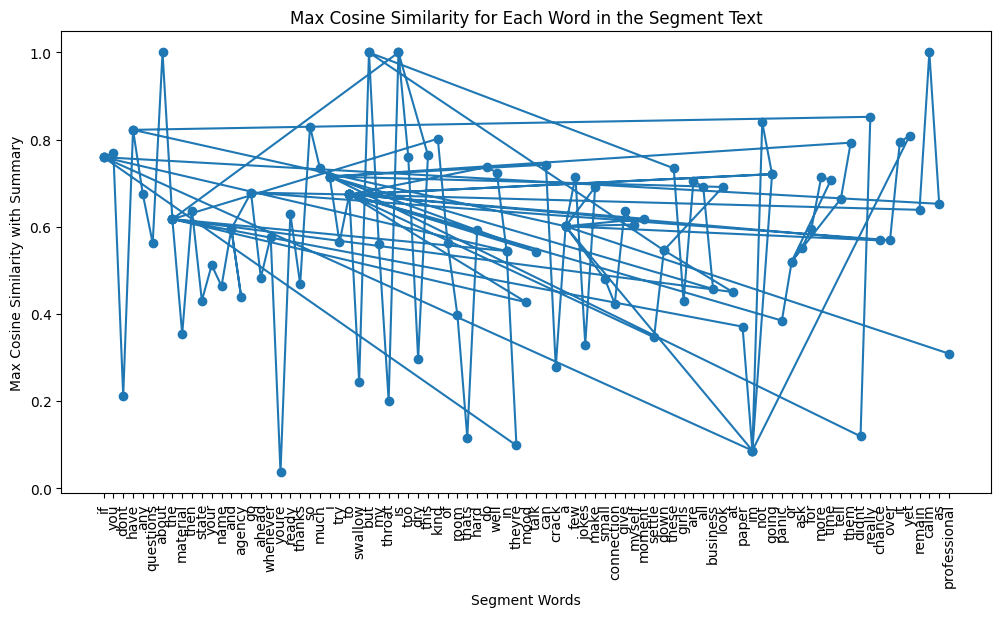

In [ ]:
# let's see one trial

# Let's consider you want to visualize the data for the first trial
trial_index = 0  # You can change this index to visualize a different trial

# Extract the segment text and summary for this trial
segment_text = df.iloc[trial_index]['segment_text']
summary = df.iloc[trial_index]['textbox.text_corrected_manual']

# Assuming 'similarity_matrices' contains the matrices for all trials
similarity_matrix = similarity_matrices[trial_index]

# Check if the trial has data
if similarity_matrix.size == 0:
    print("No similarity data available for this trial.")
else:
    # Get the maximum similarity scores for each word in segment_text
    max_similarity_scores = similarity_matrix.max(axis=0)  # max along columns, for each word in segment_text

    # Prepare segment_text for plotting
    segment_words = [re.sub(r'[^\w\s]', '', w).lower() for w in segment_text.split()]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(segment_words, max_similarity_scores, marker='o', linestyle='-')
    plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
    plt.xlabel("Segment Words")
    plt.ylabel("Max Cosine Similarity with Summary")
    plt.title("Max Cosine Similarity for Each Word in the Segment Text")
    plt.show()

In [ ]:
# add this as a column to the dataset

# Create a new column for average_max_similarity, initializing with NaN
df['glove_text_average_max_similarity'] = np.nan

# Assuming the indices in df where 'textbox.text_corrected_manual' is not NaN match the order of calculations
non_nan_indices = df.index[df['textbox.text_corrected_manual'].notna()].tolist()
for calculated_index, df_index in enumerate(non_nan_indices):
    # Safeguard against mismatch in length of calculated scores and indices
    if calculated_index < len(trial_scores):
        df.at[df_index, 'glove_text_average_max_similarity'] = trial_scores[calculated_index]

# Display the updated DataFrame
print(df[['textbox.text_corrected_manual', 'segment_text', 'glove_text_average_max_similarity']])

                          textbox.text_corrected_manual  \
0     person is anxious about something, but is reas...   
1                                                   NaN   
2                                                   NaN   
3                                                   NaN   
4                                think boyfriend garage   
...                                                 ...   
2745             Name, agency, other girls, the real me   
2746  Franny imagines the executives in the room tha...   
2747  Franny talks about the tangible life changes s...   
2748                                                NaN   
2749                                                NaN   

                                           segment_text  \
0     If you don't have any questions about the mate...   
1     From the minute I walk into the wardrobe fitti...   
2     I'll admit it's sort of a sick relationship to...   
3     The end Huh I say baffled The end is supposed ...

3. Using BERT to compare the whole text with the whole summary



In [ ]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def cosine(x, y):
  return x@y/(np.linalg.norm(x)*np.linalg.norm(y))

In [ ]:
# Initialize a new column for cosine similarity in df
df['bert_cosine_similarity'] = np.nan

# Iterate over DataFrame rows with progress tracking
for index, row in tqdm(df.iterrows(), total=len(df)):
    summary = row['textbox.text_corrected_manual']
    stimulus = row['segment_text']
    # Check if the summary is NaN
    if pd.isna(summary):
        print(f"Skipping index {index} because summary is NaN.")
        continue  # Skip processing this row as summary is NaN
    # Clean and lower case summary words
    summary_words = [re.sub(r'[^\w\s]', '', word).lower() for word in summary.split()]
    # Join cleaned words back into a single string for encoding
    processed_summary = " ".join(summary_words)

    # Encode the processed summary and stimulus text into embeddings
    embeddings = model.encode([processed_summary, stimulus])

    # Ensure embeddings are valid (i.e., not empty) before calculations
    if embeddings[0].size == 0 or embeddings[1].size == 0:
        print(f"Empty embeddings at index {index}. Check model input and output.")
        continue

    # Calculate cosine similarity
    cosine_similarity = cosine(embeddings[0], embeddings[1]) #buradaki cosine degismek zorunda olabilir
    print (cosine_similarity)
    # Directly update the DataFrame with the calculated values
    df.at[index, 'bert_cosine_similarity'] = cosine_similarity

# Print the updated DataFrame to verify the changes
print(df[['textbox.text_corrected_manual', 'segment_text', 'bert_cosine_similarity']].head())

  0%|          | 1/2750 [00:01<54:00,  1.18s/it]

0.25435096
Skipping index 1 because summary is NaN.
Skipping index 2 because summary is NaN.
Skipping index 3 because summary is NaN.


  0%|          | 5/2750 [00:02<16:13,  2.82it/s]

0.049534004


  0%|          | 6/2750 [00:02<20:17,  2.25it/s]

0.42153856
Skipping index 6 because summary is NaN.


  0%|          | 8/2750 [00:03<19:52,  2.30it/s]

0.14948055


  0%|          | 9/2750 [00:04<26:32,  1.72it/s]

0.4684273


  0%|          | 10/2750 [00:05<31:11,  1.46it/s]

0.4844166
Skipping index 10 because summary is NaN.


  0%|          | 12/2750 [00:06<28:04,  1.62it/s]

0.62143636
Skipping index 12 because summary is NaN.
Skipping index 13 because summary is NaN.
Skipping index 14 because summary is NaN.


  1%|          | 16/2750 [00:07<18:14,  2.50it/s]

0.48215735
Skipping index 16 because summary is NaN.


  1%|          | 18/2750 [00:08<20:15,  2.25it/s]

0.7916136
Skipping index 18 because summary is NaN.


  1%|          | 20/2750 [00:09<18:45,  2.43it/s]

0.39533934
Skipping index 20 because summary is NaN.
Skipping index 21 because summary is NaN.


  1%|          | 23/2750 [00:10<16:34,  2.74it/s]

0.60944843


  1%|          | 24/2750 [00:10<18:48,  2.42it/s]

0.7767967


  1%|          | 25/2750 [00:11<20:18,  2.24it/s]

0.35096347
Skipping index 25 because summary is NaN.
Skipping index 26 because summary is NaN.


  1%|          | 28/2750 [00:12<16:25,  2.76it/s]

0.099726655


  1%|          | 29/2750 [00:12<18:16,  2.48it/s]

0.29429248


  1%|          | 30/2750 [00:13<21:19,  2.13it/s]

0.5952516
Skipping index 30 because summary is NaN.


  1%|          | 32/2750 [00:14<20:32,  2.21it/s]

0.09345784
Skipping index 32 because summary is NaN.


  1%|          | 34/2750 [00:15<19:39,  2.30it/s]

0.035931475
Skipping index 34 because summary is NaN.
Skipping index 35 because summary is NaN.


  1%|▏         | 37/2750 [00:16<19:27,  2.32it/s]

0.26833805


  1%|▏         | 38/2750 [00:17<22:00,  2.05it/s]

0.17466687
Skipping index 38 because summary is NaN.


  1%|▏         | 40/2750 [00:18<20:35,  2.19it/s]

0.036848493


  1%|▏         | 41/2750 [00:18<23:10,  1.95it/s]

0.5294212
Skipping index 41 because summary is NaN.
Skipping index 42 because summary is NaN.
Skipping index 43 because summary is NaN.
Skipping index 44 because summary is NaN.


  2%|▏         | 46/2750 [00:20<17:37,  2.56it/s]

0.35979939
Skipping index 46 because summary is NaN.
Skipping index 47 because summary is NaN.
Skipping index 48 because summary is NaN.
Skipping index 49 because summary is NaN.


  2%|▏         | 51/2750 [00:21<13:35,  3.31it/s]

0.484717
Skipping index 51 because summary is NaN.


  2%|▏         | 53/2750 [00:22<15:40,  2.87it/s]

0.41707104


  2%|▏         | 54/2750 [00:23<20:48,  2.16it/s]

0.5776842
Skipping index 54 because summary is NaN.
Skipping index 55 because summary is NaN.
Skipping index 56 because summary is NaN.


  2%|▏         | 58/2750 [00:24<16:14,  2.76it/s]

0.3299162


  2%|▏         | 59/2750 [00:25<18:41,  2.40it/s]

0.06647457


  2%|▏         | 60/2750 [00:25<19:46,  2.27it/s]

0.3483522


  2%|▏         | 61/2750 [00:26<21:48,  2.06it/s]

0.31301194
Skipping index 61 because summary is NaN.


  2%|▏         | 63/2750 [00:27<18:59,  2.36it/s]

0.49750787
Skipping index 63 because summary is NaN.


  2%|▏         | 65/2750 [00:27<17:07,  2.61it/s]

0.5405554


  2%|▏         | 66/2750 [00:28<20:41,  2.16it/s]

0.4101888


  2%|▏         | 67/2750 [00:29<23:13,  1.92it/s]

0.45210737
Skipping index 67 because summary is NaN.
Skipping index 68 because summary is NaN.


  3%|▎         | 70/2750 [00:29<16:56,  2.64it/s]

0.7243005
Skipping index 70 because summary is NaN.


  3%|▎         | 72/2750 [00:30<16:38,  2.68it/s]

0.44173357


  3%|▎         | 73/2750 [00:31<20:26,  2.18it/s]

0.4490476


  3%|▎         | 74/2750 [00:32<22:03,  2.02it/s]

0.52867484


  3%|▎         | 75/2750 [00:32<24:25,  1.82it/s]

0.06330707


  3%|▎         | 76/2750 [00:33<26:06,  1.71it/s]

0.62237227
Skipping index 76 because summary is NaN.


  3%|▎         | 78/2750 [00:34<22:58,  1.94it/s]

0.24118131


  3%|▎         | 79/2750 [00:35<28:21,  1.57it/s]

0.5841932
Skipping index 79 because summary is NaN.


  3%|▎         | 81/2750 [00:36<26:02,  1.71it/s]

0.5901331


  3%|▎         | 82/2750 [00:37<31:13,  1.42it/s]

0.18183936
Skipping index 82 because summary is NaN.


  3%|▎         | 84/2750 [00:38<28:09,  1.58it/s]

0.47418112


  3%|▎         | 85/2750 [00:39<29:08,  1.52it/s]

0.5389485
Skipping index 85 because summary is NaN.


  3%|▎         | 87/2750 [00:40<24:46,  1.79it/s]

0.3653276
Skipping index 87 because summary is NaN.


  3%|▎         | 89/2750 [00:40<21:45,  2.04it/s]

0.31378773
Skipping index 89 because summary is NaN.


  3%|▎         | 91/2750 [00:42<24:38,  1.80it/s]

0.24567537


  3%|▎         | 92/2750 [00:43<30:42,  1.44it/s]

0.26015684


  3%|▎         | 93/2750 [00:44<30:32,  1.45it/s]

0.6394279
Skipping index 93 because summary is NaN.


  3%|▎         | 95/2750 [00:44<24:09,  1.83it/s]

0.36751983


  3%|▎         | 96/2750 [00:45<25:58,  1.70it/s]

0.47697034


  4%|▎         | 97/2750 [00:46<28:57,  1.53it/s]

0.27520868


  4%|▎         | 98/2750 [00:47<29:02,  1.52it/s]

0.51590323
Skipping index 98 because summary is NaN.
Skipping index 99 because summary is NaN.


  4%|▎         | 101/2750 [00:47<18:36,  2.37it/s]

0.2112445


  4%|▎         | 102/2750 [00:48<21:03,  2.10it/s]

0.51962143


  4%|▎         | 103/2750 [00:49<24:39,  1.79it/s]

0.37661445


  4%|▍         | 104/2750 [00:50<30:27,  1.45it/s]

0.47918895
Skipping index 104 because summary is NaN.
Skipping index 105 because summary is NaN.


  4%|▍         | 107/2750 [00:51<24:08,  1.82it/s]

0.34782445


  4%|▍         | 108/2750 [00:52<27:58,  1.57it/s]

0.08198171
Skipping index 108 because summary is NaN.
Skipping index 109 because summary is NaN.
Skipping index 110 because summary is NaN.


  4%|▍         | 112/2750 [00:53<19:40,  2.23it/s]

0.27085912


  4%|▍         | 113/2750 [00:54<22:40,  1.94it/s]

0.4654072


  4%|▍         | 114/2750 [00:55<24:28,  1.79it/s]

0.098184615


  4%|▍         | 115/2750 [00:56<26:50,  1.64it/s]

0.47688732
Skipping index 115 because summary is NaN.


  4%|▍         | 117/2750 [00:56<22:04,  1.99it/s]

0.2787559


  4%|▍         | 118/2750 [00:57<22:27,  1.95it/s]

0.5391565


  4%|▍         | 119/2750 [00:58<24:06,  1.82it/s]

0.43238884


  4%|▍         | 120/2750 [00:58<26:37,  1.65it/s]

0.5488094


  4%|▍         | 121/2750 [00:59<30:16,  1.45it/s]

0.59207493


  4%|▍         | 122/2750 [01:00<30:21,  1.44it/s]

0.39989054
Skipping index 122 because summary is NaN.
Skipping index 123 because summary is NaN.


  5%|▍         | 125/2750 [01:01<18:42,  2.34it/s]

0.40662473
Skipping index 125 because summary is NaN.


  5%|▍         | 127/2750 [01:01<17:59,  2.43it/s]

0.4364579


  5%|▍         | 128/2750 [01:02<20:06,  2.17it/s]

0.20044778


  5%|▍         | 129/2750 [01:03<22:27,  1.94it/s]

0.6879054


  5%|▍         | 130/2750 [01:03<23:21,  1.87it/s]

0.4010375
Skipping index 130 because summary is NaN.
Skipping index 131 because summary is NaN.
Skipping index 132 because summary is NaN.
Skipping index 133 because summary is NaN.
Skipping index 134 because summary is NaN.


  5%|▍         | 136/2750 [01:04<12:51,  3.39it/s]

0.42824906


  5%|▍         | 137/2750 [01:06<18:13,  2.39it/s]

0.48575032


  5%|▌         | 138/2750 [01:07<22:55,  1.90it/s]

0.6631819


  5%|▌         | 139/2750 [01:08<26:43,  1.63it/s]

0.47689968


  5%|▌         | 140/2750 [01:09<30:50,  1.41it/s]

0.56069875


  5%|▌         | 141/2750 [01:10<32:46,  1.33it/s]

0.46614632
Skipping index 141 because summary is NaN.


  5%|▌         | 143/2750 [01:10<25:51,  1.68it/s]

0.14277102


  5%|▌         | 144/2750 [01:11<27:10,  1.60it/s]

0.5719357


  5%|▌         | 145/2750 [01:12<26:58,  1.61it/s]

0.2779356
Skipping index 145 because summary is NaN.
Skipping index 146 because summary is NaN.
Skipping index 147 because summary is NaN.


  5%|▌         | 149/2750 [01:12<16:34,  2.62it/s]

0.21231443
Skipping index 149 because summary is NaN.


  5%|▌         | 151/2750 [01:13<16:13,  2.67it/s]

0.19631867
Skipping index 151 because summary is NaN.


  6%|▌         | 153/2750 [01:14<15:38,  2.77it/s]

0.45281267
Skipping index 153 because summary is NaN.


  6%|▌         | 155/2750 [01:14<15:12,  2.84it/s]

0.5847647
Skipping index 155 because summary is NaN.


  6%|▌         | 157/2750 [01:15<15:44,  2.75it/s]

0.59033096


  6%|▌         | 158/2750 [01:16<18:40,  2.31it/s]

0.5145797


  6%|▌         | 159/2750 [01:17<21:27,  2.01it/s]

0.5212212


  6%|▌         | 160/2750 [01:17<22:56,  1.88it/s]

0.18340984
Skipping index 160 because summary is NaN.
Skipping index 161 because summary is NaN.


  6%|▌         | 163/2750 [01:18<15:28,  2.79it/s]

0.37387538
Skipping index 163 because summary is NaN.
Skipping index 164 because summary is NaN.


  6%|▌         | 166/2750 [01:19<13:08,  3.28it/s]

0.5173754
Skipping index 166 because summary is NaN.


  6%|▌         | 168/2750 [01:20<16:15,  2.65it/s]

0.6110855


  6%|▌         | 169/2750 [01:21<22:34,  1.91it/s]

0.5510729
Skipping index 169 because summary is NaN.


  6%|▌         | 171/2750 [01:22<23:53,  1.80it/s]

0.5672312
Skipping index 171 because summary is NaN.
Skipping index 172 because summary is NaN.
Skipping index 173 because summary is NaN.
Skipping index 174 because summary is NaN.
Skipping index 175 because summary is NaN.


  6%|▋         | 177/2750 [01:23<14:41,  2.92it/s]

0.4604008
Skipping index 177 because summary is NaN.


  7%|▋         | 179/2750 [01:24<14:33,  2.94it/s]

0.64498097
Skipping index 179 because summary is NaN.


  7%|▋         | 181/2750 [01:25<14:35,  2.93it/s]

0.682045


  7%|▋         | 182/2750 [01:26<17:28,  2.45it/s]

0.46268028


  7%|▋         | 183/2750 [01:26<18:57,  2.26it/s]

-0.023433683
Skipping index 183 because summary is NaN.
Skipping index 184 because summary is NaN.


  7%|▋         | 186/2750 [01:27<15:33,  2.75it/s]

0.0066958154


  7%|▋         | 187/2750 [01:28<18:38,  2.29it/s]

0.30474865


  7%|▋         | 188/2750 [01:29<21:34,  1.98it/s]

0.5839434


  7%|▋         | 189/2750 [01:29<22:40,  1.88it/s]

0.13575163
Skipping index 189 because summary is NaN.


  7%|▋         | 191/2750 [01:30<20:19,  2.10it/s]

0.43625838


  7%|▋         | 192/2750 [01:31<22:14,  1.92it/s]

0.5626026


  7%|▋         | 193/2750 [01:31<22:44,  1.87it/s]

0.35724193


  7%|▋         | 194/2750 [01:32<23:58,  1.78it/s]

0.28202897
Skipping index 194 because summary is NaN.
Skipping index 195 because summary is NaN.


  7%|▋         | 197/2750 [01:33<17:09,  2.48it/s]

0.5176499


  7%|▋         | 198/2750 [01:33<19:51,  2.14it/s]

0.3419687


  7%|▋         | 199/2750 [01:34<23:37,  1.80it/s]

0.5711328
Skipping index 199 because summary is NaN.
Skipping index 200 because summary is NaN.


  7%|▋         | 202/2750 [01:35<19:12,  2.21it/s]

0.58554316


  7%|▋         | 203/2750 [01:36<23:22,  1.82it/s]

0.59713465
Skipping index 203 because summary is NaN.
Skipping index 204 because summary is NaN.


  7%|▋         | 206/2750 [01:37<20:15,  2.09it/s]

0.16392808


  8%|▊         | 207/2750 [01:38<24:32,  1.73it/s]

0.37086284


  8%|▊         | 208/2750 [01:39<28:35,  1.48it/s]

0.33056077


  8%|▊         | 209/2750 [01:41<33:17,  1.27it/s]

0.61976635


  8%|▊         | 210/2750 [01:42<34:31,  1.23it/s]

0.52463925
Skipping index 210 because summary is NaN.


  8%|▊         | 212/2750 [01:42<26:14,  1.61it/s]

0.050261576


  8%|▊         | 213/2750 [01:43<27:11,  1.56it/s]

0.49601102


  8%|▊         | 214/2750 [01:44<27:19,  1.55it/s]

0.43592325
Skipping index 214 because summary is NaN.


  8%|▊         | 216/2750 [01:44<23:00,  1.84it/s]

0.23125881
Skipping index 216 because summary is NaN.


  8%|▊         | 218/2750 [01:45<19:59,  2.11it/s]

0.24588963


  8%|▊         | 219/2750 [01:46<22:13,  1.90it/s]

0.49177757


  8%|▊         | 220/2750 [01:47<24:25,  1.73it/s]

0.47174603


  8%|▊         | 221/2750 [01:47<24:42,  1.71it/s]

0.40252188


  8%|▊         | 222/2750 [01:48<26:28,  1.59it/s]

0.5001247


  8%|▊         | 223/2750 [01:49<27:02,  1.56it/s]

0.4307133
Skipping index 223 because summary is NaN.
Skipping index 224 because summary is NaN.


  8%|▊         | 226/2750 [01:50<19:29,  2.16it/s]

0.5238326
Skipping index 226 because summary is NaN.
Skipping index 227 because summary is NaN.


  8%|▊         | 229/2750 [01:51<17:18,  2.43it/s]

0.36966938
Skipping index 229 because summary is NaN.


  8%|▊         | 231/2750 [01:52<20:09,  2.08it/s]

0.35581252
Skipping index 231 because summary is NaN.


  8%|▊         | 233/2750 [01:53<22:24,  1.87it/s]

0.31736642


  9%|▊         | 234/2750 [01:54<24:25,  1.72it/s]

0.1801513


  9%|▊         | 235/2750 [01:55<26:13,  1.60it/s]

0.12688501
Skipping index 235 because summary is NaN.


  9%|▊         | 237/2750 [01:56<22:04,  1.90it/s]

0.7419027


  9%|▊         | 238/2750 [01:56<22:19,  1.88it/s]

0.51778764
Skipping index 238 because summary is NaN.


  9%|▊         | 240/2750 [01:57<19:11,  2.18it/s]

0.28432235


  9%|▉         | 241/2750 [01:57<21:40,  1.93it/s]

0.43358743


  9%|▉         | 242/2750 [01:58<24:35,  1.70it/s]

0.30525315


  9%|▉         | 243/2750 [01:59<25:52,  1.62it/s]

0.5283768


  9%|▉         | 244/2750 [02:00<26:20,  1.59it/s]

0.3618769
Skipping index 244 because summary is NaN.


  9%|▉         | 246/2750 [02:00<21:22,  1.95it/s]

0.11760111
Skipping index 246 because summary is NaN.


  9%|▉         | 248/2750 [02:01<18:30,  2.25it/s]

0.42234093


  9%|▉         | 249/2750 [02:02<21:08,  1.97it/s]

0.45124897
Skipping index 249 because summary is NaN.
Skipping index 250 because summary is NaN.


  9%|▉         | 252/2750 [02:03<16:03,  2.59it/s]

0.45760402


  9%|▉         | 253/2750 [02:03<18:39,  2.23it/s]

0.44207835
Skipping index 253 because summary is NaN.
Skipping index 254 because summary is NaN.


  9%|▉         | 256/2750 [02:04<16:47,  2.48it/s]

0.4987919
Skipping index 256 because summary is NaN.


  9%|▉         | 258/2750 [02:05<17:17,  2.40it/s]

0.6079116


  9%|▉         | 259/2750 [02:06<23:02,  1.80it/s]

0.21408498
Skipping index 259 because summary is NaN.


  9%|▉         | 261/2750 [02:08<23:17,  1.78it/s]

0.29969287


 10%|▉         | 262/2750 [02:09<28:04,  1.48it/s]

0.21900457


 10%|▉         | 263/2750 [02:10<31:12,  1.33it/s]

0.3291164
Skipping index 263 because summary is NaN.


 10%|▉         | 265/2750 [02:11<25:29,  1.63it/s]

0.5096113
Skipping index 265 because summary is NaN.
Skipping index 266 because summary is NaN.
Skipping index 267 because summary is NaN.
Skipping index 268 because summary is NaN.
Skipping index 269 because summary is NaN.


 10%|▉         | 271/2750 [02:11<13:09,  3.14it/s]

0.48419383
Skipping index 271 because summary is NaN.
Skipping index 272 because summary is NaN.


 10%|▉         | 274/2750 [02:12<12:11,  3.38it/s]

0.568718
Skipping index 274 because summary is NaN.


 10%|█         | 276/2750 [02:13<12:30,  3.30it/s]

0.47386083


 10%|█         | 277/2750 [02:14<15:01,  2.74it/s]

0.47630557


 10%|█         | 278/2750 [02:14<17:06,  2.41it/s]

0.6774981
Skipping index 278 because summary is NaN.
Skipping index 279 because summary is NaN.


 10%|█         | 281/2750 [02:15<13:43,  3.00it/s]

0.43056616
Skipping index 281 because summary is NaN.
Skipping index 282 because summary is NaN.


 10%|█         | 284/2750 [02:16<12:27,  3.30it/s]

0.5313


 10%|█         | 285/2750 [02:16<14:08,  2.90it/s]

0.42475244
Skipping index 285 because summary is NaN.
Skipping index 286 because summary is NaN.


 10%|█         | 288/2750 [02:17<12:11,  3.36it/s]

0.37766775
Skipping index 288 because summary is NaN.
Skipping index 289 because summary is NaN.


 11%|█         | 291/2750 [02:18<11:58,  3.42it/s]

0.33841702
Skipping index 291 because summary is NaN.
Skipping index 292 because summary is NaN.


 11%|█         | 294/2750 [02:18<10:38,  3.85it/s]

0.5439679


 11%|█         | 295/2750 [02:19<13:10,  3.11it/s]

0.47818685
Skipping index 295 because summary is NaN.


 11%|█         | 297/2750 [02:20<15:08,  2.70it/s]

0.5100399
Skipping index 297 because summary is NaN.


 11%|█         | 299/2750 [02:21<16:57,  2.41it/s]

0.44957808
Skipping index 299 because summary is NaN.


 11%|█         | 301/2750 [02:22<18:12,  2.24it/s]

0.4370498
Skipping index 301 because summary is NaN.


 11%|█         | 303/2750 [02:23<18:41,  2.18it/s]

0.45387706
Skipping index 303 because summary is NaN.
Skipping index 304 because summary is NaN.
Skipping index 305 because summary is NaN.
Skipping index 306 because summary is NaN.


 11%|█         | 308/2750 [02:24<13:02,  3.12it/s]

0.40902987
Skipping index 308 because summary is NaN.
Skipping index 309 because summary is NaN.
Skipping index 310 because summary is NaN.
Skipping index 311 because summary is NaN.
Skipping index 312 because summary is NaN.


 11%|█▏        | 314/2750 [02:25<09:22,  4.33it/s]

0.6241762
Skipping index 314 because summary is NaN.
Skipping index 315 because summary is NaN.


 12%|█▏        | 317/2750 [02:26<10:02,  4.04it/s]

0.38761532
Skipping index 317 because summary is NaN.
Skipping index 318 because summary is NaN.
Skipping index 319 because summary is NaN.
Skipping index 320 because summary is NaN.
Skipping index 321 because summary is NaN.


 12%|█▏        | 323/2750 [02:26<07:29,  5.41it/s]

0.6257067


 12%|█▏        | 324/2750 [02:27<09:19,  4.34it/s]

0.5114175


 12%|█▏        | 325/2750 [02:28<12:13,  3.30it/s]

0.56072396


 12%|█▏        | 326/2750 [02:28<14:27,  2.79it/s]

0.078317635


 12%|█▏        | 327/2750 [02:29<16:58,  2.38it/s]

-0.04410709
Skipping index 327 because summary is NaN.


 12%|█▏        | 329/2750 [02:30<16:32,  2.44it/s]

0.502765


 12%|█▏        | 330/2750 [02:31<20:35,  1.96it/s]

0.34770176


 12%|█▏        | 331/2750 [02:32<20:59,  1.92it/s]

0.39056474


 12%|█▏        | 332/2750 [02:32<22:13,  1.81it/s]

0.5280653
Skipping index 332 because summary is NaN.
Skipping index 333 because summary is NaN.


 12%|█▏        | 335/2750 [02:33<15:51,  2.54it/s]

0.5430748


 12%|█▏        | 336/2750 [02:34<18:36,  2.16it/s]

0.15193185
Skipping index 336 because summary is NaN.


 12%|█▏        | 338/2750 [02:34<17:19,  2.32it/s]

0.16852224
Skipping index 338 because summary is NaN.
Skipping index 339 because summary is NaN.


 12%|█▏        | 341/2750 [02:35<16:11,  2.48it/s]

0.38042498


 12%|█▏        | 342/2750 [02:37<21:37,  1.86it/s]

0.44724083
Skipping index 342 because summary is NaN.
Skipping index 343 because summary is NaN.


 13%|█▎        | 345/2750 [02:38<18:27,  2.17it/s]

0.5076661


 13%|█▎        | 346/2750 [02:39<23:19,  1.72it/s]

0.15548186


 13%|█▎        | 347/2750 [02:40<23:25,  1.71it/s]

0.2640755


 13%|█▎        | 348/2750 [02:40<25:16,  1.58it/s]

0.5155681


 13%|█▎        | 349/2750 [02:41<25:25,  1.57it/s]

0.36000898


 13%|█▎        | 350/2750 [02:42<26:00,  1.54it/s]

0.49412546


 13%|█▎        | 351/2750 [02:42<27:06,  1.47it/s]

0.38759136


 13%|█▎        | 352/2750 [02:43<26:22,  1.51it/s]

0.33496478


 13%|█▎        | 353/2750 [02:44<28:11,  1.42it/s]

0.2911684
Skipping index 353 because summary is NaN.
Skipping index 354 because summary is NaN.


 13%|█▎        | 356/2750 [02:45<17:40,  2.26it/s]

0.071936026
Skipping index 356 because summary is NaN.
Skipping index 357 because summary is NaN.
Skipping index 358 because summary is NaN.
Skipping index 359 because summary is NaN.


 13%|█▎        | 361/2750 [02:45<11:19,  3.52it/s]

0.42404678
Skipping index 361 because summary is NaN.


 13%|█▎        | 363/2750 [02:46<11:45,  3.38it/s]

0.46412972


 13%|█▎        | 364/2750 [02:47<13:40,  2.91it/s]

0.46495974


 13%|█▎        | 365/2750 [02:47<16:06,  2.47it/s]

0.29136795
Skipping index 365 because summary is NaN.


 13%|█▎        | 367/2750 [02:48<15:33,  2.55it/s]

0.45669186


 13%|█▎        | 368/2750 [02:49<19:01,  2.09it/s]

0.33406502


 13%|█▎        | 369/2750 [02:50<23:06,  1.72it/s]

0.29508564
Skipping index 369 because summary is NaN.
Skipping index 370 because summary is NaN.
Skipping index 371 because summary is NaN.


 14%|█▎        | 373/2750 [02:51<16:42,  2.37it/s]

0.40633923
Skipping index 373 because summary is NaN.
Skipping index 374 because summary is NaN.
Skipping index 375 because summary is NaN.


 14%|█▎        | 377/2750 [02:52<13:44,  2.88it/s]

0.6074791


 14%|█▎        | 378/2750 [02:53<18:03,  2.19it/s]

0.6540672


 14%|█▍        | 379/2750 [02:54<20:33,  1.92it/s]

0.6081787
Skipping index 379 because summary is NaN.


 14%|█▍        | 381/2750 [02:55<18:43,  2.11it/s]

0.2136384


 14%|█▍        | 382/2750 [02:56<20:57,  1.88it/s]

0.14091153


 14%|█▍        | 383/2750 [02:56<22:27,  1.76it/s]

0.25542805
Skipping index 383 because summary is NaN.


 14%|█▍        | 385/2750 [02:57<19:50,  1.99it/s]

0.27732983


 14%|█▍        | 386/2750 [02:58<20:36,  1.91it/s]

0.60234594
Skipping index 386 because summary is NaN.
Skipping index 387 because summary is NaN.


 14%|█▍        | 389/2750 [02:58<15:46,  2.49it/s]

0.6446895
Skipping index 389 because summary is NaN.
Skipping index 390 because summary is NaN.


 14%|█▍        | 392/2750 [02:59<13:04,  3.01it/s]

0.5560956
Skipping index 392 because summary is NaN.
Skipping index 393 because summary is NaN.
Skipping index 394 because summary is NaN.
Skipping index 395 because summary is NaN.
Skipping index 396 because summary is NaN.
Skipping index 397 because summary is NaN.


 15%|█▍        | 399/2750 [03:00<07:46,  5.04it/s]

0.5368476
Skipping index 399 because summary is NaN.


 15%|█▍        | 401/2750 [03:00<08:35,  4.56it/s]

0.31262085


 15%|█▍        | 402/2750 [03:01<10:31,  3.72it/s]

0.5053903


 15%|█▍        | 403/2750 [03:02<13:37,  2.87it/s]

0.12174822


 15%|█▍        | 404/2750 [03:03<15:30,  2.52it/s]

0.49271378


 15%|█▍        | 405/2750 [03:03<18:12,  2.15it/s]

0.26762432


 15%|█▍        | 406/2750 [03:04<21:59,  1.78it/s]

0.49630117
Skipping index 406 because summary is NaN.


 15%|█▍        | 408/2750 [03:05<20:41,  1.89it/s]

0.44836


 15%|█▍        | 409/2750 [03:06<24:54,  1.57it/s]

0.28953853
Skipping index 409 because summary is NaN.
Skipping index 410 because summary is NaN.


 15%|█▍        | 412/2750 [03:07<19:10,  2.03it/s]

0.32038036


 15%|█▌        | 413/2750 [03:08<24:53,  1.56it/s]

0.81123036


 15%|█▌        | 414/2750 [03:09<25:59,  1.50it/s]

0.33388075


 15%|█▌        | 415/2750 [03:10<25:39,  1.52it/s]

0.46960908


 15%|█▌        | 416/2750 [03:11<26:21,  1.48it/s]

0.55343395
Skipping index 416 because summary is NaN.
Skipping index 417 because summary is NaN.


 15%|█▌        | 419/2750 [03:11<17:50,  2.18it/s]

0.50077856
Skipping index 419 because summary is NaN.
Skipping index 420 because summary is NaN.


 15%|█▌        | 422/2750 [03:12<15:06,  2.57it/s]

0.5088242
Skipping index 422 because summary is NaN.


 15%|█▌        | 424/2750 [03:13<14:41,  2.64it/s]

0.14370576


 15%|█▌        | 425/2750 [03:14<16:40,  2.32it/s]

0.5472179
Skipping index 425 because summary is NaN.
Skipping index 426 because summary is NaN.


 16%|█▌        | 428/2750 [03:15<14:32,  2.66it/s]

0.38541186
Skipping index 428 because summary is NaN.
Skipping index 429 because summary is NaN.
Skipping index 430 because summary is NaN.
Skipping index 431 because summary is NaN.
Skipping index 432 because summary is NaN.
Skipping index 433 because summary is NaN.


 16%|█▌        | 435/2750 [03:15<08:37,  4.47it/s]

0.20553923


 16%|█▌        | 436/2750 [03:16<10:34,  3.64it/s]

0.4364266


 16%|█▌        | 437/2750 [03:17<12:39,  3.04it/s]

0.4995816
Skipping index 437 because summary is NaN.
Skipping index 438 because summary is NaN.
Skipping index 439 because summary is NaN.


 16%|█▌        | 441/2750 [03:18<10:41,  3.60it/s]

0.06575136


 16%|█▌        | 442/2750 [03:18<13:12,  2.91it/s]

0.61289567
Skipping index 442 because summary is NaN.
Skipping index 443 because summary is NaN.
Skipping index 444 because summary is NaN.


 16%|█▌        | 446/2750 [03:19<10:05,  3.81it/s]

0.31489614
Skipping index 446 because summary is NaN.


 16%|█▋        | 448/2750 [03:20<12:56,  2.97it/s]

0.5084596
Skipping index 448 because summary is NaN.
Skipping index 449 because summary is NaN.


 16%|█▋        | 451/2750 [03:21<13:41,  2.80it/s]

0.3326929


 16%|█▋        | 452/2750 [03:22<17:14,  2.22it/s]

0.56132025


 16%|█▋        | 453/2750 [03:23<21:07,  1.81it/s]

0.15495685


 17%|█▋        | 454/2750 [03:24<23:45,  1.61it/s]

0.57737964


 17%|█▋        | 455/2750 [03:25<25:13,  1.52it/s]

0.62672067
Skipping index 455 because summary is NaN.


 17%|█▋        | 457/2750 [03:26<22:22,  1.71it/s]

0.6282866


 17%|█▋        | 458/2750 [03:27<26:34,  1.44it/s]

0.26576242
Skipping index 458 because summary is NaN.


 17%|█▋        | 460/2750 [03:28<23:26,  1.63it/s]

0.2177185
Skipping index 460 because summary is NaN.
Skipping index 461 because summary is NaN.


 17%|█▋        | 463/2750 [03:29<16:48,  2.27it/s]

0.3682116


 17%|█▋        | 464/2750 [03:29<18:14,  2.09it/s]

0.44889435


 17%|█▋        | 465/2750 [03:30<21:08,  1.80it/s]

0.24191621
Skipping index 465 because summary is NaN.


 17%|█▋        | 467/2750 [03:31<17:50,  2.13it/s]

0.56199926
Skipping index 467 because summary is NaN.


 17%|█▋        | 469/2750 [03:32<16:38,  2.28it/s]

0.5330838
Skipping index 469 because summary is NaN.
Skipping index 470 because summary is NaN.


 17%|█▋        | 472/2750 [03:32<13:42,  2.77it/s]

0.34551108


 17%|█▋        | 473/2750 [03:33<15:37,  2.43it/s]

0.5897769


 17%|█▋        | 474/2750 [03:34<17:28,  2.17it/s]

0.6316599


 17%|█▋        | 475/2750 [03:34<19:22,  1.96it/s]

0.055453047


 17%|█▋        | 476/2750 [03:35<22:56,  1.65it/s]

0.34823123


 17%|█▋        | 477/2750 [03:36<27:02,  1.40it/s]

0.3679184


 17%|█▋        | 478/2750 [03:37<30:20,  1.25it/s]

0.66206276


 17%|█▋        | 479/2750 [03:39<34:56,  1.08it/s]

0.73781914


 17%|█▋        | 480/2750 [03:40<35:10,  1.08it/s]

0.34921563
Skipping index 480 because summary is NaN.
Skipping index 481 because summary is NaN.


 18%|█▊        | 483/2750 [03:40<19:32,  1.93it/s]

0.30969846


 18%|█▊        | 484/2750 [03:41<21:04,  1.79it/s]

0.26497754


 18%|█▊        | 485/2750 [03:42<22:16,  1.69it/s]

0.50849825


 18%|█▊        | 486/2750 [03:42<23:44,  1.59it/s]

0.5406662


 18%|█▊        | 487/2750 [03:43<25:17,  1.49it/s]

0.5040856


 18%|█▊        | 488/2750 [03:44<25:57,  1.45it/s]

0.451817
Skipping index 488 because summary is NaN.
Skipping index 489 because summary is NaN.
Skipping index 490 because summary is NaN.


 18%|█▊        | 492/2750 [03:45<14:09,  2.66it/s]

0.12718831


 18%|█▊        | 493/2750 [03:45<16:06,  2.34it/s]

0.6454705


 18%|█▊        | 494/2750 [03:46<18:18,  2.05it/s]

0.44521695


 18%|█▊        | 495/2750 [03:47<19:41,  1.91it/s]

0.5651631


 18%|█▊        | 496/2750 [03:47<22:14,  1.69it/s]

0.46380138
Skipping index 496 because summary is NaN.


 18%|█▊        | 498/2750 [03:48<18:20,  2.05it/s]

0.6413752
Skipping index 498 because summary is NaN.
Skipping index 499 because summary is NaN.
Skipping index 500 because summary is NaN.


 18%|█▊        | 502/2750 [03:49<12:04,  3.10it/s]

0.3726446
Skipping index 502 because summary is NaN.


 18%|█▊        | 504/2750 [03:50<13:00,  2.88it/s]

0.41635087
Skipping index 504 because summary is NaN.


 18%|█▊        | 506/2750 [03:51<14:46,  2.53it/s]

0.14797841
Skipping index 506 because summary is NaN.
Skipping index 507 because summary is NaN.
Skipping index 508 because summary is NaN.


 19%|█▊        | 510/2750 [03:52<13:18,  2.81it/s]

0.48094806


 19%|█▊        | 511/2750 [03:53<16:10,  2.31it/s]

0.466336


 19%|█▊        | 512/2750 [03:54<21:39,  1.72it/s]

0.4852986


 19%|█▊        | 513/2750 [03:55<23:24,  1.59it/s]

0.52070206
Skipping index 513 because summary is NaN.


 19%|█▊        | 515/2750 [03:56<19:19,  1.93it/s]

0.2191898


 19%|█▉        | 516/2750 [03:56<21:11,  1.76it/s]

0.56369007


 19%|█▉        | 517/2750 [03:57<21:59,  1.69it/s]

0.48096597


 19%|█▉        | 518/2750 [03:58<24:25,  1.52it/s]

0.46980652
Skipping index 518 because summary is NaN.


 19%|█▉        | 520/2750 [03:59<19:26,  1.91it/s]

0.4027135


 19%|█▉        | 521/2750 [03:59<20:45,  1.79it/s]

0.5645212
Skipping index 521 because summary is NaN.


 19%|█▉        | 523/2750 [04:00<17:01,  2.18it/s]

0.19535036
Skipping index 523 because summary is NaN.


 19%|█▉        | 525/2750 [04:01<16:19,  2.27it/s]

0.3271968


 19%|█▉        | 526/2750 [04:01<18:26,  2.01it/s]

0.61074305


 19%|█▉        | 527/2750 [04:02<20:09,  1.84it/s]

0.6602498
Skipping index 527 because summary is NaN.


 19%|█▉        | 529/2750 [04:03<17:16,  2.14it/s]

0.25425315


 19%|█▉        | 530/2750 [04:04<20:54,  1.77it/s]

0.34021384
Skipping index 530 because summary is NaN.
Skipping index 531 because summary is NaN.


 19%|█▉        | 533/2750 [04:04<15:08,  2.44it/s]

0.3051656


 19%|█▉        | 534/2750 [04:06<20:26,  1.81it/s]

0.13641435
Skipping index 534 because summary is NaN.


 19%|█▉        | 536/2750 [04:07<19:52,  1.86it/s]

0.30511773


 20%|█▉        | 537/2750 [04:08<23:58,  1.54it/s]

0.4511489
Skipping index 537 because summary is NaN.


 20%|█▉        | 539/2750 [04:09<22:21,  1.65it/s]

0.38489053
Skipping index 539 because summary is NaN.


 20%|█▉        | 541/2750 [04:10<21:41,  1.70it/s]

0.37843895


 20%|█▉        | 542/2750 [04:11<22:33,  1.63it/s]

0.17833559


 20%|█▉        | 543/2750 [04:11<23:58,  1.53it/s]

0.108016655


 20%|█▉        | 544/2750 [04:12<24:09,  1.52it/s]

0.55332994


 20%|█▉        | 545/2750 [04:13<24:43,  1.49it/s]

0.4214556
Skipping index 545 because summary is NaN.


 20%|█▉        | 547/2750 [04:14<20:38,  1.78it/s]

0.15698214


 20%|█▉        | 548/2750 [04:14<22:29,  1.63it/s]

0.35006368


 20%|█▉        | 549/2750 [04:15<24:26,  1.50it/s]

0.46323538
Skipping index 549 because summary is NaN.


 20%|██        | 551/2750 [04:16<20:04,  1.83it/s]

0.7262625
Skipping index 551 because summary is NaN.


 20%|██        | 553/2750 [04:17<16:24,  2.23it/s]

0.39425907


 20%|██        | 554/2750 [04:18<20:18,  1.80it/s]

0.41247508


 20%|██        | 555/2750 [04:18<22:20,  1.64it/s]

0.26331756
Skipping index 555 because summary is NaN.


 20%|██        | 557/2750 [04:19<19:32,  1.87it/s]

0.27109417


 20%|██        | 558/2750 [04:20<24:58,  1.46it/s]

0.4416023


 20%|██        | 559/2750 [04:22<29:37,  1.23it/s]

0.44687632
Skipping index 559 because summary is NaN.


 20%|██        | 561/2750 [04:23<25:22,  1.44it/s]

0.22167097
Skipping index 561 because summary is NaN.
Skipping index 562 because summary is NaN.
Skipping index 563 because summary is NaN.
Skipping index 564 because summary is NaN.


 21%|██        | 566/2750 [04:24<14:25,  2.52it/s]

0.16413985


 21%|██        | 567/2750 [04:25<17:53,  2.03it/s]

0.30307007


 21%|██        | 568/2750 [04:26<20:32,  1.77it/s]

0.64122343
Skipping index 568 because summary is NaN.
Skipping index 569 because summary is NaN.


 21%|██        | 571/2750 [04:26<15:56,  2.28it/s]

0.14234135


 21%|██        | 572/2750 [04:27<17:41,  2.05it/s]

0.71199495


 21%|██        | 573/2750 [04:28<18:44,  1.94it/s]

-0.05942818


 21%|██        | 574/2750 [04:28<20:08,  1.80it/s]

0.54528886


 21%|██        | 575/2750 [04:29<22:50,  1.59it/s]

0.34007758
Skipping index 575 because summary is NaN.


 21%|██        | 577/2750 [04:30<19:23,  1.87it/s]

0.3333112
Skipping index 577 because summary is NaN.


 21%|██        | 579/2750 [04:31<16:22,  2.21it/s]

0.17990477


 21%|██        | 580/2750 [04:31<17:39,  2.05it/s]

0.61625314
Skipping index 580 because summary is NaN.


 21%|██        | 582/2750 [04:32<15:33,  2.32it/s]

0.09576406
Skipping index 582 because summary is NaN.


 21%|██        | 584/2750 [04:33<14:52,  2.43it/s]

0.5938517
Skipping index 584 because summary is NaN.


 21%|██▏       | 586/2750 [04:33<14:19,  2.52it/s]

0.49542382


 21%|██▏       | 587/2750 [04:34<17:05,  2.11it/s]

0.16287605


 21%|██▏       | 588/2750 [04:35<18:18,  1.97it/s]

0.024721047
Skipping index 588 because summary is NaN.
Skipping index 589 because summary is NaN.


 21%|██▏       | 591/2750 [04:36<14:04,  2.56it/s]

0.47160652
Skipping index 591 because summary is NaN.
Skipping index 592 because summary is NaN.
Skipping index 593 because summary is NaN.
Skipping index 594 because summary is NaN.


 22%|██▏       | 596/2750 [04:37<10:13,  3.51it/s]

0.4692989
Skipping index 596 because summary is NaN.


 22%|██▏       | 598/2750 [04:38<12:28,  2.87it/s]

0.31682852
Skipping index 598 because summary is NaN.
Skipping index 599 because summary is NaN.
Skipping index 600 because summary is NaN.


 22%|██▏       | 602/2750 [04:39<11:41,  3.06it/s]

0.41702864


 22%|██▏       | 603/2750 [04:40<15:46,  2.27it/s]

0.30932513
Skipping index 603 because summary is NaN.
Skipping index 604 because summary is NaN.
Skipping index 605 because summary is NaN.


 22%|██▏       | 607/2750 [04:41<12:05,  2.95it/s]

0.35830075


 22%|██▏       | 608/2750 [04:42<13:11,  2.71it/s]

0.4605153


 22%|██▏       | 609/2750 [04:42<14:55,  2.39it/s]

0.40768164
Skipping index 609 because summary is NaN.


 22%|██▏       | 611/2750 [04:43<14:51,  2.40it/s]

0.24515422


 22%|██▏       | 612/2750 [04:44<18:30,  1.93it/s]

0.5149922
Skipping index 612 because summary is NaN.


 22%|██▏       | 614/2750 [04:45<15:57,  2.23it/s]

0.51797503
Skipping index 614 because summary is NaN.
Skipping index 615 because summary is NaN.
Skipping index 616 because summary is NaN.
Skipping index 617 because summary is NaN.


 23%|██▎       | 619/2750 [04:45<10:10,  3.49it/s]

0.2686676


 23%|██▎       | 620/2750 [04:46<11:37,  3.05it/s]

0.54609305
Skipping index 620 because summary is NaN.


 23%|██▎       | 622/2750 [04:47<11:58,  2.96it/s]

0.43237227


 23%|██▎       | 623/2750 [04:48<14:36,  2.43it/s]

0.15004861


 23%|██▎       | 624/2750 [04:48<16:12,  2.19it/s]

0.6135649


 23%|██▎       | 625/2750 [04:49<18:31,  1.91it/s]

0.33271444
Skipping index 625 because summary is NaN.
Skipping index 626 because summary is NaN.


 23%|██▎       | 628/2750 [04:50<14:11,  2.49it/s]

0.2374944


 23%|██▎       | 629/2750 [04:50<16:19,  2.17it/s]

0.4996287
Skipping index 629 because summary is NaN.


 23%|██▎       | 631/2750 [04:52<17:26,  2.02it/s]

-0.06774515


 23%|██▎       | 632/2750 [04:53<23:15,  1.52it/s]

0.024911618
Skipping index 632 because summary is NaN.
Skipping index 633 because summary is NaN.
Skipping index 634 because summary is NaN.


 23%|██▎       | 636/2750 [04:54<16:16,  2.17it/s]

0.08996671
Skipping index 636 because summary is NaN.


 23%|██▎       | 638/2750 [04:55<17:46,  1.98it/s]

0.5085107
Skipping index 638 because summary is NaN.
Skipping index 639 because summary is NaN.


 23%|██▎       | 641/2750 [04:56<15:10,  2.32it/s]

0.013380856
Skipping index 641 because summary is NaN.


 23%|██▎       | 643/2750 [04:57<14:16,  2.46it/s]

0.57763296


 23%|██▎       | 644/2750 [04:58<16:16,  2.16it/s]

0.11936588


 23%|██▎       | 645/2750 [04:58<18:03,  1.94it/s]

0.687936


 23%|██▎       | 646/2750 [04:59<19:26,  1.80it/s]

0.20191431
Skipping index 646 because summary is NaN.
Skipping index 647 because summary is NaN.


 24%|██▎       | 649/2750 [05:00<14:52,  2.35it/s]

0.48503366
Skipping index 649 because summary is NaN.
Skipping index 650 because summary is NaN.


 24%|██▎       | 652/2750 [05:01<12:19,  2.84it/s]

0.23612948


 24%|██▎       | 653/2750 [05:01<13:44,  2.54it/s]

0.47233018
Skipping index 653 because summary is NaN.


 24%|██▍       | 655/2750 [05:02<13:32,  2.58it/s]

0.67206484


 24%|██▍       | 656/2750 [05:03<15:28,  2.25it/s]

0.37681097


 24%|██▍       | 657/2750 [05:04<18:02,  1.93it/s]

0.59201145


 24%|██▍       | 658/2750 [05:04<19:15,  1.81it/s]

0.22426829


 24%|██▍       | 659/2750 [05:05<20:38,  1.69it/s]

0.4877806
Skipping index 659 because summary is NaN.
Skipping index 660 because summary is NaN.


 24%|██▍       | 662/2750 [05:06<14:22,  2.42it/s]

0.3782449
Skipping index 662 because summary is NaN.


 24%|██▍       | 664/2750 [05:07<14:46,  2.35it/s]

0.5467786
Skipping index 664 because summary is NaN.


 24%|██▍       | 666/2750 [05:08<16:56,  2.05it/s]

0.29935154


 24%|██▍       | 667/2750 [05:09<20:00,  1.73it/s]

0.39270282
Skipping index 667 because summary is NaN.
Skipping index 668 because summary is NaN.
Skipping index 669 because summary is NaN.


 24%|██▍       | 671/2750 [05:10<14:58,  2.31it/s]

0.40282232


 24%|██▍       | 672/2750 [05:11<18:48,  1.84it/s]

0.41424403
Skipping index 672 because summary is NaN.


 25%|██▍       | 674/2750 [05:12<16:22,  2.11it/s]

0.2511347


 25%|██▍       | 675/2750 [05:12<17:46,  1.95it/s]

0.55118984


 25%|██▍       | 676/2750 [05:13<19:39,  1.76it/s]

0.20343642
Skipping index 676 because summary is NaN.


 25%|██▍       | 678/2750 [05:14<16:56,  2.04it/s]

0.3559619


 25%|██▍       | 679/2750 [05:15<18:25,  1.87it/s]

0.6685003
Skipping index 679 because summary is NaN.
Skipping index 680 because summary is NaN.


 25%|██▍       | 682/2750 [05:15<13:40,  2.52it/s]

0.003764856


 25%|██▍       | 683/2750 [05:16<15:51,  2.17it/s]

0.49340728


 25%|██▍       | 684/2750 [05:17<17:11,  2.00it/s]

0.06817689
Skipping index 684 because summary is NaN.


 25%|██▍       | 686/2750 [05:17<15:23,  2.23it/s]

0.10882153


 25%|██▍       | 687/2750 [05:18<17:26,  1.97it/s]

0.39002895
Skipping index 687 because summary is NaN.


 25%|██▌       | 689/2750 [05:19<15:20,  2.24it/s]

0.27791116


 25%|██▌       | 690/2750 [05:20<17:27,  1.97it/s]

0.3242429


 25%|██▌       | 691/2750 [05:20<18:18,  1.87it/s]

0.3095588


 25%|██▌       | 692/2750 [05:21<20:25,  1.68it/s]

0.43485907


 25%|██▌       | 693/2750 [05:22<24:20,  1.41it/s]

0.17337793
Skipping index 693 because summary is NaN.
Skipping index 694 because summary is NaN.


 25%|██▌       | 696/2750 [05:23<17:52,  1.92it/s]

0.4195905


 25%|██▌       | 697/2750 [05:24<20:41,  1.65it/s]

0.41518536


 25%|██▌       | 698/2750 [05:25<24:06,  1.42it/s]

0.46258813
Skipping index 698 because summary is NaN.


 25%|██▌       | 700/2750 [05:26<21:18,  1.60it/s]

0.34999037


 25%|██▌       | 701/2750 [05:27<23:22,  1.46it/s]

0.54472125
Skipping index 701 because summary is NaN.
Skipping index 702 because summary is NaN.


 26%|██▌       | 704/2750 [05:28<15:39,  2.18it/s]

0.20446508
Skipping index 704 because summary is NaN.


 26%|██▌       | 706/2750 [05:28<15:03,  2.26it/s]

0.47099122


 26%|██▌       | 707/2750 [05:29<16:51,  2.02it/s]

-0.027625917


 26%|██▌       | 708/2750 [05:30<18:07,  1.88it/s]

0.35306302


 26%|██▌       | 709/2750 [05:30<18:44,  1.82it/s]

0.27129817


 26%|██▌       | 710/2750 [05:31<20:58,  1.62it/s]

0.41978407


 26%|██▌       | 711/2750 [05:32<21:44,  1.56it/s]

0.22184056
Skipping index 711 because summary is NaN.


 26%|██▌       | 713/2750 [05:33<18:18,  1.85it/s]

0.46023157
Skipping index 713 because summary is NaN.
Skipping index 714 because summary is NaN.


 26%|██▌       | 716/2750 [05:34<14:01,  2.42it/s]

0.50856185
Skipping index 716 because summary is NaN.


 26%|██▌       | 718/2750 [05:34<13:45,  2.46it/s]

0.14505403


 26%|██▌       | 719/2750 [05:35<15:46,  2.15it/s]

0.4769871


 26%|██▌       | 720/2750 [05:36<17:43,  1.91it/s]

0.43951178
Skipping index 720 because summary is NaN.


 26%|██▋       | 722/2750 [05:37<16:14,  2.08it/s]

0.30337244


 26%|██▋       | 723/2750 [05:38<23:26,  1.44it/s]

0.032294925


 26%|██▋       | 724/2750 [05:40<28:19,  1.19it/s]

0.4346617
Skipping index 724 because summary is NaN.
Skipping index 725 because summary is NaN.
Skipping index 726 because summary is NaN.
Skipping index 727 because summary is NaN.
Skipping index 728 because summary is NaN.
Skipping index 729 because summary is NaN.
Skipping index 730 because summary is NaN.


 27%|██▋       | 732/2750 [05:41<11:44,  2.86it/s]

0.33932576
Skipping index 732 because summary is NaN.


 27%|██▋       | 734/2750 [05:42<12:06,  2.78it/s]

0.05065033


 27%|██▋       | 735/2750 [05:42<13:42,  2.45it/s]

0.31850693


 27%|██▋       | 736/2750 [05:43<15:20,  2.19it/s]

0.504943
Skipping index 736 because summary is NaN.


 27%|██▋       | 738/2750 [05:44<13:40,  2.45it/s]

0.37729323


 27%|██▋       | 739/2750 [05:44<15:02,  2.23it/s]

0.50364983
Skipping index 739 because summary is NaN.


 27%|██▋       | 741/2750 [05:45<13:21,  2.51it/s]

0.27518257


 27%|██▋       | 742/2750 [05:46<17:12,  1.95it/s]

0.11763039


 27%|██▋       | 743/2750 [05:47<19:45,  1.69it/s]

0.36931962


 27%|██▋       | 744/2750 [05:47<20:14,  1.65it/s]

0.48696926
Skipping index 744 because summary is NaN.
Skipping index 745 because summary is NaN.


 27%|██▋       | 747/2750 [05:48<13:40,  2.44it/s]

0.54326844
Skipping index 747 because summary is NaN.


 27%|██▋       | 749/2750 [05:49<13:55,  2.40it/s]

0.68328464


 27%|██▋       | 750/2750 [05:50<15:59,  2.08it/s]

0.46495897
Skipping index 750 because summary is NaN.
Skipping index 751 because summary is NaN.
Skipping index 752 because summary is NaN.
Skipping index 753 because summary is NaN.


 27%|██▋       | 755/2750 [05:50<09:22,  3.55it/s]

0.6573045
Skipping index 755 because summary is NaN.
Skipping index 756 because summary is NaN.
Skipping index 757 because summary is NaN.
Skipping index 758 because summary is NaN.
Skipping index 759 because summary is NaN.
Skipping index 760 because summary is NaN.


 28%|██▊       | 762/2750 [05:51<06:08,  5.39it/s]

0.55048585
Skipping index 762 because summary is NaN.


 28%|██▊       | 764/2750 [05:53<09:14,  3.58it/s]

0.45003554


 28%|██▊       | 765/2750 [05:54<12:10,  2.72it/s]

0.40136415


 28%|██▊       | 766/2750 [05:55<15:58,  2.07it/s]

0.37354285
Skipping index 766 because summary is NaN.
Skipping index 767 because summary is NaN.


 28%|██▊       | 769/2750 [05:56<14:54,  2.21it/s]

0.42411137


 28%|██▊       | 770/2750 [05:57<16:40,  1.98it/s]

0.53702015


 28%|██▊       | 771/2750 [05:57<17:31,  1.88it/s]

0.2823659
Skipping index 771 because summary is NaN.
Skipping index 772 because summary is NaN.
Skipping index 773 because summary is NaN.


 28%|██▊       | 775/2750 [05:58<11:23,  2.89it/s]

0.61724436


 28%|██▊       | 776/2750 [05:59<14:36,  2.25it/s]

0.4120536


 28%|██▊       | 777/2750 [06:00<15:54,  2.07it/s]

0.33584496
Skipping index 777 because summary is NaN.


 28%|██▊       | 779/2750 [06:00<14:16,  2.30it/s]

0.44585657
Skipping index 779 because summary is NaN.
Skipping index 780 because summary is NaN.
Skipping index 781 because summary is NaN.


 28%|██▊       | 783/2750 [06:01<09:57,  3.29it/s]

0.51734036


 29%|██▊       | 784/2750 [06:02<11:51,  2.76it/s]

0.52106166
Skipping index 784 because summary is NaN.
Skipping index 785 because summary is NaN.
Skipping index 786 because summary is NaN.


 29%|██▊       | 788/2750 [06:03<09:19,  3.51it/s]

0.62383515
Skipping index 788 because summary is NaN.
Skipping index 789 because summary is NaN.


 29%|██▉       | 791/2750 [06:03<08:27,  3.86it/s]

0.61724263


 29%|██▉       | 792/2750 [06:04<10:56,  2.98it/s]

0.3616674
Skipping index 792 because summary is NaN.
Skipping index 793 because summary is NaN.
Skipping index 794 because summary is NaN.


 29%|██▉       | 796/2750 [06:05<08:29,  3.83it/s]

0.5921243
Skipping index 796 because summary is NaN.


 29%|██▉       | 798/2750 [06:05<09:00,  3.61it/s]

0.8144829
Skipping index 798 because summary is NaN.


 29%|██▉       | 800/2750 [06:06<09:30,  3.42it/s]

0.6198423


 29%|██▉       | 801/2750 [06:07<14:11,  2.29it/s]

0.5036332


 29%|██▉       | 802/2750 [06:08<17:48,  1.82it/s]

0.23189765
Skipping index 802 because summary is NaN.
Skipping index 803 because summary is NaN.


 29%|██▉       | 805/2750 [06:09<14:22,  2.25it/s]

0.46375588
Skipping index 805 because summary is NaN.
Skipping index 806 because summary is NaN.


 29%|██▉       | 808/2750 [06:10<13:55,  2.32it/s]

0.76246613


 29%|██▉       | 809/2750 [06:11<17:00,  1.90it/s]

0.42539722


 29%|██▉       | 810/2750 [06:12<19:28,  1.66it/s]

0.54110163
Skipping index 810 because summary is NaN.
Skipping index 811 because summary is NaN.


 30%|██▉       | 813/2750 [06:13<14:11,  2.27it/s]

0.52636987
Skipping index 813 because summary is NaN.
Skipping index 814 because summary is NaN.
Skipping index 815 because summary is NaN.


 30%|██▉       | 817/2750 [06:14<10:37,  3.03it/s]

0.5670165
Skipping index 817 because summary is NaN.


 30%|██▉       | 819/2750 [06:15<10:57,  2.94it/s]

0.49480528


 30%|██▉       | 820/2750 [06:15<13:08,  2.45it/s]

0.16163659
Skipping index 820 because summary is NaN.
Skipping index 821 because summary is NaN.
Skipping index 822 because summary is NaN.


 30%|██▉       | 824/2750 [06:16<09:57,  3.22it/s]

0.50272995


 30%|███       | 825/2750 [06:17<11:30,  2.79it/s]

0.54385346
Skipping index 825 because summary is NaN.
Skipping index 826 because summary is NaN.
Skipping index 827 because summary is NaN.
Skipping index 828 because summary is NaN.
Skipping index 829 because summary is NaN.
Skipping index 830 because summary is NaN.
Skipping index 831 because summary is NaN.
Skipping index 832 because summary is NaN.
Skipping index 833 because summary is NaN.
Skipping index 834 because summary is NaN.
Skipping index 835 because summary is NaN.
Skipping index 836 because summary is NaN.


 30%|███       | 838/2750 [06:18<04:28,  7.13it/s]

0.504048
Skipping index 838 because summary is NaN.


 31%|███       | 840/2750 [06:18<05:32,  5.74it/s]

0.3689845
Skipping index 840 because summary is NaN.
Skipping index 841 because summary is NaN.
Skipping index 842 because summary is NaN.
Skipping index 843 because summary is NaN.


 31%|███       | 845/2750 [06:19<04:59,  6.36it/s]

0.47984597
Skipping index 845 because summary is NaN.


 31%|███       | 847/2750 [06:20<05:55,  5.35it/s]

0.6667235
Skipping index 847 because summary is NaN.
Skipping index 848 because summary is NaN.
Skipping index 849 because summary is NaN.
Skipping index 850 because summary is NaN.
Skipping index 851 because summary is NaN.
Skipping index 852 because summary is NaN.


 31%|███       | 854/2750 [06:20<04:29,  7.03it/s]

0.47607097
Skipping index 854 because summary is NaN.
Skipping index 855 because summary is NaN.
Skipping index 856 because summary is NaN.


 31%|███       | 858/2750 [06:21<04:45,  6.62it/s]

0.560995
Skipping index 858 because summary is NaN.
Skipping index 859 because summary is NaN.
Skipping index 860 because summary is NaN.
Skipping index 861 because summary is NaN.
Skipping index 862 because summary is NaN.
Skipping index 863 because summary is NaN.


 31%|███▏      | 865/2750 [06:22<04:37,  6.79it/s]

0.74749434
Skipping index 865 because summary is NaN.
Skipping index 866 because summary is NaN.


 32%|███▏      | 868/2750 [06:23<06:32,  4.79it/s]

0.19853511
Skipping index 868 because summary is NaN.
Skipping index 869 because summary is NaN.
Skipping index 870 because summary is NaN.


 32%|███▏      | 872/2750 [06:24<06:42,  4.66it/s]

0.36083215
Skipping index 872 because summary is NaN.


 32%|███▏      | 874/2750 [06:25<08:13,  3.80it/s]

0.5140663
Skipping index 874 because summary is NaN.
Skipping index 875 because summary is NaN.


 32%|███▏      | 877/2750 [06:26<08:50,  3.53it/s]

0.44712162


 32%|███▏      | 878/2750 [06:27<10:04,  3.10it/s]

0.4036067
Skipping index 878 because summary is NaN.
Skipping index 879 because summary is NaN.


 32%|███▏      | 881/2750 [06:28<09:06,  3.42it/s]

0.1293324


 32%|███▏      | 882/2750 [06:28<10:36,  2.93it/s]

0.44079918
Skipping index 882 because summary is NaN.


 32%|███▏      | 884/2750 [06:29<10:29,  2.97it/s]

0.52038014
Skipping index 884 because summary is NaN.


 32%|███▏      | 886/2750 [06:30<13:12,  2.35it/s]

0.5833697


 32%|███▏      | 887/2750 [06:31<14:47,  2.10it/s]

0.35204157


 32%|███▏      | 888/2750 [06:32<15:53,  1.95it/s]

0.38796258
Skipping index 888 because summary is NaN.


 32%|███▏      | 890/2750 [06:32<13:50,  2.24it/s]

0.5292907


 32%|███▏      | 891/2750 [06:33<15:18,  2.02it/s]

0.6843052


 32%|███▏      | 892/2750 [06:34<16:17,  1.90it/s]

0.47049814
Skipping index 892 because summary is NaN.
Skipping index 893 because summary is NaN.


 33%|███▎      | 895/2750 [06:34<12:23,  2.49it/s]

0.30497953
Skipping index 895 because summary is NaN.


 33%|███▎      | 897/2750 [06:35<11:54,  2.59it/s]

0.41924694


 33%|███▎      | 898/2750 [06:36<13:51,  2.23it/s]

0.32346
Skipping index 898 because summary is NaN.


 33%|███▎      | 900/2750 [06:37<13:22,  2.31it/s]

0.45365942


 33%|███▎      | 901/2750 [06:38<17:47,  1.73it/s]

0.5281144


 33%|███▎      | 902/2750 [06:39<22:48,  1.35it/s]

0.3387753


 33%|███▎      | 903/2750 [06:40<24:48,  1.24it/s]

0.09777103


 33%|███▎      | 904/2750 [06:41<27:12,  1.13it/s]

0.54106516


 33%|███▎      | 905/2750 [06:42<27:19,  1.13it/s]

0.5257341
Skipping index 905 because summary is NaN.


 33%|███▎      | 907/2750 [06:43<19:41,  1.56it/s]

0.2557794


 33%|███▎      | 908/2750 [06:43<19:44,  1.56it/s]

0.31329182


 33%|███▎      | 909/2750 [06:44<20:06,  1.53it/s]

0.4325536


 33%|███▎      | 910/2750 [06:45<20:48,  1.47it/s]

0.40647528
Skipping index 910 because summary is NaN.
Skipping index 911 because summary is NaN.
Skipping index 912 because summary is NaN.


 33%|███▎      | 914/2750 [06:46<11:03,  2.77it/s]

0.41074428


 33%|███▎      | 915/2750 [06:46<13:18,  2.30it/s]

0.2964665
Skipping index 915 because summary is NaN.
Skipping index 916 because summary is NaN.


 33%|███▎      | 918/2750 [06:47<10:45,  2.84it/s]

0.26714078
Skipping index 918 because summary is NaN.
Skipping index 919 because summary is NaN.


 33%|███▎      | 921/2750 [06:48<09:42,  3.14it/s]

0.39510202


 34%|███▎      | 922/2750 [06:49<11:30,  2.65it/s]

0.4909332


 34%|███▎      | 923/2750 [06:49<13:31,  2.25it/s]

0.53194886
Skipping index 923 because summary is NaN.


 34%|███▎      | 925/2750 [06:50<12:23,  2.46it/s]

0.21208678
Skipping index 925 because summary is NaN.
Skipping index 926 because summary is NaN.
Skipping index 927 because summary is NaN.


 34%|███▍      | 929/2750 [06:51<09:05,  3.34it/s]

0.49235955
Skipping index 929 because summary is NaN.


 34%|███▍      | 931/2750 [06:51<09:00,  3.36it/s]

0.37490392
Skipping index 931 because summary is NaN.
Skipping index 932 because summary is NaN.


 34%|███▍      | 934/2750 [06:52<09:07,  3.32it/s]

0.14534399


 34%|███▍      | 935/2750 [06:53<12:49,  2.36it/s]

0.497279


 34%|███▍      | 936/2750 [06:55<17:28,  1.73it/s]

0.3312696
Skipping index 936 because summary is NaN.


 34%|███▍      | 938/2750 [06:56<17:51,  1.69it/s]

0.42495844


 34%|███▍      | 939/2750 [06:57<20:27,  1.48it/s]

0.10206568


 34%|███▍      | 940/2750 [06:58<20:38,  1.46it/s]

0.5724512
Skipping index 940 because summary is NaN.
Skipping index 941 because summary is NaN.
Skipping index 942 because summary is NaN.
Skipping index 943 because summary is NaN.


 34%|███▍      | 945/2750 [06:58<11:06,  2.71it/s]

0.21805692


 34%|███▍      | 946/2750 [06:59<12:47,  2.35it/s]

0.500664
Skipping index 946 because summary is NaN.
Skipping index 947 because summary is NaN.
Skipping index 948 because summary is NaN.
Skipping index 949 because summary is NaN.


 35%|███▍      | 951/2750 [07:00<08:22,  3.58it/s]

0.12854603


 35%|███▍      | 952/2750 [07:01<10:05,  2.97it/s]

-0.021740412


 35%|███▍      | 953/2750 [07:01<11:55,  2.51it/s]

0.4078895


 35%|███▍      | 954/2750 [07:02<13:25,  2.23it/s]

0.56333196
Skipping index 954 because summary is NaN.


 35%|███▍      | 956/2750 [07:03<12:16,  2.43it/s]

0.5729771


 35%|███▍      | 957/2750 [07:04<14:26,  2.07it/s]

0.27226716


 35%|███▍      | 958/2750 [07:04<15:49,  1.89it/s]

0.44004852
Skipping index 958 because summary is NaN.


 35%|███▍      | 960/2750 [07:05<13:38,  2.19it/s]

0.50549227


 35%|███▍      | 961/2750 [07:06<14:45,  2.02it/s]

0.30339494
Skipping index 961 because summary is NaN.
Skipping index 962 because summary is NaN.


 35%|███▌      | 964/2750 [07:06<11:24,  2.61it/s]

0.38319427


 35%|███▌      | 965/2750 [07:07<14:08,  2.10it/s]

0.5288102


 35%|███▌      | 966/2750 [07:08<17:38,  1.69it/s]

0.4718036


 35%|███▌      | 967/2750 [07:09<20:46,  1.43it/s]

0.45329437


 35%|███▌      | 968/2750 [07:11<24:37,  1.21it/s]

0.39782792
Skipping index 968 because summary is NaN.
Skipping index 969 because summary is NaN.
Skipping index 970 because summary is NaN.
Skipping index 971 because summary is NaN.


 35%|███▌      | 973/2750 [07:12<12:43,  2.33it/s]

0.6904895


 35%|███▌      | 974/2750 [07:12<14:55,  1.98it/s]

0.415455
Skipping index 974 because summary is NaN.


 35%|███▌      | 976/2750 [07:13<13:54,  2.13it/s]

0.32335326


 36%|███▌      | 977/2750 [07:14<15:19,  1.93it/s]

0.07073078


 36%|███▌      | 978/2750 [07:15<16:40,  1.77it/s]

0.39402187
Skipping index 978 because summary is NaN.


 36%|███▌      | 980/2750 [07:15<14:05,  2.09it/s]

0.45523897


 36%|███▌      | 981/2750 [07:16<15:36,  1.89it/s]

0.5617647


 36%|███▌      | 982/2750 [07:17<16:51,  1.75it/s]

0.55362314


 36%|███▌      | 983/2750 [07:18<18:14,  1.61it/s]

0.52803224


 36%|███▌      | 984/2750 [07:18<19:40,  1.50it/s]

0.3486999


 36%|███▌      | 985/2750 [07:19<19:32,  1.51it/s]

0.5515631
Skipping index 985 because summary is NaN.


 36%|███▌      | 987/2750 [07:20<15:47,  1.86it/s]

0.70394045


 36%|███▌      | 988/2750 [07:21<18:06,  1.62it/s]

0.38525206
Skipping index 988 because summary is NaN.


 36%|███▌      | 990/2750 [07:21<14:37,  2.01it/s]

0.5704903


 36%|███▌      | 991/2750 [07:22<16:14,  1.81it/s]

0.5301072
Skipping index 991 because summary is NaN.
Skipping index 992 because summary is NaN.
Skipping index 993 because summary is NaN.


 36%|███▌      | 995/2750 [07:23<12:11,  2.40it/s]

0.550097


 36%|███▌      | 996/2750 [07:25<16:01,  1.82it/s]

0.15702505


 36%|███▋      | 997/2750 [07:25<17:50,  1.64it/s]

0.3690196
Skipping index 997 because summary is NaN.
Skipping index 998 because summary is NaN.
Skipping index 999 because summary is NaN.


 36%|███▋      | 1001/2750 [07:27<13:15,  2.20it/s]

0.25964448
Skipping index 1001 because summary is NaN.


 36%|███▋      | 1003/2750 [07:28<13:06,  2.22it/s]

0.41449636


 37%|███▋      | 1004/2750 [07:28<13:57,  2.09it/s]

0.49859336


 37%|███▋      | 1005/2750 [07:29<15:15,  1.91it/s]

0.26363763


 37%|███▋      | 1006/2750 [07:30<16:17,  1.78it/s]

0.5841114


 37%|███▋      | 1007/2750 [07:30<17:39,  1.64it/s]

0.392566
Skipping index 1007 because summary is NaN.


 37%|███▋      | 1009/2750 [07:31<14:06,  2.06it/s]

0.5724824


 37%|███▋      | 1010/2750 [07:32<16:10,  1.79it/s]

0.15390384
Skipping index 1010 because summary is NaN.


 37%|███▋      | 1012/2750 [07:33<15:13,  1.90it/s]

0.66224766


 37%|███▋      | 1013/2750 [07:33<15:42,  1.84it/s]

0.27931792


 37%|███▋      | 1014/2750 [07:34<17:03,  1.70it/s]

0.47670054


 37%|███▋      | 1015/2750 [07:35<19:19,  1.50it/s]

0.54849124


 37%|███▋      | 1016/2750 [07:36<19:14,  1.50it/s]

0.34028396


 37%|███▋      | 1017/2750 [07:36<20:08,  1.43it/s]

0.21703497


 37%|███▋      | 1018/2750 [07:37<20:41,  1.39it/s]

0.056201752


 37%|███▋      | 1019/2750 [07:38<22:49,  1.26it/s]

0.41189688


 37%|███▋      | 1020/2750 [07:39<26:44,  1.08it/s]

0.13069203


 37%|███▋      | 1021/2750 [07:40<28:10,  1.02it/s]

0.5225545


 37%|███▋      | 1022/2750 [07:42<28:44,  1.00it/s]

0.3369513
Skipping index 1022 because summary is NaN.


 37%|███▋      | 1024/2750 [07:43<23:22,  1.23it/s]

0.41492298


 37%|███▋      | 1025/2750 [07:43<22:11,  1.30it/s]

0.3737258
Skipping index 1025 because summary is NaN.


 37%|███▋      | 1027/2750 [07:44<16:57,  1.69it/s]

0.34886456
Skipping index 1027 because summary is NaN.
Skipping index 1028 because summary is NaN.
Skipping index 1029 because summary is NaN.
Skipping index 1030 because summary is NaN.


 38%|███▊      | 1032/2750 [07:45<09:17,  3.08it/s]

0.47059536
Skipping index 1032 because summary is NaN.
Skipping index 1033 because summary is NaN.


 38%|███▊      | 1035/2750 [07:45<08:12,  3.48it/s]

0.4577542


 38%|███▊      | 1036/2750 [07:46<10:09,  2.81it/s]

0.54860306
Skipping index 1036 because summary is NaN.


 38%|███▊      | 1038/2750 [07:47<10:16,  2.78it/s]

0.47478172
Skipping index 1038 because summary is NaN.


 38%|███▊      | 1040/2750 [07:48<10:10,  2.80it/s]

0.39972183


 38%|███▊      | 1041/2750 [07:48<11:36,  2.45it/s]

0.5132813


 38%|███▊      | 1042/2750 [07:49<13:46,  2.07it/s]

0.39374366


 38%|███▊      | 1043/2750 [07:50<14:50,  1.92it/s]

0.40807799
Skipping index 1043 because summary is NaN.
Skipping index 1044 because summary is NaN.
Skipping index 1045 because summary is NaN.


 38%|███▊      | 1047/2750 [07:51<09:49,  2.89it/s]

0.55173874
Skipping index 1047 because summary is NaN.


 38%|███▊      | 1049/2750 [07:51<09:26,  3.00it/s]

0.13328156


 38%|███▊      | 1050/2750 [07:52<11:12,  2.53it/s]

0.60534966


 38%|███▊      | 1051/2750 [07:53<12:51,  2.20it/s]

0.3702922
Skipping index 1051 because summary is NaN.
Skipping index 1052 because summary is NaN.
Skipping index 1053 because summary is NaN.
Skipping index 1054 because summary is NaN.


 38%|███▊      | 1056/2750 [07:54<09:00,  3.13it/s]

0.686319
Skipping index 1056 because summary is NaN.


 38%|███▊      | 1058/2750 [07:55<10:41,  2.64it/s]

0.4485226


 39%|███▊      | 1059/2750 [07:56<12:43,  2.22it/s]

0.23131609
Skipping index 1059 because summary is NaN.


 39%|███▊      | 1061/2750 [07:57<13:10,  2.14it/s]

0.83284926


 39%|███▊      | 1062/2750 [07:58<16:39,  1.69it/s]

0.1338448


 39%|███▊      | 1063/2750 [07:59<17:36,  1.60it/s]

0.456942


 39%|███▊      | 1064/2750 [07:59<19:05,  1.47it/s]

0.5270086


 39%|███▊      | 1065/2750 [08:00<19:05,  1.47it/s]

0.69733226
Skipping index 1065 because summary is NaN.


 39%|███▉      | 1067/2750 [08:01<15:15,  1.84it/s]

0.6810264
Skipping index 1067 because summary is NaN.


 39%|███▉      | 1069/2750 [08:02<14:02,  2.00it/s]

0.65616775
Skipping index 1069 because summary is NaN.


 39%|███▉      | 1071/2750 [08:02<12:07,  2.31it/s]

0.37060326
Skipping index 1071 because summary is NaN.


 39%|███▉      | 1073/2750 [08:03<11:56,  2.34it/s]

0.3823736


 39%|███▉      | 1074/2750 [08:04<13:08,  2.13it/s]

0.3008215


 39%|███▉      | 1075/2750 [08:04<13:28,  2.07it/s]

0.53459793
Skipping index 1075 because summary is NaN.


 39%|███▉      | 1077/2750 [08:05<12:38,  2.21it/s]

0.5070888


 39%|███▉      | 1078/2750 [08:06<13:59,  1.99it/s]

0.6052237
Skipping index 1078 because summary is NaN.
Skipping index 1079 because summary is NaN.
Skipping index 1080 because summary is NaN.


 39%|███▉      | 1082/2750 [08:07<09:33,  2.91it/s]

0.4611628
Skipping index 1082 because summary is NaN.


 39%|███▉      | 1084/2750 [08:07<09:45,  2.85it/s]

0.55440265


 39%|███▉      | 1085/2750 [08:08<12:56,  2.14it/s]

0.4636662


 39%|███▉      | 1086/2750 [08:09<15:47,  1.76it/s]

0.56890315
Skipping index 1086 because summary is NaN.


 40%|███▉      | 1088/2750 [08:11<16:03,  1.73it/s]

0.3792216
Skipping index 1088 because summary is NaN.
Skipping index 1089 because summary is NaN.


 40%|███▉      | 1091/2750 [08:12<14:05,  1.96it/s]

0.46908998
Skipping index 1091 because summary is NaN.


 40%|███▉      | 1093/2750 [08:13<14:26,  1.91it/s]

0.3636123
Skipping index 1093 because summary is NaN.
Skipping index 1094 because summary is NaN.


 40%|███▉      | 1096/2750 [08:14<11:12,  2.46it/s]

0.2480048


 40%|███▉      | 1097/2750 [08:14<12:31,  2.20it/s]

0.25771794


 40%|███▉      | 1098/2750 [08:15<13:21,  2.06it/s]

0.33162555


 40%|███▉      | 1099/2750 [08:16<14:01,  1.96it/s]

0.037552394


 40%|████      | 1100/2750 [08:16<14:20,  1.92it/s]

0.15668109
Skipping index 1100 because summary is NaN.


 40%|████      | 1102/2750 [08:17<12:45,  2.15it/s]

0.43145174


 40%|████      | 1103/2750 [08:18<14:39,  1.87it/s]

0.42321947
Skipping index 1103 because summary is NaN.
Skipping index 1104 because summary is NaN.


 40%|████      | 1106/2750 [08:18<11:04,  2.47it/s]

0.26471815
Skipping index 1106 because summary is NaN.


 40%|████      | 1108/2750 [08:19<11:20,  2.41it/s]

0.54490215


 40%|████      | 1109/2750 [08:20<13:03,  2.10it/s]

0.49520138
Skipping index 1109 because summary is NaN.
Skipping index 1110 because summary is NaN.
Skipping index 1111 because summary is NaN.
Skipping index 1112 because summary is NaN.
Skipping index 1113 because summary is NaN.


 41%|████      | 1115/2750 [08:21<07:11,  3.79it/s]

0.40508345
Skipping index 1115 because summary is NaN.


 41%|████      | 1117/2750 [08:22<07:59,  3.40it/s]

0.41328487


 41%|████      | 1118/2750 [08:22<09:39,  2.82it/s]

0.3348523
Skipping index 1118 because summary is NaN.
Skipping index 1119 because summary is NaN.
Skipping index 1120 because summary is NaN.
Skipping index 1121 because summary is NaN.
Skipping index 1122 because summary is NaN.


 41%|████      | 1124/2750 [08:23<06:29,  4.18it/s]

0.41084078
Skipping index 1124 because summary is NaN.


 41%|████      | 1126/2750 [08:24<08:29,  3.19it/s]

0.46326703


 41%|████      | 1127/2750 [08:26<11:15,  2.40it/s]

0.52916193
Skipping index 1127 because summary is NaN.
Skipping index 1128 because summary is NaN.
Skipping index 1129 because summary is NaN.
Skipping index 1130 because summary is NaN.


 41%|████      | 1132/2750 [08:27<08:41,  3.10it/s]

0.35700142
Skipping index 1132 because summary is NaN.
Skipping index 1133 because summary is NaN.


 41%|████▏     | 1135/2750 [08:28<08:40,  3.10it/s]

0.39639968
Skipping index 1135 because summary is NaN.


 41%|████▏     | 1137/2750 [08:29<09:31,  2.82it/s]

0.3899653
Skipping index 1137 because summary is NaN.


 41%|████▏     | 1139/2750 [08:29<09:48,  2.74it/s]

0.3123865
Skipping index 1139 because summary is NaN.


 41%|████▏     | 1141/2750 [08:30<09:57,  2.69it/s]

0.46767014


 42%|████▏     | 1142/2750 [08:31<11:12,  2.39it/s]

0.6631647


 42%|████▏     | 1143/2750 [08:31<12:10,  2.20it/s]

0.5620373


 42%|████▏     | 1144/2750 [08:32<13:22,  2.00it/s]

0.3208422


 42%|████▏     | 1145/2750 [08:33<15:00,  1.78it/s]

0.2647356


 42%|████▏     | 1146/2750 [08:34<16:26,  1.63it/s]

0.047090508


 42%|████▏     | 1147/2750 [08:34<17:21,  1.54it/s]

0.42153713


 42%|████▏     | 1148/2750 [08:35<18:26,  1.45it/s]

0.60333985
Skipping index 1148 because summary is NaN.
Skipping index 1149 because summary is NaN.
Skipping index 1150 because summary is NaN.


 42%|████▏     | 1152/2750 [08:36<10:00,  2.66it/s]

0.49053827
Skipping index 1152 because summary is NaN.
Skipping index 1153 because summary is NaN.


 42%|████▏     | 1155/2750 [08:37<08:49,  3.01it/s]

0.44851035


 42%|████▏     | 1156/2750 [08:37<10:24,  2.55it/s]

0.3328415


 42%|████▏     | 1157/2750 [08:38<13:33,  1.96it/s]

0.5382551


 42%|████▏     | 1158/2750 [08:40<16:44,  1.59it/s]

0.39950734
Skipping index 1158 because summary is NaN.


 42%|████▏     | 1160/2750 [08:41<15:24,  1.72it/s]

0.19949128


 42%|████▏     | 1161/2750 [08:42<17:43,  1.49it/s]

0.35863093
Skipping index 1161 because summary is NaN.
Skipping index 1162 because summary is NaN.
Skipping index 1163 because summary is NaN.


 42%|████▏     | 1165/2750 [08:43<12:37,  2.09it/s]

0.17995496
Skipping index 1165 because summary is NaN.
Skipping index 1166 because summary is NaN.
Skipping index 1167 because summary is NaN.


 43%|████▎     | 1169/2750 [08:44<09:20,  2.82it/s]

0.4917453


 43%|████▎     | 1170/2750 [08:44<10:25,  2.53it/s]

0.42061067


 43%|████▎     | 1171/2750 [08:45<11:33,  2.28it/s]

0.66711545


 43%|████▎     | 1172/2750 [08:46<13:06,  2.01it/s]

0.44160622
Skipping index 1172 because summary is NaN.


 43%|████▎     | 1174/2750 [08:46<11:19,  2.32it/s]

0.3815927
Skipping index 1174 because summary is NaN.


 43%|████▎     | 1176/2750 [08:47<10:41,  2.45it/s]

0.5680614
Skipping index 1176 because summary is NaN.


 43%|████▎     | 1178/2750 [08:48<10:13,  2.56it/s]

0.68371266
Skipping index 1178 because summary is NaN.


 43%|████▎     | 1180/2750 [08:48<09:14,  2.83it/s]

0.28952244


 43%|████▎     | 1181/2750 [08:49<11:21,  2.30it/s]

0.2106226
Skipping index 1181 because summary is NaN.
Skipping index 1182 because summary is NaN.


 43%|████▎     | 1184/2750 [08:50<09:08,  2.85it/s]

0.40772384


 43%|████▎     | 1185/2750 [08:51<10:53,  2.39it/s]

0.3527937


 43%|████▎     | 1186/2750 [08:51<13:03,  2.00it/s]

0.27339903


 43%|████▎     | 1187/2750 [08:52<14:17,  1.82it/s]

0.3874735


 43%|████▎     | 1188/2750 [08:53<15:33,  1.67it/s]

0.32778978
Skipping index 1188 because summary is NaN.


 43%|████▎     | 1190/2750 [08:54<14:52,  1.75it/s]

0.43316725


 43%|████▎     | 1191/2750 [08:55<17:41,  1.47it/s]

0.23265383
Skipping index 1191 because summary is NaN.


 43%|████▎     | 1193/2750 [08:56<15:03,  1.72it/s]

0.2937574
Skipping index 1193 because summary is NaN.


 43%|████▎     | 1195/2750 [08:57<14:16,  1.82it/s]

0.36226454


 43%|████▎     | 1196/2750 [08:58<18:11,  1.42it/s]

0.49253368


 44%|████▎     | 1197/2750 [08:59<18:26,  1.40it/s]

0.19643137
Skipping index 1197 because summary is NaN.
Skipping index 1198 because summary is NaN.
Skipping index 1199 because summary is NaN.
Skipping index 1200 because summary is NaN.
Skipping index 1201 because summary is NaN.


 44%|████▎     | 1203/2750 [09:00<08:15,  3.12it/s]

0.46155894
Skipping index 1203 because summary is NaN.


 44%|████▍     | 1205/2750 [09:00<08:35,  3.00it/s]

0.5187389


 44%|████▍     | 1206/2750 [09:01<10:32,  2.44it/s]

0.19926861


 44%|████▍     | 1207/2750 [09:02<11:54,  2.16it/s]

0.17057092
Skipping index 1207 because summary is NaN.


 44%|████▍     | 1209/2750 [09:03<10:46,  2.38it/s]

0.46882057


 44%|████▍     | 1210/2750 [09:03<12:53,  1.99it/s]

0.17764565


 44%|████▍     | 1211/2750 [09:04<13:48,  1.86it/s]

0.5988972


 44%|████▍     | 1212/2750 [09:05<15:20,  1.67it/s]

0.68463093


 44%|████▍     | 1213/2750 [09:06<17:01,  1.50it/s]

0.49322164


 44%|████▍     | 1214/2750 [09:06<17:47,  1.44it/s]

0.45086524
Skipping index 1214 because summary is NaN.


 44%|████▍     | 1216/2750 [09:07<14:29,  1.76it/s]

0.5181263
Skipping index 1216 because summary is NaN.
Skipping index 1217 because summary is NaN.
Skipping index 1218 because summary is NaN.


 44%|████▍     | 1220/2750 [09:08<09:16,  2.75it/s]

0.6164349
Skipping index 1220 because summary is NaN.
Skipping index 1221 because summary is NaN.
Skipping index 1222 because summary is NaN.


 45%|████▍     | 1224/2750 [09:09<08:00,  3.17it/s]

0.13406025


 45%|████▍     | 1225/2750 [09:10<11:13,  2.27it/s]

0.44746718
Skipping index 1225 because summary is NaN.
Skipping index 1226 because summary is NaN.
Skipping index 1227 because summary is NaN.
Skipping index 1228 because summary is NaN.
Skipping index 1229 because summary is NaN.


 45%|████▍     | 1231/2750 [09:11<07:15,  3.49it/s]

0.048822578


 45%|████▍     | 1232/2750 [09:12<09:15,  2.73it/s]

0.32611543
Skipping index 1232 because summary is NaN.


 45%|████▍     | 1234/2750 [09:13<10:33,  2.39it/s]

0.49524215


 45%|████▍     | 1235/2750 [09:14<11:39,  2.17it/s]

0.34176278
Skipping index 1235 because summary is NaN.


 45%|████▍     | 1237/2750 [09:15<10:50,  2.33it/s]

0.66389483


 45%|████▌     | 1238/2750 [09:16<12:33,  2.01it/s]

0.36286265


 45%|████▌     | 1239/2750 [09:16<13:34,  1.85it/s]

0.4430067
Skipping index 1239 because summary is NaN.
Skipping index 1240 because summary is NaN.


 45%|████▌     | 1242/2750 [09:17<09:54,  2.54it/s]

0.3626831
Skipping index 1242 because summary is NaN.


 45%|████▌     | 1244/2750 [09:18<09:32,  2.63it/s]

0.56856203
Skipping index 1244 because summary is NaN.
Skipping index 1245 because summary is NaN.
Skipping index 1246 because summary is NaN.
Skipping index 1247 because summary is NaN.


 45%|████▌     | 1249/2750 [09:18<06:27,  3.87it/s]

0.6684841


 45%|████▌     | 1250/2750 [09:19<07:53,  3.17it/s]

0.22997293
Skipping index 1250 because summary is NaN.


 46%|████▌     | 1252/2750 [09:20<08:26,  2.96it/s]

0.5040679
Skipping index 1252 because summary is NaN.


 46%|████▌     | 1254/2750 [09:21<08:40,  2.87it/s]

0.4050039


 46%|████▌     | 1255/2750 [09:21<10:12,  2.44it/s]

0.22499864
Skipping index 1255 because summary is NaN.
Skipping index 1256 because summary is NaN.


 46%|████▌     | 1258/2750 [09:22<08:50,  2.81it/s]

0.5282988


 46%|████▌     | 1259/2750 [09:23<09:51,  2.52it/s]

0.3734249
Skipping index 1259 because summary is NaN.


 46%|████▌     | 1261/2750 [09:24<10:08,  2.45it/s]

0.7049089
Skipping index 1261 because summary is NaN.


 46%|████▌     | 1263/2750 [09:25<11:37,  2.13it/s]

0.5489201
Skipping index 1263 because summary is NaN.


 46%|████▌     | 1265/2750 [09:26<11:35,  2.14it/s]

0.4084726
Skipping index 1265 because summary is NaN.


 46%|████▌     | 1267/2750 [09:27<11:29,  2.15it/s]

0.16871783
Skipping index 1267 because summary is NaN.


 46%|████▌     | 1269/2750 [09:28<11:49,  2.09it/s]

0.54738814


 46%|████▌     | 1270/2750 [09:29<13:26,  1.83it/s]

0.3875461
Skipping index 1270 because summary is NaN.
Skipping index 1271 because summary is NaN.
Skipping index 1272 because summary is NaN.
Skipping index 1273 because summary is NaN.
Skipping index 1274 because summary is NaN.


 46%|████▋     | 1276/2750 [09:29<07:10,  3.42it/s]

0.51636136


 46%|████▋     | 1277/2750 [09:30<08:35,  2.86it/s]

0.49680075


 46%|████▋     | 1278/2750 [09:31<10:05,  2.43it/s]

0.46289432


 47%|████▋     | 1279/2750 [09:32<11:54,  2.06it/s]

0.15289517


 47%|████▋     | 1280/2750 [09:33<14:18,  1.71it/s]

0.57466865


 47%|████▋     | 1281/2750 [09:33<15:10,  1.61it/s]

0.5198421
Skipping index 1281 because summary is NaN.


 47%|████▋     | 1283/2750 [09:34<12:18,  1.99it/s]

0.48735008
Skipping index 1283 because summary is NaN.


 47%|████▋     | 1285/2750 [09:35<10:42,  2.28it/s]

0.39344314


 47%|████▋     | 1286/2750 [09:36<12:28,  1.96it/s]

0.3196275


 47%|████▋     | 1287/2750 [09:36<14:23,  1.69it/s]

0.7186699


 47%|████▋     | 1288/2750 [09:37<15:12,  1.60it/s]

0.5155296
Skipping index 1288 because summary is NaN.


 47%|████▋     | 1290/2750 [09:38<12:39,  1.92it/s]

0.42597762
Skipping index 1290 because summary is NaN.


 47%|████▋     | 1292/2750 [09:39<12:09,  2.00it/s]

0.11664474
Skipping index 1292 because summary is NaN.
Skipping index 1293 because summary is NaN.
Skipping index 1294 because summary is NaN.
Skipping index 1295 because summary is NaN.
Skipping index 1296 because summary is NaN.


 47%|████▋     | 1298/2750 [09:40<07:00,  3.45it/s]

0.5111432
Skipping index 1298 because summary is NaN.


 47%|████▋     | 1300/2750 [09:41<08:13,  2.94it/s]

0.33544976


 47%|████▋     | 1301/2750 [09:42<10:50,  2.23it/s]

0.6757605


 47%|████▋     | 1302/2750 [09:43<13:47,  1.75it/s]

0.73104143


 47%|████▋     | 1303/2750 [09:44<14:42,  1.64it/s]

0.23862635


 47%|████▋     | 1304/2750 [09:45<15:27,  1.56it/s]

0.6055401
Skipping index 1304 because summary is NaN.
Skipping index 1305 because summary is NaN.


 48%|████▊     | 1307/2750 [09:45<10:47,  2.23it/s]

0.4205868


 48%|████▊     | 1308/2750 [09:46<11:54,  2.02it/s]

0.5989778
Skipping index 1308 because summary is NaN.


 48%|████▊     | 1310/2750 [09:47<10:52,  2.21it/s]

0.20661373


 48%|████▊     | 1311/2750 [09:47<11:50,  2.03it/s]

0.5050441


 48%|████▊     | 1312/2750 [09:48<12:33,  1.91it/s]

0.48428175


 48%|████▊     | 1313/2750 [09:49<13:59,  1.71it/s]

0.48256347


 48%|████▊     | 1314/2750 [09:50<16:19,  1.47it/s]

0.36925957
Skipping index 1314 because summary is NaN.


 48%|████▊     | 1316/2750 [09:50<12:39,  1.89it/s]

0.35976246


 48%|████▊     | 1317/2750 [09:51<14:13,  1.68it/s]

0.69473827


 48%|████▊     | 1318/2750 [09:52<14:57,  1.60it/s]

0.49270913


 48%|████▊     | 1319/2750 [09:53<15:46,  1.51it/s]

0.21038097


 48%|████▊     | 1320/2750 [09:53<16:13,  1.47it/s]

0.52740425
Skipping index 1320 because summary is NaN.


 48%|████▊     | 1322/2750 [09:54<14:04,  1.69it/s]

0.47289094
Skipping index 1322 because summary is NaN.


 48%|████▊     | 1324/2750 [09:56<13:57,  1.70it/s]

0.23469399
Skipping index 1324 because summary is NaN.


 48%|████▊     | 1326/2750 [09:57<13:16,  1.79it/s]

0.5665769


 48%|████▊     | 1327/2750 [09:58<16:26,  1.44it/s]

0.41685805


 48%|████▊     | 1328/2750 [09:59<17:57,  1.32it/s]

0.43064484


 48%|████▊     | 1329/2750 [09:59<17:20,  1.37it/s]

0.46697932
Skipping index 1329 because summary is NaN.
Skipping index 1330 because summary is NaN.


 48%|████▊     | 1332/2750 [10:00<11:27,  2.06it/s]

0.47038877
Skipping index 1332 because summary is NaN.


 49%|████▊     | 1334/2750 [10:01<11:01,  2.14it/s]

0.53351563


 49%|████▊     | 1335/2750 [10:02<12:01,  1.96it/s]

0.75050104


 49%|████▊     | 1336/2750 [10:03<13:23,  1.76it/s]

0.5447872


 49%|████▊     | 1337/2750 [10:03<13:30,  1.74it/s]

0.2684618
Skipping index 1337 because summary is NaN.


 49%|████▊     | 1339/2750 [10:04<10:55,  2.15it/s]

0.54323965
Skipping index 1339 because summary is NaN.


 49%|████▉     | 1341/2750 [10:04<09:51,  2.38it/s]

0.38540536


 49%|████▉     | 1342/2750 [10:05<10:55,  2.15it/s]

0.65105057


 49%|████▉     | 1343/2750 [10:06<11:51,  1.98it/s]

0.6946734
Skipping index 1343 because summary is NaN.


 49%|████▉     | 1345/2750 [10:06<10:20,  2.26it/s]

0.7338825


 49%|████▉     | 1346/2750 [10:07<12:46,  1.83it/s]

0.46526963
Skipping index 1346 because summary is NaN.
Skipping index 1347 because summary is NaN.


 49%|████▉     | 1349/2750 [10:08<08:56,  2.61it/s]

0.4894843
Skipping index 1349 because summary is NaN.
Skipping index 1350 because summary is NaN.
Skipping index 1351 because summary is NaN.
Skipping index 1352 because summary is NaN.


 49%|████▉     | 1354/2750 [10:09<06:01,  3.86it/s]

0.3626463


 49%|████▉     | 1355/2750 [10:10<08:47,  2.64it/s]

0.5540911
Skipping index 1355 because summary is NaN.


 49%|████▉     | 1357/2750 [10:11<10:37,  2.19it/s]

0.6614344


 49%|████▉     | 1358/2750 [10:12<13:35,  1.71it/s]

0.5720255
Skipping index 1358 because summary is NaN.
Skipping index 1359 because summary is NaN.


 49%|████▉     | 1361/2750 [10:14<11:50,  1.96it/s]

0.45042288


 50%|████▉     | 1362/2750 [10:14<12:31,  1.85it/s]

0.43409327
Skipping index 1362 because summary is NaN.


 50%|████▉     | 1364/2750 [10:15<10:59,  2.10it/s]

0.5632228
Skipping index 1364 because summary is NaN.
Skipping index 1365 because summary is NaN.
Skipping index 1366 because summary is NaN.
Skipping index 1367 because summary is NaN.


 50%|████▉     | 1369/2750 [10:16<07:07,  3.23it/s]

0.6589151
Skipping index 1369 because summary is NaN.
Skipping index 1370 because summary is NaN.


 50%|████▉     | 1372/2750 [10:16<06:28,  3.55it/s]

0.5051595
Skipping index 1372 because summary is NaN.
Skipping index 1373 because summary is NaN.


 50%|█████     | 1375/2750 [10:17<06:01,  3.80it/s]

0.3312115
Skipping index 1375 because summary is NaN.
Skipping index 1376 because summary is NaN.


 50%|█████     | 1378/2750 [10:18<05:43,  3.99it/s]

0.59508604


 50%|█████     | 1379/2750 [10:18<06:50,  3.34it/s]

0.5058701
Skipping index 1379 because summary is NaN.
Skipping index 1380 because summary is NaN.


 50%|█████     | 1382/2750 [10:19<06:28,  3.52it/s]

0.17249143


 50%|█████     | 1383/2750 [10:20<07:43,  2.95it/s]

0.26002863


 50%|█████     | 1384/2750 [10:21<09:19,  2.44it/s]

0.19030564


 50%|█████     | 1385/2750 [10:21<10:44,  2.12it/s]

0.107446976


 50%|█████     | 1386/2750 [10:22<12:36,  1.80it/s]

0.56615186
Skipping index 1386 because summary is NaN.


 50%|█████     | 1388/2750 [10:23<10:56,  2.07it/s]

0.5750897


 51%|█████     | 1389/2750 [10:24<12:53,  1.76it/s]

0.41631752
Skipping index 1389 because summary is NaN.
Skipping index 1390 because summary is NaN.


 51%|█████     | 1392/2750 [10:25<11:02,  2.05it/s]

0.3714131


 51%|█████     | 1393/2750 [10:26<13:16,  1.70it/s]

0.48638818


 51%|█████     | 1394/2750 [10:27<14:55,  1.51it/s]

0.5313557
Skipping index 1394 because summary is NaN.


 51%|█████     | 1396/2750 [10:28<13:03,  1.73it/s]

0.5307119
Skipping index 1396 because summary is NaN.


 51%|█████     | 1398/2750 [10:29<11:11,  2.01it/s]

0.7528307


 51%|█████     | 1399/2750 [10:29<11:56,  1.89it/s]

0.24295342


 51%|█████     | 1400/2750 [10:30<12:33,  1.79it/s]

0.3529097
Skipping index 1400 because summary is NaN.


 51%|█████     | 1402/2750 [10:30<10:13,  2.20it/s]

0.5420656


 51%|█████     | 1403/2750 [10:31<11:13,  2.00it/s]

0.43787056


 51%|█████     | 1404/2750 [10:32<12:31,  1.79it/s]

0.5961206


 51%|█████     | 1405/2750 [10:33<13:01,  1.72it/s]

0.3182124


 51%|█████     | 1406/2750 [10:33<13:52,  1.61it/s]

0.2783164
Skipping index 1406 because summary is NaN.


 51%|█████     | 1408/2750 [10:34<11:39,  1.92it/s]

0.55390817


 51%|█████     | 1409/2750 [10:35<12:38,  1.77it/s]

0.29395014
Skipping index 1409 because summary is NaN.
Skipping index 1410 because summary is NaN.
Skipping index 1411 because summary is NaN.
Skipping index 1412 because summary is NaN.


 51%|█████▏    | 1414/2750 [10:35<06:26,  3.46it/s]

0.38593456


 51%|█████▏    | 1415/2750 [10:36<07:40,  2.90it/s]

0.37209585


 51%|█████▏    | 1416/2750 [10:37<09:09,  2.43it/s]

0.46646073


 52%|█████▏    | 1417/2750 [10:37<10:37,  2.09it/s]

0.39155808


 52%|█████▏    | 1418/2750 [10:39<14:16,  1.56it/s]

0.24880473


 52%|█████▏    | 1419/2750 [10:40<16:58,  1.31it/s]

0.3851452


 52%|█████▏    | 1420/2750 [10:41<18:42,  1.19it/s]

0.57842577


 52%|█████▏    | 1421/2750 [10:42<19:03,  1.16it/s]

0.639166


 52%|█████▏    | 1422/2750 [10:43<19:43,  1.12it/s]

0.4010946
Skipping index 1422 because summary is NaN.
Skipping index 1423 because summary is NaN.
Skipping index 1424 because summary is NaN.
Skipping index 1425 because summary is NaN.


 52%|█████▏    | 1427/2750 [10:44<08:57,  2.46it/s]

0.6596441


 52%|█████▏    | 1428/2750 [10:44<09:51,  2.24it/s]

0.3344344
Skipping index 1428 because summary is NaN.
Skipping index 1429 because summary is NaN.


 52%|█████▏    | 1431/2750 [10:45<07:45,  2.84it/s]

0.5248606


 52%|█████▏    | 1432/2750 [10:46<09:26,  2.33it/s]

0.49042198


 52%|█████▏    | 1433/2750 [10:47<10:51,  2.02it/s]

0.6787342
Skipping index 1433 because summary is NaN.
Skipping index 1434 because summary is NaN.
Skipping index 1435 because summary is NaN.


 52%|█████▏    | 1437/2750 [10:47<07:40,  2.85it/s]

0.7215694


 52%|█████▏    | 1438/2750 [10:48<08:53,  2.46it/s]

0.12531114
Skipping index 1438 because summary is NaN.
Skipping index 1439 because summary is NaN.
Skipping index 1440 because summary is NaN.
Skipping index 1441 because summary is NaN.


 52%|█████▏    | 1443/2750 [10:49<05:52,  3.70it/s]

0.24266626
Skipping index 1443 because summary is NaN.
Skipping index 1444 because summary is NaN.
Skipping index 1445 because summary is NaN.
Skipping index 1446 because summary is NaN.


 53%|█████▎    | 1448/2750 [10:49<04:34,  4.74it/s]

0.32386264


 53%|█████▎    | 1449/2750 [10:50<05:37,  3.86it/s]

0.61947733
Skipping index 1449 because summary is NaN.


 53%|█████▎    | 1451/2750 [10:51<05:40,  3.81it/s]

0.4793423


 53%|█████▎    | 1452/2750 [10:51<07:05,  3.05it/s]

0.71465814
Skipping index 1452 because summary is NaN.
Skipping index 1453 because summary is NaN.


 53%|█████▎    | 1455/2750 [10:52<06:19,  3.41it/s]

0.2144939
Skipping index 1455 because summary is NaN.


 53%|█████▎    | 1457/2750 [10:53<07:01,  3.07it/s]

0.017490959


 53%|█████▎    | 1458/2750 [10:54<10:00,  2.15it/s]

0.24472708


 53%|█████▎    | 1459/2750 [10:55<12:37,  1.71it/s]

0.039563205
Skipping index 1459 because summary is NaN.


 53%|█████▎    | 1461/2750 [10:56<12:31,  1.71it/s]

0.085137166
Skipping index 1461 because summary is NaN.


 53%|█████▎    | 1463/2750 [10:57<12:10,  1.76it/s]

0.5344241
Skipping index 1463 because summary is NaN.


 53%|█████▎    | 1465/2750 [10:58<10:59,  1.95it/s]

0.18834506


 53%|█████▎    | 1466/2750 [10:59<11:35,  1.85it/s]

0.20412356


 53%|█████▎    | 1467/2750 [11:00<12:08,  1.76it/s]

0.35423988
Skipping index 1467 because summary is NaN.


 53%|█████▎    | 1469/2750 [11:00<10:12,  2.09it/s]

0.6749459


 53%|█████▎    | 1470/2750 [11:01<12:09,  1.75it/s]

0.4477874


 53%|█████▎    | 1471/2750 [11:02<12:49,  1.66it/s]

0.6096297


 54%|█████▎    | 1472/2750 [11:03<13:03,  1.63it/s]

0.79911053


 54%|█████▎    | 1473/2750 [11:03<14:01,  1.52it/s]

0.6498789


 54%|█████▎    | 1474/2750 [11:04<14:07,  1.51it/s]

0.59538805


 54%|█████▎    | 1475/2750 [11:05<14:05,  1.51it/s]

0.6524185


 54%|█████▎    | 1476/2750 [11:05<13:42,  1.55it/s]

0.31526583
Skipping index 1476 because summary is NaN.
Skipping index 1477 because summary is NaN.
Skipping index 1478 because summary is NaN.
Skipping index 1479 because summary is NaN.


 54%|█████▍    | 1481/2750 [11:06<06:19,  3.34it/s]

0.39640072
Skipping index 1481 because summary is NaN.


 54%|█████▍    | 1483/2750 [11:07<06:22,  3.31it/s]

0.4993392
Skipping index 1483 because summary is NaN.


 54%|█████▍    | 1485/2750 [11:07<06:32,  3.22it/s]

0.23152621


 54%|█████▍    | 1486/2750 [11:08<09:43,  2.17it/s]

0.22911105


 54%|█████▍    | 1487/2750 [11:09<12:02,  1.75it/s]

0.5058337
Skipping index 1487 because summary is NaN.


 54%|█████▍    | 1489/2750 [11:11<12:29,  1.68it/s]

0.0990448


 54%|█████▍    | 1490/2750 [11:12<14:41,  1.43it/s]

0.35302538


 54%|█████▍    | 1491/2750 [11:13<15:10,  1.38it/s]

0.5246735


 54%|█████▍    | 1492/2750 [11:13<15:12,  1.38it/s]

0.72098786
Skipping index 1492 because summary is NaN.


 54%|█████▍    | 1494/2750 [11:14<11:52,  1.76it/s]

0.4250815


 54%|█████▍    | 1495/2750 [11:15<12:36,  1.66it/s]

0.5375071


 54%|█████▍    | 1496/2750 [11:16<13:35,  1.54it/s]

0.5423346


 54%|█████▍    | 1497/2750 [11:16<13:53,  1.50it/s]

0.60475266
Skipping index 1497 because summary is NaN.
Skipping index 1498 because summary is NaN.


 55%|█████▍    | 1500/2750 [11:17<09:34,  2.17it/s]

0.27048084
Skipping index 1500 because summary is NaN.
Skipping index 1501 because summary is NaN.


 55%|█████▍    | 1503/2750 [11:18<07:42,  2.70it/s]

0.4843011


 55%|█████▍    | 1504/2750 [11:19<08:49,  2.35it/s]

0.27999339


 55%|█████▍    | 1505/2750 [11:19<10:11,  2.04it/s]

0.5219081


 55%|█████▍    | 1506/2750 [11:20<10:56,  1.89it/s]

0.4622893
Skipping index 1506 because summary is NaN.


 55%|█████▍    | 1508/2750 [11:21<09:37,  2.15it/s]

0.55671066
Skipping index 1508 because summary is NaN.


 55%|█████▍    | 1510/2750 [11:22<09:17,  2.22it/s]

0.33782512


 55%|█████▍    | 1511/2750 [11:22<10:14,  2.02it/s]

0.42735997


 55%|█████▍    | 1512/2750 [11:23<11:24,  1.81it/s]

0.7837168


 55%|█████▌    | 1513/2750 [11:24<13:31,  1.52it/s]

0.6111597
Skipping index 1513 because summary is NaN.


 55%|█████▌    | 1515/2750 [11:25<13:06,  1.57it/s]

0.15399899
Skipping index 1515 because summary is NaN.
Skipping index 1516 because summary is NaN.


 55%|█████▌    | 1518/2750 [11:26<10:46,  1.91it/s]

0.57429075


 55%|█████▌    | 1519/2750 [11:27<12:34,  1.63it/s]

0.3960969


 55%|█████▌    | 1520/2750 [11:28<14:02,  1.46it/s]

0.37022743
Skipping index 1520 because summary is NaN.


 55%|█████▌    | 1522/2750 [11:29<11:46,  1.74it/s]

0.5905311


 55%|█████▌    | 1523/2750 [11:30<11:53,  1.72it/s]

0.5795713


 55%|█████▌    | 1524/2750 [11:30<12:56,  1.58it/s]

0.43023145
Skipping index 1524 because summary is NaN.


 55%|█████▌    | 1526/2750 [11:31<10:24,  1.96it/s]

0.48501825
Skipping index 1526 because summary is NaN.


 56%|█████▌    | 1528/2750 [11:32<09:36,  2.12it/s]

0.85125816
Skipping index 1528 because summary is NaN.
Skipping index 1529 because summary is NaN.


 56%|█████▌    | 1531/2750 [11:33<07:44,  2.62it/s]

0.5383606
Skipping index 1531 because summary is NaN.
Skipping index 1532 because summary is NaN.
Skipping index 1533 because summary is NaN.
Skipping index 1534 because summary is NaN.
Skipping index 1535 because summary is NaN.


 56%|█████▌    | 1537/2750 [11:33<04:41,  4.30it/s]

0.64850366
Skipping index 1537 because summary is NaN.


 56%|█████▌    | 1539/2750 [11:34<05:15,  3.84it/s]

0.38929987


 56%|█████▌    | 1540/2750 [11:35<06:15,  3.22it/s]

0.4877503


 56%|█████▌    | 1541/2750 [11:35<07:08,  2.82it/s]

0.7249268
Skipping index 1541 because summary is NaN.


 56%|█████▌    | 1543/2750 [11:36<07:11,  2.80it/s]

0.08751387
Skipping index 1543 because summary is NaN.


 56%|█████▌    | 1545/2750 [11:37<07:30,  2.68it/s]

0.5315721


 56%|█████▌    | 1546/2750 [11:38<09:32,  2.10it/s]

0.23188257


 56%|█████▋    | 1547/2750 [11:39<12:25,  1.61it/s]

0.55354327
Skipping index 1547 because summary is NaN.
Skipping index 1548 because summary is NaN.


 56%|█████▋    | 1550/2750 [11:40<09:48,  2.04it/s]

0.6275864
Skipping index 1550 because summary is NaN.
Skipping index 1551 because summary is NaN.


 56%|█████▋    | 1553/2750 [11:41<08:44,  2.28it/s]

0.1021936
Skipping index 1553 because summary is NaN.
Skipping index 1554 because summary is NaN.


 57%|█████▋    | 1556/2750 [11:42<08:00,  2.48it/s]

0.45288318
Skipping index 1556 because summary is NaN.


 57%|█████▋    | 1558/2750 [11:43<07:38,  2.60it/s]

0.75070703


 57%|█████▋    | 1559/2750 [11:44<09:15,  2.14it/s]

0.46233752


 57%|█████▋    | 1560/2750 [11:44<09:46,  2.03it/s]

0.61429626


 57%|█████▋    | 1561/2750 [11:45<10:58,  1.81it/s]

0.72222316
Skipping index 1561 because summary is NaN.
Skipping index 1562 because summary is NaN.
Skipping index 1563 because summary is NaN.


 57%|█████▋    | 1565/2750 [11:46<07:11,  2.75it/s]

0.7259905
Skipping index 1565 because summary is NaN.


 57%|█████▋    | 1567/2750 [11:47<06:59,  2.82it/s]

0.27546072
Skipping index 1567 because summary is NaN.


 57%|█████▋    | 1569/2750 [11:47<07:03,  2.79it/s]

0.5974507


 57%|█████▋    | 1570/2750 [11:48<08:17,  2.37it/s]

0.33342522
Skipping index 1570 because summary is NaN.


 57%|█████▋    | 1572/2750 [11:49<08:43,  2.25it/s]

0.7193068
Skipping index 1572 because summary is NaN.
Skipping index 1573 because summary is NaN.
Skipping index 1574 because summary is NaN.


 57%|█████▋    | 1576/2750 [11:50<06:46,  2.89it/s]

0.5499269
Skipping index 1576 because summary is NaN.


 57%|█████▋    | 1578/2750 [11:51<06:57,  2.80it/s]

0.5671954


 57%|█████▋    | 1579/2750 [11:52<08:44,  2.23it/s]

0.55478954
Skipping index 1579 because summary is NaN.


 57%|█████▋    | 1581/2750 [11:54<11:19,  1.72it/s]

0.29410765
Skipping index 1581 because summary is NaN.


 58%|█████▊    | 1583/2750 [11:55<11:22,  1.71it/s]

0.7760255


 58%|█████▊    | 1584/2750 [11:56<12:43,  1.53it/s]

0.098907895


 58%|█████▊    | 1585/2750 [11:57<14:24,  1.35it/s]

0.4085027


 58%|█████▊    | 1586/2750 [11:58<16:50,  1.15it/s]

0.7226185


 58%|█████▊    | 1587/2750 [11:59<15:47,  1.23it/s]

0.40576


 58%|█████▊    | 1588/2750 [11:59<15:18,  1.26it/s]

0.5433842
Skipping index 1588 because summary is NaN.
Skipping index 1589 because summary is NaN.
Skipping index 1590 because summary is NaN.
Skipping index 1591 because summary is NaN.


 58%|█████▊    | 1593/2750 [12:00<07:20,  2.63it/s]

0.45113608
Skipping index 1593 because summary is NaN.
Skipping index 1594 because summary is NaN.


 58%|█████▊    | 1596/2750 [12:01<06:14,  3.09it/s]

0.5124887


 58%|█████▊    | 1597/2750 [12:02<07:23,  2.60it/s]

0.4874822
Skipping index 1597 because summary is NaN.
Skipping index 1598 because summary is NaN.
Skipping index 1599 because summary is NaN.
Skipping index 1600 because summary is NaN.
Skipping index 1601 because summary is NaN.
Skipping index 1602 because summary is NaN.


 58%|█████▊    | 1604/2750 [12:02<04:02,  4.73it/s]

0.5647248
Skipping index 1604 because summary is NaN.
Skipping index 1605 because summary is NaN.
Skipping index 1606 because summary is NaN.


 58%|█████▊    | 1608/2750 [12:03<03:54,  4.88it/s]

-0.00188867


 59%|█████▊    | 1609/2750 [12:04<05:05,  3.73it/s]

0.2106226
Skipping index 1609 because summary is NaN.


 59%|█████▊    | 1611/2750 [12:05<05:29,  3.46it/s]

0.4489904
Skipping index 1611 because summary is NaN.
Skipping index 1612 because summary is NaN.
Skipping index 1613 because summary is NaN.
Skipping index 1614 because summary is NaN.
Skipping index 1615 because summary is NaN.
Skipping index 1616 because summary is NaN.


 59%|█████▉    | 1618/2750 [12:05<03:28,  5.43it/s]

0.54180765


 59%|█████▉    | 1619/2750 [12:06<04:39,  4.05it/s]

0.63428926


 59%|█████▉    | 1620/2750 [12:07<05:55,  3.18it/s]

0.4547428


 59%|█████▉    | 1621/2750 [12:08<07:03,  2.67it/s]

0.5736752
Skipping index 1621 because summary is NaN.
Skipping index 1622 because summary is NaN.
Skipping index 1623 because summary is NaN.
Skipping index 1624 because summary is NaN.


 59%|█████▉    | 1626/2750 [12:08<04:45,  3.94it/s]

0.4087424


 59%|█████▉    | 1627/2750 [12:09<06:56,  2.70it/s]

0.46352577
Skipping index 1627 because summary is NaN.
Skipping index 1628 because summary is NaN.


 59%|█████▉    | 1630/2750 [12:11<07:13,  2.59it/s]

0.6103199


 59%|█████▉    | 1631/2750 [12:12<08:57,  2.08it/s]

0.86416805
Skipping index 1631 because summary is NaN.


 59%|█████▉    | 1633/2750 [12:13<09:26,  1.97it/s]

0.37697726
Skipping index 1633 because summary is NaN.


 59%|█████▉    | 1635/2750 [12:14<08:48,  2.11it/s]

0.6948757


 59%|█████▉    | 1636/2750 [12:14<09:31,  1.95it/s]

0.6068156
Skipping index 1636 because summary is NaN.
Skipping index 1637 because summary is NaN.


 60%|█████▉    | 1639/2750 [12:15<07:19,  2.53it/s]

0.6829082
Skipping index 1639 because summary is NaN.


 60%|█████▉    | 1641/2750 [12:16<07:23,  2.50it/s]

0.083010025


 60%|█████▉    | 1642/2750 [12:17<08:11,  2.25it/s]

0.6109511
Skipping index 1642 because summary is NaN.


 60%|█████▉    | 1644/2750 [12:17<08:13,  2.24it/s]

0.5505248


 60%|█████▉    | 1645/2750 [12:18<09:11,  2.00it/s]

0.55271924


 60%|█████▉    | 1646/2750 [12:19<10:16,  1.79it/s]

0.41072348


 60%|█████▉    | 1647/2750 [12:20<11:09,  1.65it/s]

0.54757994


 60%|█████▉    | 1648/2750 [12:20<10:51,  1.69it/s]

0.80333066
Skipping index 1648 because summary is NaN.


 60%|██████    | 1650/2750 [12:21<09:02,  2.03it/s]

0.38209543


 60%|██████    | 1651/2750 [12:22<10:57,  1.67it/s]

0.34770176
Skipping index 1651 because summary is NaN.
Skipping index 1652 because summary is NaN.


 60%|██████    | 1654/2750 [12:23<08:01,  2.28it/s]

0.6730858


 60%|██████    | 1655/2750 [12:24<09:32,  1.91it/s]

0.2808823


 60%|██████    | 1656/2750 [12:25<12:05,  1.51it/s]

0.3001484


 60%|██████    | 1657/2750 [12:26<14:17,  1.27it/s]

0.20775588
Skipping index 1657 because summary is NaN.
Skipping index 1658 because summary is NaN.
Skipping index 1659 because summary is NaN.


 60%|██████    | 1661/2750 [12:27<08:48,  2.06it/s]

0.4939682
Skipping index 1661 because summary is NaN.


 60%|██████    | 1663/2750 [12:28<09:28,  1.91it/s]

0.3756552


 61%|██████    | 1664/2750 [12:29<10:01,  1.80it/s]

0.42822883


 61%|██████    | 1665/2750 [12:30<10:24,  1.74it/s]

0.7803056
Skipping index 1665 because summary is NaN.
Skipping index 1666 because summary is NaN.


 61%|██████    | 1668/2750 [12:30<07:57,  2.26it/s]

0.73992217
Skipping index 1668 because summary is NaN.


 61%|██████    | 1670/2750 [12:31<07:09,  2.51it/s]

0.45587417


 61%|██████    | 1671/2750 [12:32<08:13,  2.19it/s]

0.8406039
Skipping index 1671 because summary is NaN.


 61%|██████    | 1673/2750 [12:33<07:42,  2.33it/s]

0.34932172


 61%|██████    | 1674/2750 [12:33<08:30,  2.11it/s]

0.27185857


 61%|██████    | 1675/2750 [12:34<08:51,  2.02it/s]

0.18999876
Skipping index 1675 because summary is NaN.
Skipping index 1676 because summary is NaN.
Skipping index 1677 because summary is NaN.


 61%|██████    | 1679/2750 [12:35<05:48,  3.07it/s]

0.55209064


 61%|██████    | 1680/2750 [12:35<06:43,  2.65it/s]

0.14170484


 61%|██████    | 1681/2750 [12:36<08:05,  2.20it/s]

0.50876886


 61%|██████    | 1682/2750 [12:37<09:21,  1.90it/s]

0.336448
Skipping index 1682 because summary is NaN.
Skipping index 1683 because summary is NaN.


 61%|██████▏   | 1685/2750 [12:38<06:56,  2.55it/s]

0.66632706


 61%|██████▏   | 1686/2750 [12:38<07:50,  2.26it/s]

0.5873141
Skipping index 1686 because summary is NaN.


 61%|██████▏   | 1688/2750 [12:39<08:58,  1.97it/s]

0.2544032
Skipping index 1688 because summary is NaN.


 61%|██████▏   | 1690/2750 [12:41<10:00,  1.76it/s]

0.54152536


 61%|██████▏   | 1691/2750 [12:42<11:33,  1.53it/s]

0.41311425
Skipping index 1691 because summary is NaN.


 62%|██████▏   | 1693/2750 [12:43<10:24,  1.69it/s]

0.6174028


 62%|██████▏   | 1694/2750 [12:44<11:09,  1.58it/s]

0.5749269


 62%|██████▏   | 1695/2750 [12:44<11:31,  1.52it/s]

0.698935


 62%|██████▏   | 1696/2750 [12:45<11:59,  1.47it/s]

0.5456137
Skipping index 1696 because summary is NaN.
Skipping index 1697 because summary is NaN.


 62%|██████▏   | 1699/2750 [12:46<07:44,  2.26it/s]

0.47425857


 62%|██████▏   | 1700/2750 [12:46<08:22,  2.09it/s]

0.83615905
Skipping index 1700 because summary is NaN.
Skipping index 1701 because summary is NaN.
Skipping index 1702 because summary is NaN.
Skipping index 1703 because summary is NaN.


 62%|██████▏   | 1705/2750 [12:47<05:01,  3.47it/s]

0.1869088


 62%|██████▏   | 1706/2750 [12:48<05:59,  2.91it/s]

0.49714842
Skipping index 1706 because summary is NaN.


 62%|██████▏   | 1708/2750 [12:48<05:57,  2.91it/s]

0.25092036


 62%|██████▏   | 1709/2750 [12:49<07:17,  2.38it/s]

0.68271005
Skipping index 1709 because summary is NaN.


 62%|██████▏   | 1711/2750 [12:50<07:05,  2.44it/s]

0.60816056


 62%|██████▏   | 1712/2750 [12:51<07:54,  2.19it/s]

0.75453997
Skipping index 1712 because summary is NaN.


 62%|██████▏   | 1714/2750 [12:52<07:36,  2.27it/s]

0.4981283


 62%|██████▏   | 1715/2750 [12:52<08:21,  2.06it/s]

0.4084473


 62%|██████▏   | 1716/2750 [12:53<09:06,  1.89it/s]

0.4991836


 62%|██████▏   | 1717/2750 [12:54<10:43,  1.61it/s]

0.7731214
Skipping index 1717 because summary is NaN.
Skipping index 1718 because summary is NaN.
Skipping index 1719 because summary is NaN.


 63%|██████▎   | 1721/2750 [12:55<07:36,  2.25it/s]

0.752278
Skipping index 1721 because summary is NaN.
Skipping index 1722 because summary is NaN.


 63%|██████▎   | 1724/2750 [12:56<07:07,  2.40it/s]

0.7259859


 63%|██████▎   | 1725/2750 [12:57<09:11,  1.86it/s]

0.6105767


 63%|██████▎   | 1726/2750 [12:58<10:29,  1.63it/s]

0.7883957
Skipping index 1726 because summary is NaN.


 63%|██████▎   | 1728/2750 [12:59<08:56,  1.91it/s]

0.7201214


 63%|██████▎   | 1729/2750 [13:00<10:00,  1.70it/s]

0.3517812
Skipping index 1729 because summary is NaN.
Skipping index 1730 because summary is NaN.
Skipping index 1731 because summary is NaN.


 63%|██████▎   | 1733/2750 [13:00<06:05,  2.78it/s]

0.4851768


 63%|██████▎   | 1734/2750 [13:01<06:57,  2.43it/s]

0.1482632
Skipping index 1734 because summary is NaN.
Skipping index 1735 because summary is NaN.
Skipping index 1736 because summary is NaN.
Skipping index 1737 because summary is NaN.


 63%|██████▎   | 1739/2750 [13:02<04:34,  3.68it/s]

0.052541517
Skipping index 1739 because summary is NaN.
Skipping index 1740 because summary is NaN.


 63%|██████▎   | 1742/2750 [13:03<04:23,  3.83it/s]

0.33967906
Skipping index 1742 because summary is NaN.
Skipping index 1743 because summary is NaN.
Skipping index 1744 because summary is NaN.


 63%|██████▎   | 1746/2750 [13:03<03:45,  4.46it/s]

0.73671454


 64%|██████▎   | 1747/2750 [13:04<05:04,  3.30it/s]

0.24776068


 64%|██████▎   | 1748/2750 [13:05<05:53,  2.84it/s]

0.6544104


 64%|██████▎   | 1749/2750 [13:05<06:48,  2.45it/s]

0.18638594


 64%|██████▎   | 1750/2750 [13:06<07:58,  2.09it/s]

0.52082926


 64%|██████▎   | 1751/2750 [13:07<08:43,  1.91it/s]

0.46617484


 64%|██████▎   | 1752/2750 [13:08<10:26,  1.59it/s]

0.5397707
Skipping index 1752 because summary is NaN.


 64%|██████▍   | 1754/2750 [13:09<09:14,  1.80it/s]

0.47275123
Skipping index 1754 because summary is NaN.
Skipping index 1755 because summary is NaN.
Skipping index 1756 because summary is NaN.


 64%|██████▍   | 1758/2750 [13:10<07:08,  2.32it/s]

0.39698374


 64%|██████▍   | 1759/2750 [13:12<10:01,  1.65it/s]

0.3476687


 64%|██████▍   | 1760/2750 [13:13<11:49,  1.40it/s]

0.6093353
Skipping index 1760 because summary is NaN.


 64%|██████▍   | 1762/2750 [13:14<09:51,  1.67it/s]

0.45721963


 64%|██████▍   | 1763/2750 [13:14<10:10,  1.62it/s]

0.49313477
Skipping index 1763 because summary is NaN.


 64%|██████▍   | 1765/2750 [13:15<08:49,  1.86it/s]

0.5646752


 64%|██████▍   | 1766/2750 [13:16<09:09,  1.79it/s]

0.38480374


 64%|██████▍   | 1767/2750 [13:16<09:52,  1.66it/s]

0.60482293
Skipping index 1767 because summary is NaN.
Skipping index 1768 because summary is NaN.
Skipping index 1769 because summary is NaN.


 64%|██████▍   | 1771/2750 [13:17<05:55,  2.75it/s]

0.40757087


 64%|██████▍   | 1772/2750 [13:18<06:52,  2.37it/s]

0.6004598


 64%|██████▍   | 1773/2750 [13:19<07:59,  2.04it/s]

0.18606478
Skipping index 1773 because summary is NaN.


 65%|██████▍   | 1775/2750 [13:19<07:00,  2.32it/s]

0.3558984


 65%|██████▍   | 1776/2750 [13:20<08:11,  1.98it/s]

0.4658289
Skipping index 1776 because summary is NaN.


 65%|██████▍   | 1778/2750 [13:21<06:57,  2.33it/s]

0.5481966
Skipping index 1778 because summary is NaN.


 65%|██████▍   | 1780/2750 [13:21<06:11,  2.61it/s]

0.10998254


 65%|██████▍   | 1781/2750 [13:22<07:02,  2.29it/s]

0.32557744


 65%|██████▍   | 1782/2750 [13:23<07:55,  2.04it/s]

0.63610184


 65%|██████▍   | 1783/2750 [13:24<09:38,  1.67it/s]

0.48610705


 65%|██████▍   | 1784/2750 [13:25<11:56,  1.35it/s]

0.5000495


 65%|██████▍   | 1785/2750 [13:26<12:58,  1.24it/s]

0.44869608
Skipping index 1785 because summary is NaN.


 65%|██████▍   | 1787/2750 [13:27<11:41,  1.37it/s]

0.54396504
Skipping index 1787 because summary is NaN.
Skipping index 1788 because summary is NaN.
Skipping index 1789 because summary is NaN.


 65%|██████▌   | 1791/2750 [13:28<07:10,  2.23it/s]

0.5698711


 65%|██████▌   | 1792/2750 [13:29<08:02,  1.98it/s]

0.47616526


 65%|██████▌   | 1793/2750 [13:29<08:24,  1.90it/s]

0.4102978


 65%|██████▌   | 1794/2750 [13:30<09:11,  1.73it/s]

0.39699078
Skipping index 1794 because summary is NaN.


 65%|██████▌   | 1796/2750 [13:31<07:45,  2.05it/s]

0.41135862
Skipping index 1796 because summary is NaN.
Skipping index 1797 because summary is NaN.
Skipping index 1798 because summary is NaN.


 65%|██████▌   | 1800/2750 [13:31<04:54,  3.22it/s]

0.33014783


 65%|██████▌   | 1801/2750 [13:32<05:31,  2.87it/s]

0.46634108


 66%|██████▌   | 1802/2750 [13:33<06:49,  2.31it/s]

0.34123003
Skipping index 1802 because summary is NaN.


 66%|██████▌   | 1804/2750 [13:33<06:23,  2.47it/s]

0.32696554
Skipping index 1804 because summary is NaN.
Skipping index 1805 because summary is NaN.
Skipping index 1806 because summary is NaN.
Skipping index 1807 because summary is NaN.


 66%|██████▌   | 1809/2750 [13:34<04:00,  3.91it/s]

0.5571862
Skipping index 1809 because summary is NaN.


 66%|██████▌   | 1811/2750 [13:35<04:21,  3.59it/s]

0.53711534
Skipping index 1811 because summary is NaN.
Skipping index 1812 because summary is NaN.


 66%|██████▌   | 1814/2750 [13:35<04:09,  3.75it/s]

0.45467395
Skipping index 1814 because summary is NaN.


 66%|██████▌   | 1816/2750 [13:36<04:44,  3.29it/s]

0.3718675


 66%|██████▌   | 1817/2750 [13:37<05:29,  2.83it/s]

0.36859196
Skipping index 1817 because summary is NaN.
Skipping index 1818 because summary is NaN.
Skipping index 1819 because summary is NaN.
Skipping index 1820 because summary is NaN.
Skipping index 1821 because summary is NaN.
Skipping index 1822 because summary is NaN.


 66%|██████▋   | 1824/2750 [13:38<03:12,  4.82it/s]

0.5367888
Skipping index 1824 because summary is NaN.
Skipping index 1825 because summary is NaN.


 66%|██████▋   | 1827/2750 [13:39<03:37,  4.23it/s]

0.33728114
Skipping index 1827 because summary is NaN.


 67%|██████▋   | 1829/2750 [13:40<04:44,  3.24it/s]

0.33236346


 67%|██████▋   | 1830/2750 [13:41<06:37,  2.32it/s]

0.3980843


 67%|██████▋   | 1831/2750 [13:42<08:07,  1.88it/s]

0.10134325


 67%|██████▋   | 1832/2750 [13:43<09:29,  1.61it/s]

0.35320678


 67%|██████▋   | 1833/2750 [13:44<09:33,  1.60it/s]

0.1809714


 67%|██████▋   | 1834/2750 [13:45<09:44,  1.57it/s]

0.6512172
Skipping index 1834 because summary is NaN.


 67%|██████▋   | 1836/2750 [13:45<08:20,  1.83it/s]

0.4856494
Skipping index 1836 because summary is NaN.


 67%|██████▋   | 1838/2750 [13:46<07:10,  2.12it/s]

0.34598976
Skipping index 1838 because summary is NaN.


 67%|██████▋   | 1840/2750 [13:47<06:34,  2.31it/s]

0.41282025
Skipping index 1840 because summary is NaN.


 67%|██████▋   | 1842/2750 [13:47<06:04,  2.49it/s]

0.25411558


 67%|██████▋   | 1843/2750 [13:48<06:52,  2.20it/s]

0.61492485


 67%|██████▋   | 1844/2750 [13:49<07:44,  1.95it/s]

0.6354594


 67%|██████▋   | 1845/2750 [13:50<08:26,  1.79it/s]

0.65408194


 67%|██████▋   | 1846/2750 [13:50<09:01,  1.67it/s]

0.45481545


 67%|██████▋   | 1847/2750 [13:51<09:19,  1.61it/s]

0.30320382


 67%|██████▋   | 1848/2750 [13:52<09:57,  1.51it/s]

0.11600116
Skipping index 1848 because summary is NaN.
Skipping index 1849 because summary is NaN.
Skipping index 1850 because summary is NaN.
Skipping index 1851 because summary is NaN.


 67%|██████▋   | 1853/2750 [13:52<04:45,  3.14it/s]

0.4420028
Skipping index 1853 because summary is NaN.
Skipping index 1854 because summary is NaN.
Skipping index 1855 because summary is NaN.
Skipping index 1856 because summary is NaN.


 68%|██████▊   | 1858/2750 [13:53<03:33,  4.18it/s]

0.57465804


 68%|██████▊   | 1859/2750 [13:54<05:21,  2.77it/s]

0.24417593


 68%|██████▊   | 1860/2750 [13:56<07:15,  2.04it/s]

0.39694577


 68%|██████▊   | 1861/2750 [13:57<08:37,  1.72it/s]

0.46944886
Skipping index 1861 because summary is NaN.
Skipping index 1862 because summary is NaN.


 68%|██████▊   | 1864/2750 [13:58<06:52,  2.15it/s]

0.47539008


 68%|██████▊   | 1865/2750 [13:59<08:05,  1.82it/s]

0.4145122


 68%|██████▊   | 1866/2750 [13:59<08:38,  1.71it/s]

0.40646967
Skipping index 1866 because summary is NaN.
Skipping index 1867 because summary is NaN.


 68%|██████▊   | 1869/2750 [14:00<06:13,  2.36it/s]

0.75831294
Skipping index 1869 because summary is NaN.


 68%|██████▊   | 1871/2750 [14:01<05:48,  2.52it/s]

0.2998253


 68%|██████▊   | 1872/2750 [14:01<06:45,  2.17it/s]

0.6982719


 68%|██████▊   | 1873/2750 [14:02<07:55,  1.85it/s]

0.45879397


 68%|██████▊   | 1874/2750 [14:03<08:44,  1.67it/s]

0.6772867
Skipping index 1874 because summary is NaN.
Skipping index 1875 because summary is NaN.


 68%|██████▊   | 1877/2750 [14:04<06:12,  2.34it/s]

0.15021193


 68%|██████▊   | 1878/2750 [14:05<07:08,  2.03it/s]

0.40281284


 68%|██████▊   | 1879/2750 [14:05<07:56,  1.83it/s]

0.024473729
Skipping index 1879 because summary is NaN.
Skipping index 1880 because summary is NaN.


 68%|██████▊   | 1882/2750 [14:06<06:00,  2.41it/s]

-0.017787328
Skipping index 1882 because summary is NaN.
Skipping index 1883 because summary is NaN.


 69%|██████▊   | 1885/2750 [14:07<05:03,  2.85it/s]

0.34547475


 69%|██████▊   | 1886/2750 [14:08<06:09,  2.34it/s]

0.054884866


 69%|██████▊   | 1887/2750 [14:09<07:41,  1.87it/s]

0.66025937
Skipping index 1887 because summary is NaN.


 69%|██████▊   | 1889/2750 [14:10<07:39,  1.87it/s]

0.47118974
Skipping index 1889 because summary is NaN.
Skipping index 1890 because summary is NaN.


 69%|██████▉   | 1892/2750 [14:11<06:43,  2.13it/s]

0.56523865
Skipping index 1892 because summary is NaN.


 69%|██████▉   | 1894/2750 [14:12<06:45,  2.11it/s]

0.6656158


 69%|██████▉   | 1895/2750 [14:13<08:05,  1.76it/s]

0.56386906


 69%|██████▉   | 1896/2750 [14:14<08:39,  1.64it/s]

0.4150071


 69%|██████▉   | 1897/2750 [14:15<09:11,  1.55it/s]

0.37062216
Skipping index 1897 because summary is NaN.


 69%|██████▉   | 1899/2750 [14:15<07:23,  1.92it/s]

0.518868


 69%|██████▉   | 1900/2750 [14:16<07:52,  1.80it/s]

0.5732953


 69%|██████▉   | 1901/2750 [14:17<08:42,  1.62it/s]

0.30559787


 69%|██████▉   | 1902/2750 [14:17<09:14,  1.53it/s]

0.43432525


 69%|██████▉   | 1903/2750 [14:18<09:01,  1.56it/s]

0.43260878


 69%|██████▉   | 1904/2750 [14:19<09:00,  1.57it/s]

0.34877953


 69%|██████▉   | 1905/2750 [14:19<09:24,  1.50it/s]

0.36525732


 69%|██████▉   | 1906/2750 [14:20<09:47,  1.44it/s]

0.25497192


 69%|██████▉   | 1907/2750 [14:21<10:29,  1.34it/s]

0.21176933
Skipping index 1907 because summary is NaN.


 69%|██████▉   | 1909/2750 [14:22<07:48,  1.79it/s]

0.47384673
Skipping index 1909 because summary is NaN.
Skipping index 1910 because summary is NaN.
Skipping index 1911 because summary is NaN.


 70%|██████▉   | 1913/2750 [14:22<04:29,  3.11it/s]

0.42408925
Skipping index 1913 because summary is NaN.
Skipping index 1914 because summary is NaN.


 70%|██████▉   | 1916/2750 [14:23<04:11,  3.32it/s]

0.44626454
Skipping index 1916 because summary is NaN.


 70%|██████▉   | 1918/2750 [14:24<05:25,  2.56it/s]

0.39643535


 70%|██████▉   | 1919/2750 [14:25<06:50,  2.02it/s]

0.39385796
Skipping index 1919 because summary is NaN.


 70%|██████▉   | 1921/2750 [14:27<07:05,  1.95it/s]

0.43256578
Skipping index 1921 because summary is NaN.


 70%|██████▉   | 1923/2750 [14:28<07:05,  1.94it/s]

0.50290775
Skipping index 1923 because summary is NaN.


 70%|███████   | 1925/2750 [14:28<06:43,  2.04it/s]

0.49303052
Skipping index 1925 because summary is NaN.
Skipping index 1926 because summary is NaN.
Skipping index 1927 because summary is NaN.
Skipping index 1928 because summary is NaN.
Skipping index 1929 because summary is NaN.
Skipping index 1930 because summary is NaN.
Skipping index 1931 because summary is NaN.


 70%|███████   | 1933/2750 [14:29<03:15,  4.17it/s]

0.25021055
Skipping index 1933 because summary is NaN.
Skipping index 1934 because summary is NaN.


 70%|███████   | 1936/2750 [14:30<03:11,  4.26it/s]

0.39024922
Skipping index 1936 because summary is NaN.
Skipping index 1937 because summary is NaN.
Skipping index 1938 because summary is NaN.
Skipping index 1939 because summary is NaN.


 71%|███████   | 1941/2750 [14:31<02:46,  4.86it/s]

0.33515435


 71%|███████   | 1942/2750 [14:31<03:18,  4.07it/s]

0.59165585


 71%|███████   | 1943/2750 [14:32<03:55,  3.42it/s]

0.43850675


 71%|███████   | 1944/2750 [14:32<04:35,  2.93it/s]

0.3294838


 71%|███████   | 1945/2750 [14:33<05:43,  2.35it/s]

0.39865574
Skipping index 1945 because summary is NaN.
Skipping index 1946 because summary is NaN.
Skipping index 1947 because summary is NaN.
Skipping index 1948 because summary is NaN.


 71%|███████   | 1950/2750 [14:34<03:27,  3.86it/s]

0.42609704


 71%|███████   | 1951/2750 [14:35<04:09,  3.20it/s]

0.46133357
Skipping index 1951 because summary is NaN.
Skipping index 1952 because summary is NaN.


 71%|███████   | 1954/2750 [14:35<03:40,  3.62it/s]

0.35737476


 71%|███████   | 1955/2750 [14:36<04:32,  2.91it/s]

0.29163203


 71%|███████   | 1956/2750 [14:37<05:19,  2.48it/s]

0.5364194


 71%|███████   | 1957/2750 [14:37<06:22,  2.07it/s]

0.49720204


 71%|███████   | 1958/2750 [14:38<07:11,  1.83it/s]

0.39205033
Skipping index 1958 because summary is NaN.


 71%|███████▏  | 1960/2750 [14:39<07:13,  1.82it/s]

0.44993177
Skipping index 1960 because summary is NaN.


 71%|███████▏  | 1962/2750 [14:41<07:34,  1.73it/s]

0.19466038


 71%|███████▏  | 1963/2750 [14:42<08:46,  1.49it/s]

0.40389258


 71%|███████▏  | 1964/2750 [14:43<09:56,  1.32it/s]

0.27823326
Skipping index 1964 because summary is NaN.


 71%|███████▏  | 1966/2750 [14:43<08:07,  1.61it/s]

0.24271932


 72%|███████▏  | 1967/2750 [14:44<08:36,  1.52it/s]

0.64307135


 72%|███████▏  | 1968/2750 [14:45<08:43,  1.49it/s]

0.53363615
Skipping index 1968 because summary is NaN.


 72%|███████▏  | 1970/2750 [14:46<06:55,  1.88it/s]

0.23865682


 72%|███████▏  | 1971/2750 [14:46<07:11,  1.81it/s]

0.3992097


 72%|███████▏  | 1972/2750 [14:47<07:39,  1.69it/s]

0.13007757


 72%|███████▏  | 1973/2750 [14:48<08:13,  1.57it/s]

0.6183613


 72%|███████▏  | 1974/2750 [14:49<08:38,  1.50it/s]

0.60122246


 72%|███████▏  | 1975/2750 [14:49<08:43,  1.48it/s]

0.67881006
Skipping index 1975 because summary is NaN.
Skipping index 1976 because summary is NaN.


 72%|███████▏  | 1978/2750 [14:50<05:27,  2.36it/s]

0.7802934
Skipping index 1978 because summary is NaN.


 72%|███████▏  | 1980/2750 [14:51<05:27,  2.35it/s]

0.24904507
Skipping index 1980 because summary is NaN.
Skipping index 1981 because summary is NaN.
Skipping index 1982 because summary is NaN.


 72%|███████▏  | 1984/2750 [14:51<03:57,  3.22it/s]

0.16558975
Skipping index 1984 because summary is NaN.


 72%|███████▏  | 1986/2750 [14:52<04:05,  3.12it/s]

0.40837118
Skipping index 1986 because summary is NaN.


 72%|███████▏  | 1988/2750 [14:53<04:08,  3.06it/s]

0.6785579


 72%|███████▏  | 1989/2750 [14:54<05:35,  2.27it/s]

0.5469318


 72%|███████▏  | 1990/2750 [14:55<07:16,  1.74it/s]

0.48580176


 72%|███████▏  | 1991/2750 [14:56<08:35,  1.47it/s]

0.67583716
Skipping index 1991 because summary is NaN.
Skipping index 1992 because summary is NaN.


 73%|███████▎  | 1994/2750 [14:57<07:04,  1.78it/s]

0.46157244


 73%|███████▎  | 1995/2750 [14:58<07:48,  1.61it/s]

0.45656785


 73%|███████▎  | 1996/2750 [14:59<08:46,  1.43it/s]

0.24377155
Skipping index 1996 because summary is NaN.


 73%|███████▎  | 1998/2750 [15:00<07:10,  1.75it/s]

0.46206516
Skipping index 1998 because summary is NaN.


 73%|███████▎  | 2000/2750 [15:01<06:13,  2.01it/s]

0.38374826
Skipping index 2000 because summary is NaN.
Skipping index 2001 because summary is NaN.


 73%|███████▎  | 2003/2750 [15:02<05:01,  2.48it/s]

0.68816304
Skipping index 2003 because summary is NaN.
Skipping index 2004 because summary is NaN.


 73%|███████▎  | 2006/2750 [15:02<04:18,  2.88it/s]

0.39360186
Skipping index 2006 because summary is NaN.


 73%|███████▎  | 2008/2750 [15:03<04:36,  2.68it/s]

0.4234149
Skipping index 2008 because summary is NaN.
Skipping index 2009 because summary is NaN.


 73%|███████▎  | 2011/2750 [15:04<03:56,  3.12it/s]

0.51200414


 73%|███████▎  | 2012/2750 [15:05<04:33,  2.70it/s]

0.2646281
Skipping index 2012 because summary is NaN.


 73%|███████▎  | 2014/2750 [15:05<04:28,  2.74it/s]

0.13274439


 73%|███████▎  | 2015/2750 [15:06<05:28,  2.24it/s]

0.24575518


 73%|███████▎  | 2016/2750 [15:07<06:12,  1.97it/s]

0.4240266


 73%|███████▎  | 2017/2750 [15:08<06:55,  1.77it/s]

0.5913193


 73%|███████▎  | 2018/2750 [15:09<08:14,  1.48it/s]

0.48759067


 73%|███████▎  | 2019/2750 [15:10<09:09,  1.33it/s]

-0.04841077
Skipping index 2019 because summary is NaN.
Skipping index 2020 because summary is NaN.
Skipping index 2021 because summary is NaN.
Skipping index 2022 because summary is NaN.


 74%|███████▎  | 2024/2750 [15:11<04:49,  2.51it/s]

0.4970515
Skipping index 2024 because summary is NaN.


 74%|███████▎  | 2026/2750 [15:12<05:29,  2.20it/s]

0.67196256
Skipping index 2026 because summary is NaN.


 74%|███████▎  | 2028/2750 [15:13<05:41,  2.11it/s]

0.35971454


 74%|███████▍  | 2029/2750 [15:14<06:17,  1.91it/s]

0.040631864
Skipping index 2029 because summary is NaN.
Skipping index 2030 because summary is NaN.
Skipping index 2031 because summary is NaN.
Skipping index 2032 because summary is NaN.


 74%|███████▍  | 2034/2750 [15:14<03:38,  3.27it/s]

0.5385977


 74%|███████▍  | 2035/2750 [15:15<04:32,  2.62it/s]

0.19470003


 74%|███████▍  | 2036/2750 [15:16<04:54,  2.42it/s]

0.68838507
Skipping index 2036 because summary is NaN.
Skipping index 2037 because summary is NaN.
Skipping index 2038 because summary is NaN.
Skipping index 2039 because summary is NaN.
Skipping index 2040 because summary is NaN.
Skipping index 2041 because summary is NaN.
Skipping index 2042 because summary is NaN.


 74%|███████▍  | 2044/2750 [15:16<02:20,  5.02it/s]

0.5091721
Skipping index 2044 because summary is NaN.


 74%|███████▍  | 2046/2750 [15:17<02:39,  4.43it/s]

0.56281507


 74%|███████▍  | 2047/2750 [15:18<03:10,  3.69it/s]

0.6179453


 74%|███████▍  | 2048/2750 [15:19<04:19,  2.70it/s]

0.5790821


 75%|███████▍  | 2049/2750 [15:19<04:47,  2.44it/s]

0.02407565


 75%|███████▍  | 2050/2750 [15:20<05:15,  2.22it/s]

0.14059657
Skipping index 2050 because summary is NaN.


 75%|███████▍  | 2052/2750 [15:21<05:09,  2.25it/s]

0.54759824


 75%|███████▍  | 2053/2750 [15:21<05:38,  2.06it/s]

0.2590687


 75%|███████▍  | 2054/2750 [15:22<06:33,  1.77it/s]

0.49914205


 75%|███████▍  | 2055/2750 [15:23<06:52,  1.68it/s]

0.3355903


 75%|███████▍  | 2056/2750 [15:24<08:06,  1.43it/s]

0.44111085


 75%|███████▍  | 2057/2750 [15:25<09:14,  1.25it/s]

0.6834258


 75%|███████▍  | 2058/2750 [15:26<09:24,  1.23it/s]

0.23217463
Skipping index 2058 because summary is NaN.


 75%|███████▍  | 2060/2750 [15:27<08:36,  1.34it/s]

0.11589725


 75%|███████▍  | 2061/2750 [15:28<08:49,  1.30it/s]

0.14340822
Skipping index 2061 because summary is NaN.


 75%|███████▌  | 2063/2750 [15:29<06:49,  1.68it/s]

0.58423525
Skipping index 2063 because summary is NaN.
Skipping index 2064 because summary is NaN.
Skipping index 2065 because summary is NaN.
Skipping index 2066 because summary is NaN.
Skipping index 2067 because summary is NaN.


 75%|███████▌  | 2069/2750 [15:29<03:18,  3.43it/s]

0.4400171


 75%|███████▌  | 2070/2750 [15:30<03:56,  2.87it/s]

0.7133545


 75%|███████▌  | 2071/2750 [15:31<04:38,  2.44it/s]

0.7350517


 75%|███████▌  | 2072/2750 [15:32<05:31,  2.05it/s]

0.35851672


 75%|███████▌  | 2073/2750 [15:32<05:51,  1.92it/s]

0.27222025


 75%|███████▌  | 2074/2750 [15:33<06:12,  1.81it/s]

0.33530924


 75%|███████▌  | 2075/2750 [15:34<07:02,  1.60it/s]

0.638305


 75%|███████▌  | 2076/2750 [15:35<07:23,  1.52it/s]

0.46479085
Skipping index 2076 because summary is NaN.


 76%|███████▌  | 2078/2750 [15:35<06:01,  1.86it/s]

0.3393543


 76%|███████▌  | 2079/2750 [15:36<06:42,  1.67it/s]

0.25357658
Skipping index 2079 because summary is NaN.


 76%|███████▌  | 2081/2750 [15:37<05:37,  1.98it/s]

0.3787148


 76%|███████▌  | 2082/2750 [15:38<06:25,  1.73it/s]

0.38680807
Skipping index 2082 because summary is NaN.


 76%|███████▌  | 2084/2750 [15:39<06:09,  1.80it/s]

0.45578495


 76%|███████▌  | 2085/2750 [15:40<07:34,  1.46it/s]

0.6996965


 76%|███████▌  | 2086/2750 [15:41<08:29,  1.30it/s]

0.36258033
Skipping index 2086 because summary is NaN.


 76%|███████▌  | 2088/2750 [15:42<07:08,  1.55it/s]

0.6583731


 76%|███████▌  | 2089/2750 [15:43<07:56,  1.39it/s]

0.40571475
Skipping index 2089 because summary is NaN.
Skipping index 2090 because summary is NaN.
Skipping index 2091 because summary is NaN.
Skipping index 2092 because summary is NaN.
Skipping index 2093 because summary is NaN.
Skipping index 2094 because summary is NaN.


 76%|███████▌  | 2096/2750 [15:43<03:08,  3.47it/s]

0.34105748


 76%|███████▋  | 2097/2750 [15:44<03:38,  2.99it/s]

0.63653415


 76%|███████▋  | 2098/2750 [15:45<04:10,  2.60it/s]

0.15564886


 76%|███████▋  | 2099/2750 [15:46<04:55,  2.21it/s]

0.19631109


 76%|███████▋  | 2100/2750 [15:46<05:34,  1.94it/s]

0.38700342
Skipping index 2100 because summary is NaN.
Skipping index 2101 because summary is NaN.


 76%|███████▋  | 2103/2750 [15:47<04:22,  2.47it/s]

0.37532613


 77%|███████▋  | 2104/2750 [15:48<04:45,  2.26it/s]

0.45938143


 77%|███████▋  | 2105/2750 [15:49<05:31,  1.95it/s]

0.35380194
Skipping index 2105 because summary is NaN.
Skipping index 2106 because summary is NaN.
Skipping index 2107 because summary is NaN.
Skipping index 2108 because summary is NaN.
Skipping index 2109 because summary is NaN.


 77%|███████▋  | 2111/2750 [15:49<02:54,  3.66it/s]

0.5798887
Skipping index 2111 because summary is NaN.
Skipping index 2112 because summary is NaN.
Skipping index 2113 because summary is NaN.


 77%|███████▋  | 2115/2750 [15:50<02:27,  4.32it/s]

0.11954107
Skipping index 2115 because summary is NaN.


 77%|███████▋  | 2117/2750 [15:51<02:44,  3.86it/s]

0.28794476


 77%|███████▋  | 2118/2750 [15:51<03:20,  3.15it/s]

0.5494408


 77%|███████▋  | 2119/2750 [15:52<04:27,  2.36it/s]

0.5494949


 77%|███████▋  | 2120/2750 [15:54<05:42,  1.84it/s]

0.40063027


 77%|███████▋  | 2121/2750 [15:55<06:56,  1.51it/s]

0.42217842


 77%|███████▋  | 2122/2750 [15:56<07:49,  1.34it/s]

0.6037958
Skipping index 2122 because summary is NaN.


 77%|███████▋  | 2124/2750 [15:57<07:07,  1.46it/s]

0.42743206


 77%|███████▋  | 2125/2750 [15:58<07:41,  1.35it/s]

0.0580735
Skipping index 2125 because summary is NaN.


 77%|███████▋  | 2127/2750 [15:58<06:04,  1.71it/s]

-0.016973317
Skipping index 2127 because summary is NaN.
Skipping index 2128 because summary is NaN.


 77%|███████▋  | 2130/2750 [15:59<04:25,  2.33it/s]

0.12331873
Skipping index 2130 because summary is NaN.
Skipping index 2131 because summary is NaN.
Skipping index 2132 because summary is NaN.


 78%|███████▊  | 2134/2750 [16:00<03:05,  3.32it/s]

0.4436303


 78%|███████▊  | 2135/2750 [16:01<03:50,  2.67it/s]

0.35731384


 78%|███████▊  | 2136/2750 [16:01<04:20,  2.36it/s]

0.26334283
Skipping index 2136 because summary is NaN.
Skipping index 2137 because summary is NaN.
Skipping index 2138 because summary is NaN.
Skipping index 2139 because summary is NaN.
Skipping index 2140 because summary is NaN.
Skipping index 2141 because summary is NaN.


 78%|███████▊  | 2143/2750 [16:02<02:11,  4.63it/s]

0.44128847
Skipping index 2143 because summary is NaN.


 78%|███████▊  | 2145/2750 [16:03<02:24,  4.17it/s]

0.26339278


 78%|███████▊  | 2146/2750 [16:03<03:16,  3.08it/s]

0.37253433
Skipping index 2146 because summary is NaN.
Skipping index 2147 because summary is NaN.
Skipping index 2148 because summary is NaN.
Skipping index 2149 because summary is NaN.


 78%|███████▊  | 2151/2750 [16:04<02:38,  3.78it/s]

0.3152949


 78%|███████▊  | 2152/2750 [16:05<03:14,  3.08it/s]

0.22296898
Skipping index 2152 because summary is NaN.
Skipping index 2153 because summary is NaN.
Skipping index 2154 because summary is NaN.
Skipping index 2155 because summary is NaN.
Skipping index 2156 because summary is NaN.
Skipping index 2157 because summary is NaN.


 79%|███████▊  | 2159/2750 [16:06<02:03,  4.80it/s]

0.31175762
Skipping index 2159 because summary is NaN.


 79%|███████▊  | 2161/2750 [16:07<02:18,  4.25it/s]

0.32667318


 79%|███████▊  | 2162/2750 [16:07<02:49,  3.46it/s]

0.60637224


 79%|███████▊  | 2163/2750 [16:09<03:56,  2.48it/s]

0.70917267
Skipping index 2163 because summary is NaN.


 79%|███████▊  | 2165/2750 [16:09<04:07,  2.36it/s]

0.49366787
Skipping index 2165 because summary is NaN.


 79%|███████▉  | 2167/2750 [16:11<04:30,  2.16it/s]

0.36716825


 79%|███████▉  | 2168/2750 [16:12<05:44,  1.69it/s]

0.5098629
Skipping index 2168 because summary is NaN.
Skipping index 2169 because summary is NaN.
Skipping index 2170 because summary is NaN.
Skipping index 2171 because summary is NaN.
Skipping index 2172 because summary is NaN.


 79%|███████▉  | 2174/2750 [16:13<03:04,  3.12it/s]

0.56681967


 79%|███████▉  | 2175/2750 [16:13<03:35,  2.67it/s]

0.5997693
Skipping index 2175 because summary is NaN.
Skipping index 2176 because summary is NaN.
Skipping index 2177 because summary is NaN.
Skipping index 2178 because summary is NaN.
Skipping index 2179 because summary is NaN.
Skipping index 2180 because summary is NaN.
Skipping index 2181 because summary is NaN.


 79%|███████▉  | 2183/2750 [16:14<02:02,  4.64it/s]

0.22278094


 79%|███████▉  | 2184/2750 [16:15<02:26,  3.87it/s]

0.38097084


 79%|███████▉  | 2185/2750 [16:16<02:54,  3.23it/s]

0.5251849


 79%|███████▉  | 2186/2750 [16:16<03:23,  2.77it/s]

0.28056887


 80%|███████▉  | 2187/2750 [16:17<03:43,  2.52it/s]

0.4528164


 80%|███████▉  | 2188/2750 [16:17<04:11,  2.23it/s]

0.60977894


 80%|███████▉  | 2189/2750 [16:18<04:59,  1.87it/s]

0.57165694
Skipping index 2189 because summary is NaN.
Skipping index 2190 because summary is NaN.
Skipping index 2191 because summary is NaN.
Skipping index 2192 because summary is NaN.
Skipping index 2193 because summary is NaN.


 80%|███████▉  | 2195/2750 [16:19<02:24,  3.85it/s]

0.5677159


 80%|███████▉  | 2196/2750 [16:20<02:52,  3.21it/s]

0.2847517


 80%|███████▉  | 2197/2750 [16:20<03:26,  2.68it/s]

0.6055125


 80%|███████▉  | 2198/2750 [16:21<04:11,  2.20it/s]

0.5975912


 80%|███████▉  | 2199/2750 [16:22<04:35,  2.00it/s]

0.51924556
Skipping index 2199 because summary is NaN.
Skipping index 2200 because summary is NaN.


 80%|████████  | 2202/2750 [16:23<03:57,  2.31it/s]

0.06419373


 80%|████████  | 2203/2750 [16:24<05:14,  1.74it/s]

0.32291204


 80%|████████  | 2204/2750 [16:25<05:57,  1.53it/s]

0.45038393
Skipping index 2204 because summary is NaN.


 80%|████████  | 2206/2750 [16:26<05:39,  1.60it/s]

0.5693473


 80%|████████  | 2207/2750 [16:27<06:34,  1.37it/s]

0.23436086
Skipping index 2207 because summary is NaN.
Skipping index 2208 because summary is NaN.
Skipping index 2209 because summary is NaN.


 80%|████████  | 2211/2750 [16:28<03:54,  2.30it/s]

0.2821808
Skipping index 2211 because summary is NaN.
Skipping index 2212 because summary is NaN.
Skipping index 2213 because summary is NaN.


 81%|████████  | 2215/2750 [16:29<02:53,  3.09it/s]

0.42320913
Skipping index 2215 because summary is NaN.
Skipping index 2216 because summary is NaN.
Skipping index 2217 because summary is NaN.
Skipping index 2218 because summary is NaN.
Skipping index 2219 because summary is NaN.


 81%|████████  | 2221/2750 [16:30<01:58,  4.45it/s]

0.4508959
Skipping index 2221 because summary is NaN.
Skipping index 2222 because summary is NaN.


 81%|████████  | 2224/2750 [16:30<02:01,  4.32it/s]

0.34796715
Skipping index 2224 because summary is NaN.
Skipping index 2225 because summary is NaN.


 81%|████████  | 2227/2750 [16:31<01:57,  4.44it/s]

0.501932


 81%|████████  | 2228/2750 [16:32<02:27,  3.53it/s]

0.26002246
Skipping index 2228 because summary is NaN.


 81%|████████  | 2230/2750 [16:32<02:29,  3.48it/s]

0.53244734


 81%|████████  | 2231/2750 [16:33<03:09,  2.73it/s]

0.36979523


 81%|████████  | 2232/2750 [16:34<03:38,  2.37it/s]

0.54954857


 81%|████████  | 2233/2750 [16:35<04:22,  1.97it/s]

0.36132866
Skipping index 2233 because summary is NaN.
Skipping index 2234 because summary is NaN.
Skipping index 2235 because summary is NaN.


 81%|████████▏ | 2237/2750 [16:35<02:47,  3.07it/s]

0.59403837
Skipping index 2237 because summary is NaN.


 81%|████████▏ | 2239/2750 [16:36<02:48,  3.03it/s]

0.23397231
Skipping index 2239 because summary is NaN.
Skipping index 2240 because summary is NaN.
Skipping index 2241 because summary is NaN.
Skipping index 2242 because summary is NaN.
Skipping index 2243 because summary is NaN.
Skipping index 2244 because summary is NaN.
Skipping index 2245 because summary is NaN.


 82%|████████▏ | 2247/2750 [16:37<01:28,  5.71it/s]

0.38371485
Skipping index 2247 because summary is NaN.


 82%|████████▏ | 2249/2750 [16:37<01:49,  4.58it/s]

0.44457182


 82%|████████▏ | 2250/2750 [16:39<02:45,  3.03it/s]

0.18019105
Skipping index 2250 because summary is NaN.


 82%|████████▏ | 2252/2750 [16:40<03:18,  2.51it/s]

0.21924588
Skipping index 2252 because summary is NaN.
Skipping index 2253 because summary is NaN.


 82%|████████▏ | 2255/2750 [16:41<03:07,  2.63it/s]

0.4603761


 82%|████████▏ | 2256/2750 [16:42<04:01,  2.05it/s]

0.47433114
Skipping index 2256 because summary is NaN.


 82%|████████▏ | 2258/2750 [16:43<03:46,  2.17it/s]

0.22606884
Skipping index 2258 because summary is NaN.
Skipping index 2259 because summary is NaN.
Skipping index 2260 because summary is NaN.
Skipping index 2261 because summary is NaN.


 82%|████████▏ | 2263/2750 [16:43<02:24,  3.38it/s]

0.16098486


 82%|████████▏ | 2264/2750 [16:44<02:49,  2.87it/s]

0.510203
Skipping index 2264 because summary is NaN.


 82%|████████▏ | 2266/2750 [16:45<02:54,  2.77it/s]

0.057136633
Skipping index 2266 because summary is NaN.


 82%|████████▏ | 2268/2750 [16:46<02:49,  2.85it/s]

0.3452105


 83%|████████▎ | 2269/2750 [16:46<03:12,  2.49it/s]

0.2314606


 83%|████████▎ | 2270/2750 [16:47<03:30,  2.28it/s]

0.12806302
Skipping index 2270 because summary is NaN.
Skipping index 2271 because summary is NaN.


 83%|████████▎ | 2273/2750 [16:48<02:46,  2.86it/s]

0.52740675


 83%|████████▎ | 2274/2750 [16:48<03:19,  2.39it/s]

0.061037824


 83%|████████▎ | 2275/2750 [16:49<03:46,  2.09it/s]

0.3264115


 83%|████████▎ | 2276/2750 [16:50<04:20,  1.82it/s]

0.29870316
Skipping index 2276 because summary is NaN.
Skipping index 2277 because summary is NaN.
Skipping index 2278 because summary is NaN.


 83%|████████▎ | 2280/2750 [16:51<02:46,  2.82it/s]

0.27194074


 83%|████████▎ | 2281/2750 [16:51<03:10,  2.46it/s]

0.11738623
Skipping index 2281 because summary is NaN.


 83%|████████▎ | 2283/2750 [16:52<03:01,  2.57it/s]

0.35354704
Skipping index 2283 because summary is NaN.
Skipping index 2284 because summary is NaN.
Skipping index 2285 because summary is NaN.
Skipping index 2286 because summary is NaN.


 83%|████████▎ | 2288/2750 [16:53<02:17,  3.36it/s]

0.124407426
Skipping index 2288 because summary is NaN.


 83%|████████▎ | 2290/2750 [16:54<02:37,  2.92it/s]

0.16796711
Skipping index 2290 because summary is NaN.
Skipping index 2291 because summary is NaN.


 83%|████████▎ | 2293/2750 [16:55<02:34,  2.97it/s]

0.38793248
Skipping index 2293 because summary is NaN.
Skipping index 2294 because summary is NaN.


 83%|████████▎ | 2296/2750 [16:56<02:45,  2.74it/s]

0.3467459


 84%|████████▎ | 2297/2750 [16:57<03:19,  2.27it/s]

0.57539713
Skipping index 2297 because summary is NaN.
Skipping index 2298 because summary is NaN.


 84%|████████▎ | 2300/2750 [16:58<02:46,  2.70it/s]

0.4513253
Skipping index 2300 because summary is NaN.


 84%|████████▎ | 2302/2750 [16:59<02:42,  2.76it/s]

0.14259803


 84%|████████▎ | 2303/2750 [16:59<02:56,  2.53it/s]

0.11767157
Skipping index 2303 because summary is NaN.
Skipping index 2304 because summary is NaN.


 84%|████████▍ | 2306/2750 [17:00<02:26,  3.03it/s]

0.38540304


 84%|████████▍ | 2307/2750 [17:01<02:56,  2.51it/s]

0.41095555


 84%|████████▍ | 2308/2750 [17:01<03:17,  2.23it/s]

0.25521222
Skipping index 2308 because summary is NaN.
Skipping index 2309 because summary is NaN.
Skipping index 2310 because summary is NaN.


 84%|████████▍ | 2312/2750 [17:02<02:14,  3.26it/s]

0.48503932
Skipping index 2312 because summary is NaN.


 84%|████████▍ | 2314/2750 [17:03<02:20,  3.11it/s]

0.2343302


 84%|████████▍ | 2315/2750 [17:03<02:40,  2.71it/s]

0.35750732
Skipping index 2315 because summary is NaN.


 84%|████████▍ | 2317/2750 [17:04<02:31,  2.86it/s]

0.11846766


 84%|████████▍ | 2318/2750 [17:05<02:55,  2.46it/s]

0.505023
Skipping index 2318 because summary is NaN.
Skipping index 2319 because summary is NaN.
Skipping index 2320 because summary is NaN.
Skipping index 2321 because summary is NaN.


 84%|████████▍ | 2323/2750 [17:05<01:49,  3.90it/s]

0.34773988


 85%|████████▍ | 2324/2750 [17:06<02:18,  3.07it/s]

0.3004569
Skipping index 2324 because summary is NaN.


 85%|████████▍ | 2326/2750 [17:07<02:18,  3.07it/s]

0.32964984


 85%|████████▍ | 2327/2750 [17:08<02:51,  2.47it/s]

0.25166148


 85%|████████▍ | 2328/2750 [17:09<03:53,  1.81it/s]

0.34375268
Skipping index 2328 because summary is NaN.


 85%|████████▍ | 2330/2750 [17:10<03:54,  1.79it/s]

0.45032406


 85%|████████▍ | 2331/2750 [17:11<04:30,  1.55it/s]

0.40645483
Skipping index 2331 because summary is NaN.


 85%|████████▍ | 2333/2750 [17:12<04:04,  1.71it/s]

0.4777258


 85%|████████▍ | 2334/2750 [17:13<04:31,  1.53it/s]

0.50022745
Skipping index 2334 because summary is NaN.


 85%|████████▍ | 2336/2750 [17:14<03:56,  1.75it/s]

0.3523943
Skipping index 2336 because summary is NaN.
Skipping index 2337 because summary is NaN.
Skipping index 2338 because summary is NaN.


 85%|████████▌ | 2340/2750 [17:14<02:25,  2.81it/s]

0.3022902


 85%|████████▌ | 2341/2750 [17:15<02:53,  2.35it/s]

0.35298604


 85%|████████▌ | 2342/2750 [17:16<03:19,  2.04it/s]

0.34565917
Skipping index 2342 because summary is NaN.


 85%|████████▌ | 2344/2750 [17:17<03:00,  2.25it/s]

0.03761512


 85%|████████▌ | 2345/2750 [17:17<03:17,  2.05it/s]

0.22986913
Skipping index 2345 because summary is NaN.
Skipping index 2346 because summary is NaN.
Skipping index 2347 because summary is NaN.
Skipping index 2348 because summary is NaN.


 85%|████████▌ | 2350/2750 [17:18<01:52,  3.55it/s]

0.40824202
Skipping index 2350 because summary is NaN.
Skipping index 2351 because summary is NaN.


 86%|████████▌ | 2353/2750 [17:19<01:45,  3.78it/s]

0.020464566


 86%|████████▌ | 2354/2750 [17:19<02:06,  3.14it/s]

0.4250072
Skipping index 2354 because summary is NaN.


 86%|████████▌ | 2356/2750 [17:20<02:19,  2.82it/s]

0.4327141
Skipping index 2356 because summary is NaN.


 86%|████████▌ | 2358/2750 [17:21<02:15,  2.90it/s]

0.048275456


 86%|████████▌ | 2359/2750 [17:21<02:33,  2.54it/s]

0.33408704


 86%|████████▌ | 2360/2750 [17:22<03:03,  2.13it/s]

0.49617246


 86%|████████▌ | 2361/2750 [17:23<03:55,  1.65it/s]

0.39690357
Skipping index 2361 because summary is NaN.
Skipping index 2362 because summary is NaN.


 86%|████████▌ | 2364/2750 [17:24<03:07,  2.06it/s]

0.649354


 86%|████████▌ | 2365/2750 [17:25<03:52,  1.66it/s]

0.58171797


 86%|████████▌ | 2366/2750 [17:26<04:25,  1.45it/s]

0.5771951


 86%|████████▌ | 2367/2750 [17:27<04:55,  1.29it/s]

0.4710813


 86%|████████▌ | 2368/2750 [17:29<05:18,  1.20it/s]

0.12966135


 86%|████████▌ | 2369/2750 [17:29<05:31,  1.15it/s]

0.4342124
Skipping index 2369 because summary is NaN.


 86%|████████▌ | 2371/2750 [17:30<04:06,  1.53it/s]

0.6829417
Skipping index 2371 because summary is NaN.


 86%|████████▋ | 2373/2750 [17:31<03:25,  1.83it/s]

0.67634916


 86%|████████▋ | 2374/2750 [17:32<03:45,  1.67it/s]

0.42792398
Skipping index 2374 because summary is NaN.
Skipping index 2375 because summary is NaN.


 86%|████████▋ | 2377/2750 [17:33<02:41,  2.31it/s]

0.39811182


 86%|████████▋ | 2378/2750 [17:33<02:58,  2.08it/s]

0.48290047


 87%|████████▋ | 2379/2750 [17:34<03:19,  1.86it/s]

0.3825265


 87%|████████▋ | 2380/2750 [17:35<03:34,  1.72it/s]

0.653976


 87%|████████▋ | 2381/2750 [17:35<03:37,  1.70it/s]

0.34101605


 87%|████████▋ | 2382/2750 [17:36<03:37,  1.69it/s]

0.11995832


 87%|████████▋ | 2383/2750 [17:37<03:45,  1.63it/s]

0.39023224
Skipping index 2383 because summary is NaN.


 87%|████████▋ | 2385/2750 [17:37<02:56,  2.06it/s]

0.54327536


 87%|████████▋ | 2386/2750 [17:38<04:01,  1.51it/s]

0.048436433


 87%|████████▋ | 2387/2750 [17:39<04:32,  1.33it/s]

0.203355


 87%|████████▋ | 2388/2750 [17:41<05:07,  1.18it/s]

0.1832314
Skipping index 2388 because summary is NaN.
Skipping index 2389 because summary is NaN.


 87%|████████▋ | 2391/2750 [17:42<03:29,  1.71it/s]

0.386134


 87%|████████▋ | 2392/2750 [17:43<04:01,  1.48it/s]

0.5596215


 87%|████████▋ | 2393/2750 [17:43<04:03,  1.47it/s]

0.46887884


 87%|████████▋ | 2394/2750 [17:44<04:13,  1.41it/s]

0.37846568


 87%|████████▋ | 2395/2750 [17:45<04:17,  1.38it/s]

0.46525383
Skipping index 2395 because summary is NaN.


 87%|████████▋ | 2397/2750 [17:46<03:14,  1.81it/s]

0.3508877


 87%|████████▋ | 2398/2750 [17:46<03:25,  1.72it/s]

0.30686802
Skipping index 2398 because summary is NaN.
Skipping index 2399 because summary is NaN.


 87%|████████▋ | 2401/2750 [17:47<02:29,  2.34it/s]

0.4100057


 87%|████████▋ | 2402/2750 [17:48<02:48,  2.07it/s]

0.38884497


 87%|████████▋ | 2403/2750 [17:48<03:01,  1.91it/s]

0.49695677
Skipping index 2403 because summary is NaN.


 87%|████████▋ | 2405/2750 [17:49<02:29,  2.30it/s]

0.33156696


 87%|████████▋ | 2406/2750 [17:50<02:50,  2.02it/s]

0.38985622
Skipping index 2406 because summary is NaN.


 88%|████████▊ | 2408/2750 [17:50<02:26,  2.33it/s]

0.45783585


 88%|████████▊ | 2409/2750 [17:51<02:47,  2.03it/s]

0.5642305
Skipping index 2409 because summary is NaN.


 88%|████████▊ | 2411/2750 [17:52<02:26,  2.32it/s]

0.16006203
Skipping index 2411 because summary is NaN.
Skipping index 2412 because summary is NaN.


 88%|████████▊ | 2414/2750 [17:53<02:02,  2.75it/s]

0.6751647
Skipping index 2414 because summary is NaN.
Skipping index 2415 because summary is NaN.
Skipping index 2416 because summary is NaN.
Skipping index 2417 because summary is NaN.


 88%|████████▊ | 2419/2750 [17:54<01:37,  3.41it/s]

0.15885738


 88%|████████▊ | 2420/2750 [17:55<02:04,  2.65it/s]

0.039768986
Skipping index 2420 because summary is NaN.


 88%|████████▊ | 2422/2750 [17:56<02:13,  2.46it/s]

0.0077753766


 88%|████████▊ | 2423/2750 [17:57<02:46,  1.97it/s]

0.4249295


 88%|████████▊ | 2424/2750 [17:57<02:57,  1.84it/s]

0.6319396
Skipping index 2424 because summary is NaN.
Skipping index 2425 because summary is NaN.
Skipping index 2426 because summary is NaN.


 88%|████████▊ | 2428/2750 [17:58<01:57,  2.75it/s]

0.36639678
Skipping index 2428 because summary is NaN.


 88%|████████▊ | 2430/2750 [17:59<01:59,  2.68it/s]

0.13698068
Skipping index 2430 because summary is NaN.


 88%|████████▊ | 2432/2750 [18:00<01:59,  2.67it/s]

0.39359555
Skipping index 2432 because summary is NaN.


 89%|████████▊ | 2434/2750 [18:00<01:55,  2.74it/s]

0.45959005


 89%|████████▊ | 2435/2750 [18:01<02:19,  2.27it/s]

0.004066179


 89%|████████▊ | 2436/2750 [18:02<02:33,  2.05it/s]

0.322484
Skipping index 2436 because summary is NaN.


 89%|████████▊ | 2438/2750 [18:03<02:24,  2.16it/s]

0.4033493
Skipping index 2438 because summary is NaN.


 89%|████████▊ | 2440/2750 [18:04<02:14,  2.30it/s]

0.62318134
Skipping index 2440 because summary is NaN.


 89%|████████▉ | 2442/2750 [18:04<02:08,  2.39it/s]

0.47951388
Skipping index 2442 because summary is NaN.
Skipping index 2443 because summary is NaN.
Skipping index 2444 because summary is NaN.
Skipping index 2445 because summary is NaN.
Skipping index 2446 because summary is NaN.


 89%|████████▉ | 2448/2750 [18:05<01:15,  4.02it/s]

0.03878554


 89%|████████▉ | 2449/2750 [18:06<01:34,  3.19it/s]

0.3408199


 89%|████████▉ | 2450/2750 [18:07<01:50,  2.71it/s]

0.49254337


 89%|████████▉ | 2451/2750 [18:08<02:29,  1.99it/s]

0.27120814


 89%|████████▉ | 2452/2750 [18:09<03:12,  1.55it/s]

0.29209113


 89%|████████▉ | 2453/2750 [18:10<03:31,  1.40it/s]

0.40782553


 89%|████████▉ | 2454/2750 [18:11<04:01,  1.22it/s]

0.26263687


 89%|████████▉ | 2455/2750 [18:12<04:19,  1.14it/s]

0.4052266
Skipping index 2455 because summary is NaN.
Skipping index 2456 because summary is NaN.
Skipping index 2457 because summary is NaN.
Skipping index 2458 because summary is NaN.
Skipping index 2459 because summary is NaN.


 89%|████████▉ | 2461/2750 [18:13<01:43,  2.79it/s]

0.38929987
Skipping index 2461 because summary is NaN.


 90%|████████▉ | 2463/2750 [18:13<01:41,  2.83it/s]

0.39615992
Skipping index 2463 because summary is NaN.


 90%|████████▉ | 2465/2750 [18:14<01:44,  2.73it/s]

0.36756885
Skipping index 2465 because summary is NaN.


 90%|████████▉ | 2467/2750 [18:15<01:40,  2.81it/s]

0.42576766


 90%|████████▉ | 2468/2750 [18:16<01:55,  2.44it/s]

0.38854504
Skipping index 2468 because summary is NaN.


 90%|████████▉ | 2470/2750 [18:16<01:52,  2.49it/s]

0.57497627


 90%|████████▉ | 2471/2750 [18:17<02:08,  2.17it/s]

0.28361723


 90%|████████▉ | 2472/2750 [18:18<02:14,  2.07it/s]

0.32434312
Skipping index 2472 because summary is NaN.


 90%|████████▉ | 2474/2750 [18:18<01:57,  2.35it/s]

0.23234111


 90%|█████████ | 2475/2750 [18:19<02:18,  1.98it/s]

0.08137213
Skipping index 2475 because summary is NaN.


 90%|█████████ | 2477/2750 [18:20<02:04,  2.19it/s]

0.44482872
Skipping index 2477 because summary is NaN.
Skipping index 2478 because summary is NaN.


 90%|█████████ | 2480/2750 [18:21<01:42,  2.64it/s]

0.14494528
Skipping index 2480 because summary is NaN.
Skipping index 2481 because summary is NaN.
Skipping index 2482 because summary is NaN.
Skipping index 2483 because summary is NaN.
Skipping index 2484 because summary is NaN.
Skipping index 2485 because summary is NaN.
Skipping index 2486 because summary is NaN.


 90%|█████████ | 2488/2750 [18:21<00:53,  4.94it/s]

0.56849056
Skipping index 2488 because summary is NaN.


 91%|█████████ | 2490/2750 [18:22<01:06,  3.90it/s]

0.53149354


 91%|█████████ | 2491/2750 [18:24<01:30,  2.85it/s]

0.47597873


 91%|█████████ | 2492/2750 [18:25<01:59,  2.16it/s]

0.27369124
Skipping index 2492 because summary is NaN.


 91%|█████████ | 2494/2750 [18:26<02:16,  1.87it/s]

0.40658572
Skipping index 2494 because summary is NaN.


 91%|█████████ | 2496/2750 [18:27<02:08,  1.97it/s]

0.20169993
Skipping index 2496 because summary is NaN.


 91%|█████████ | 2498/2750 [18:28<01:53,  2.23it/s]

0.53493685


 91%|█████████ | 2499/2750 [18:28<02:08,  1.95it/s]

0.33489102


 91%|█████████ | 2500/2750 [18:29<02:16,  1.83it/s]

0.64173526


 91%|█████████ | 2501/2750 [18:30<02:31,  1.64it/s]

0.443186
Skipping index 2501 because summary is NaN.


 91%|█████████ | 2503/2750 [18:31<02:11,  1.88it/s]

0.49024263
Skipping index 2503 because summary is NaN.


 91%|█████████ | 2505/2750 [18:31<01:53,  2.17it/s]

0.5910316


 91%|█████████ | 2506/2750 [18:32<02:03,  1.97it/s]

0.38609987
Skipping index 2506 because summary is NaN.
Skipping index 2507 because summary is NaN.


 91%|█████████ | 2509/2750 [18:33<01:35,  2.52it/s]

0.51591474


 91%|█████████▏| 2510/2750 [18:34<01:48,  2.22it/s]

0.39120153


 91%|█████████▏| 2511/2750 [18:34<01:58,  2.02it/s]

0.37790602


 91%|█████████▏| 2512/2750 [18:35<02:17,  1.73it/s]

0.41429073
Skipping index 2512 because summary is NaN.
Skipping index 2513 because summary is NaN.


 91%|█████████▏| 2515/2750 [18:36<01:40,  2.34it/s]

0.63657475
Skipping index 2515 because summary is NaN.


 92%|█████████▏| 2517/2750 [18:37<01:33,  2.48it/s]

0.6729236
Skipping index 2517 because summary is NaN.


 92%|█████████▏| 2519/2750 [18:38<01:40,  2.29it/s]

0.23822023
Skipping index 2519 because summary is NaN.


 92%|█████████▏| 2521/2750 [18:39<01:41,  2.25it/s]

0.43211687


 92%|█████████▏| 2522/2750 [18:40<02:09,  1.76it/s]

0.2476368


 92%|█████████▏| 2523/2750 [18:41<02:35,  1.46it/s]

0.25542164
Skipping index 2523 because summary is NaN.
Skipping index 2524 because summary is NaN.


 92%|█████████▏| 2526/2750 [18:42<01:57,  1.91it/s]

0.15750717


 92%|█████████▏| 2527/2750 [18:43<02:07,  1.75it/s]

0.223316
Skipping index 2527 because summary is NaN.
Skipping index 2528 because summary is NaN.


 92%|█████████▏| 2530/2750 [18:43<01:34,  2.32it/s]

0.52359223
Skipping index 2530 because summary is NaN.
Skipping index 2531 because summary is NaN.
Skipping index 2532 because summary is NaN.


 92%|█████████▏| 2534/2750 [18:44<01:07,  3.20it/s]

0.58283186


 92%|█████████▏| 2535/2750 [18:45<01:16,  2.82it/s]

0.35187796
Skipping index 2535 because summary is NaN.


 92%|█████████▏| 2537/2750 [18:45<01:13,  2.88it/s]

0.47976926


 92%|█████████▏| 2538/2750 [18:46<01:24,  2.51it/s]

0.13384557


 92%|█████████▏| 2539/2750 [18:47<01:45,  2.01it/s]

0.27919188


 92%|█████████▏| 2540/2750 [18:48<01:51,  1.89it/s]

0.4798211


 92%|█████████▏| 2541/2750 [18:48<01:56,  1.80it/s]

0.49826086
Skipping index 2541 because summary is NaN.
Skipping index 2542 because summary is NaN.
Skipping index 2543 because summary is NaN.


 93%|█████████▎| 2545/2750 [18:49<01:16,  2.67it/s]

0.6431858


 93%|█████████▎| 2546/2750 [18:50<01:33,  2.19it/s]

0.52140987
Skipping index 2546 because summary is NaN.
Skipping index 2547 because summary is NaN.


 93%|█████████▎| 2549/2750 [18:51<01:08,  2.92it/s]

0.5748784
Skipping index 2549 because summary is NaN.


 93%|█████████▎| 2551/2750 [18:51<01:09,  2.88it/s]

0.40322545
Skipping index 2551 because summary is NaN.


 93%|█████████▎| 2553/2750 [18:52<01:12,  2.71it/s]

0.31191027


 93%|█████████▎| 2554/2750 [18:53<01:36,  2.04it/s]

0.62280697


 93%|█████████▎| 2555/2750 [18:55<02:09,  1.51it/s]

0.56797755


 93%|█████████▎| 2556/2750 [18:56<02:32,  1.27it/s]

0.28775933


 93%|█████████▎| 2557/2750 [18:57<02:45,  1.17it/s]

0.5424388


 93%|█████████▎| 2558/2750 [18:58<02:40,  1.20it/s]

0.3044031


 93%|█████████▎| 2559/2750 [18:58<02:32,  1.25it/s]

0.5577261
Skipping index 2559 because summary is NaN.
Skipping index 2560 because summary is NaN.


 93%|█████████▎| 2562/2750 [18:59<01:33,  2.01it/s]

0.59234935


 93%|█████████▎| 2563/2750 [19:00<01:43,  1.81it/s]

0.34912983
Skipping index 2563 because summary is NaN.


 93%|█████████▎| 2565/2750 [19:00<01:25,  2.17it/s]

0.577587


 93%|█████████▎| 2566/2750 [19:01<01:34,  1.95it/s]

0.20595409
Skipping index 2566 because summary is NaN.
Skipping index 2567 because summary is NaN.
Skipping index 2568 because summary is NaN.


 93%|█████████▎| 2570/2750 [19:02<00:59,  3.04it/s]

0.40699124
Skipping index 2570 because summary is NaN.
Skipping index 2571 because summary is NaN.


 94%|█████████▎| 2573/2750 [19:03<00:52,  3.34it/s]

0.5678672
Skipping index 2573 because summary is NaN.
Skipping index 2574 because summary is NaN.


 94%|█████████▎| 2576/2750 [19:03<00:49,  3.50it/s]

0.5128327


 94%|█████████▎| 2577/2750 [19:04<00:59,  2.92it/s]

0.30290103
Skipping index 2577 because summary is NaN.
Skipping index 2578 because summary is NaN.
Skipping index 2579 because summary is NaN.
Skipping index 2580 because summary is NaN.


 94%|█████████▍| 2582/2750 [19:05<00:42,  3.98it/s]

0.6396575
Skipping index 2582 because summary is NaN.


 94%|█████████▍| 2584/2750 [19:06<00:49,  3.37it/s]

0.2603653
Skipping index 2584 because summary is NaN.
Skipping index 2585 because summary is NaN.


 94%|█████████▍| 2587/2750 [19:06<00:43,  3.76it/s]

0.4571919
Skipping index 2587 because summary is NaN.
Skipping index 2588 because summary is NaN.


 94%|█████████▍| 2590/2750 [19:07<00:42,  3.76it/s]

0.47208065
Skipping index 2590 because summary is NaN.
Skipping index 2591 because summary is NaN.


 94%|█████████▍| 2593/2750 [19:08<00:46,  3.35it/s]

0.444752
Skipping index 2593 because summary is NaN.


 94%|█████████▍| 2595/2750 [19:09<00:54,  2.83it/s]

0.26652965


 94%|█████████▍| 2596/2750 [19:10<01:10,  2.19it/s]

0.33509687


 94%|█████████▍| 2597/2750 [19:11<01:22,  1.86it/s]

0.50564617
Skipping index 2597 because summary is NaN.
Skipping index 2598 because summary is NaN.


 95%|█████████▍| 2600/2750 [19:12<01:03,  2.36it/s]

0.253106


 95%|█████████▍| 2601/2750 [19:13<01:11,  2.08it/s]

0.20825191
Skipping index 2601 because summary is NaN.


 95%|█████████▍| 2603/2750 [19:14<01:05,  2.25it/s]

0.46818402


 95%|█████████▍| 2604/2750 [19:14<01:11,  2.03it/s]

0.5502263


 95%|█████████▍| 2605/2750 [19:15<01:13,  1.97it/s]

0.55201083
Skipping index 2605 because summary is NaN.


 95%|█████████▍| 2607/2750 [19:16<01:03,  2.26it/s]

0.5937398


 95%|█████████▍| 2608/2750 [19:16<01:08,  2.08it/s]

0.32255074
Skipping index 2608 because summary is NaN.
Skipping index 2609 because summary is NaN.


 95%|█████████▍| 2611/2750 [19:17<00:50,  2.73it/s]

0.4654616


 95%|█████████▍| 2612/2750 [19:18<00:58,  2.36it/s]

0.4212037
Skipping index 2612 because summary is NaN.


 95%|█████████▌| 2614/2750 [19:18<00:55,  2.47it/s]

0.64720637


 95%|█████████▌| 2615/2750 [19:19<01:03,  2.13it/s]

0.5840671
Skipping index 2615 because summary is NaN.
Skipping index 2616 because summary is NaN.


 95%|█████████▌| 2618/2750 [19:20<00:47,  2.75it/s]

0.5660319


 95%|█████████▌| 2619/2750 [19:21<00:55,  2.35it/s]

0.4367498
Skipping index 2619 because summary is NaN.
Skipping index 2620 because summary is NaN.


 95%|█████████▌| 2622/2750 [19:21<00:47,  2.69it/s]

0.25992626


 95%|█████████▌| 2623/2750 [19:23<01:07,  1.89it/s]

0.50267476
Skipping index 2623 because summary is NaN.


 95%|█████████▌| 2625/2750 [19:24<01:01,  2.02it/s]

0.3678883


 95%|█████████▌| 2626/2750 [19:25<01:17,  1.59it/s]

0.09828368
Skipping index 2626 because summary is NaN.


 96%|█████████▌| 2628/2750 [19:26<01:10,  1.72it/s]

0.12575105


 96%|█████████▌| 2629/2750 [19:27<01:16,  1.57it/s]

0.49463296
Skipping index 2629 because summary is NaN.


 96%|█████████▌| 2631/2750 [19:27<01:01,  1.94it/s]

0.4940095
Skipping index 2631 because summary is NaN.


 96%|█████████▌| 2633/2750 [19:28<00:50,  2.30it/s]

0.23532449
Skipping index 2633 because summary is NaN.
Skipping index 2634 because summary is NaN.


 96%|█████████▌| 2636/2750 [19:29<00:40,  2.80it/s]

0.45479882
Skipping index 2636 because summary is NaN.


 96%|█████████▌| 2638/2750 [19:29<00:39,  2.86it/s]

0.34448835
Skipping index 2638 because summary is NaN.
Skipping index 2639 because summary is NaN.
Skipping index 2640 because summary is NaN.


 96%|█████████▌| 2642/2750 [19:30<00:29,  3.66it/s]

0.1860521
Skipping index 2642 because summary is NaN.
Skipping index 2643 because summary is NaN.
Skipping index 2644 because summary is NaN.
Skipping index 2645 because summary is NaN.
Skipping index 2646 because summary is NaN.
Skipping index 2647 because summary is NaN.


 96%|█████████▋| 2649/2750 [19:31<00:18,  5.47it/s]

0.43528572
Skipping index 2649 because summary is NaN.


 96%|█████████▋| 2651/2750 [19:31<00:20,  4.83it/s]

0.32437372


 96%|█████████▋| 2652/2750 [19:32<00:25,  3.86it/s]

0.4843585


 96%|█████████▋| 2653/2750 [19:33<00:33,  2.93it/s]

0.27501133
Skipping index 2653 because summary is NaN.


 97%|█████████▋| 2655/2750 [19:34<00:33,  2.84it/s]

0.66616464


 97%|█████████▋| 2656/2750 [19:34<00:40,  2.32it/s]

0.06585693


 97%|█████████▋| 2657/2750 [19:35<00:47,  1.96it/s]

0.31518325
Skipping index 2657 because summary is NaN.
Skipping index 2658 because summary is NaN.


 97%|█████████▋| 2660/2750 [19:36<00:33,  2.71it/s]

0.5056556
Skipping index 2660 because summary is NaN.


 97%|█████████▋| 2662/2750 [19:37<00:33,  2.62it/s]

0.3584554
Skipping index 2662 because summary is NaN.
Skipping index 2663 because summary is NaN.


 97%|█████████▋| 2665/2750 [19:38<00:31,  2.68it/s]

0.4967491


 97%|█████████▋| 2666/2750 [19:39<00:43,  1.94it/s]

0.33474642


 97%|█████████▋| 2667/2750 [19:40<00:52,  1.59it/s]

0.6450574


 97%|█████████▋| 2668/2750 [19:41<00:57,  1.43it/s]

0.34679183


 97%|█████████▋| 2669/2750 [19:42<00:55,  1.46it/s]

0.44607395


 97%|█████████▋| 2670/2750 [19:42<00:53,  1.49it/s]

0.39849874
Skipping index 2670 because summary is NaN.
Skipping index 2671 because summary is NaN.


 97%|█████████▋| 2673/2750 [19:43<00:35,  2.15it/s]

0.6374158


 97%|█████████▋| 2674/2750 [19:44<00:38,  1.95it/s]

0.7508424
Skipping index 2674 because summary is NaN.
Skipping index 2675 because summary is NaN.
Skipping index 2676 because summary is NaN.


 97%|█████████▋| 2678/2750 [19:45<00:24,  2.94it/s]

0.53429204
Skipping index 2678 because summary is NaN.
Skipping index 2679 because summary is NaN.


 97%|█████████▋| 2681/2750 [19:45<00:21,  3.19it/s]

0.4901406


 98%|█████████▊| 2682/2750 [19:46<00:25,  2.72it/s]

0.29785416
Skipping index 2682 because summary is NaN.
Skipping index 2683 because summary is NaN.
Skipping index 2684 because summary is NaN.
Skipping index 2685 because summary is NaN.


 98%|█████████▊| 2687/2750 [19:47<00:16,  3.89it/s]

0.51433474


 98%|█████████▊| 2688/2750 [19:48<00:19,  3.25it/s]

0.54785526


 98%|█████████▊| 2689/2750 [19:48<00:22,  2.73it/s]

0.5244284


 98%|█████████▊| 2690/2750 [19:49<00:26,  2.29it/s]

0.5238837


 98%|█████████▊| 2691/2750 [19:50<00:28,  2.07it/s]

0.15167248


 98%|█████████▊| 2692/2750 [19:50<00:30,  1.88it/s]

0.3983643


 98%|█████████▊| 2693/2750 [19:51<00:36,  1.54it/s]

0.38520968
Skipping index 2693 because summary is NaN.


 98%|█████████▊| 2695/2750 [19:53<00:34,  1.58it/s]

0.59796697


 98%|█████████▊| 2696/2750 [19:54<00:39,  1.37it/s]

0.510511


 98%|█████████▊| 2697/2750 [19:55<00:45,  1.16it/s]

0.49897513
Skipping index 2697 because summary is NaN.


 98%|█████████▊| 2699/2750 [19:56<00:34,  1.49it/s]

0.47321257


 98%|█████████▊| 2700/2750 [19:56<00:34,  1.46it/s]

0.3342765
Skipping index 2700 because summary is NaN.


 98%|█████████▊| 2702/2750 [19:57<00:27,  1.75it/s]

0.24993514


 98%|█████████▊| 2703/2750 [19:58<00:28,  1.65it/s]

0.37712905
Skipping index 2703 because summary is NaN.


 98%|█████████▊| 2705/2750 [19:59<00:23,  1.93it/s]

0.07202758
Skipping index 2705 because summary is NaN.


 98%|█████████▊| 2707/2750 [19:59<00:19,  2.18it/s]

0.6451719
Skipping index 2707 because summary is NaN.
Skipping index 2708 because summary is NaN.


 99%|█████████▊| 2710/2750 [20:00<00:14,  2.74it/s]

0.7192361


 99%|█████████▊| 2711/2750 [20:01<00:16,  2.30it/s]

0.63610315


 99%|█████████▊| 2712/2750 [20:02<00:18,  2.02it/s]

0.45122227
Skipping index 2712 because summary is NaN.


 99%|█████████▊| 2714/2750 [20:02<00:15,  2.29it/s]

0.5174143


 99%|█████████▊| 2715/2750 [20:03<00:17,  2.05it/s]

0.16488545


 99%|█████████▉| 2716/2750 [20:04<00:19,  1.79it/s]

0.5048833
Skipping index 2716 because summary is NaN.
Skipping index 2717 because summary is NaN.
Skipping index 2718 because summary is NaN.


 99%|█████████▉| 2720/2750 [20:05<00:11,  2.67it/s]

0.4166059


 99%|█████████▉| 2721/2750 [20:06<00:12,  2.24it/s]

0.5515976


 99%|█████████▉| 2722/2750 [20:06<00:15,  1.86it/s]

0.3882331
Skipping index 2722 because summary is NaN.


 99%|█████████▉| 2724/2750 [20:08<00:14,  1.78it/s]

0.40246704


 99%|█████████▉| 2725/2750 [20:09<00:16,  1.52it/s]

0.53756624
Skipping index 2725 because summary is NaN.


 99%|█████████▉| 2727/2750 [20:10<00:14,  1.59it/s]

0.37078133


 99%|█████████▉| 2728/2750 [20:11<00:15,  1.40it/s]

0.4630352


 99%|█████████▉| 2729/2750 [20:12<00:15,  1.35it/s]

0.3745939
Skipping index 2729 because summary is NaN.


 99%|█████████▉| 2731/2750 [20:12<00:10,  1.74it/s]

0.43099982


 99%|█████████▉| 2732/2750 [20:13<00:12,  1.50it/s]

0.48199588


 99%|█████████▉| 2733/2750 [20:14<00:11,  1.52it/s]

0.18226855


 99%|█████████▉| 2734/2750 [20:15<00:10,  1.48it/s]

0.18954635
Skipping index 2734 because summary is NaN.
Skipping index 2735 because summary is NaN.


100%|█████████▉| 2737/2750 [20:16<00:06,  2.14it/s]

0.28639156


100%|█████████▉| 2738/2750 [20:16<00:06,  1.94it/s]

0.3891643


100%|█████████▉| 2739/2750 [20:17<00:06,  1.76it/s]

0.7156349


100%|█████████▉| 2740/2750 [20:18<00:05,  1.73it/s]

0.3971013
Skipping index 2740 because summary is NaN.
Skipping index 2741 because summary is NaN.
Skipping index 2742 because summary is NaN.


100%|█████████▉| 2744/2750 [20:18<00:02,  2.80it/s]

0.57705694


100%|█████████▉| 2745/2750 [20:19<00:02,  2.25it/s]

0.48097813


100%|█████████▉| 2746/2750 [20:20<00:01,  2.11it/s]

0.48377055


100%|█████████▉| 2747/2750 [20:21<00:01,  1.95it/s]

0.34561482


100%|██████████| 2750/2750 [20:22<00:00,  2.25it/s]

0.48716694
Skipping index 2748 because summary is NaN.
Skipping index 2749 because summary is NaN.
                       textbox.text_corrected_manual  \
0  person is anxious about something, but is reas...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                             think boyfriend garage   

                                        segment_text  bert_cosine_similarity  
0  If you don't have any questions about the mate...                0.254351  
1  From the minute I walk into the wardrobe fitti...                     NaN  
2  I'll admit it's sort of a sick relationship to...                     NaN  
3  The end Huh I say baffled The end is supposed ...                     NaN  
4  Then I'll call my dad and tell him I'm leaving...                0.049534  


4. Now, let's see which part of the text does the summaries reflect. We will bin the text into 5 and compare the summary with each 5 bins.

In [ ]:
# 5 bins

df["bin1"]= ""
df["bin2"]= ""
df["bin3"]= ""
df["bin4"]= ""
df["bin5"]= ""

def divide_into_bins(text):
    words = text.split()
    total_words = len(words)
    # print(total_words) # around 116 words per segment
    bin_length = round(total_words/5)
    # print(bin_length ) # there are around 23 words for each pentile
    bin1 = ' '.join(words[:bin_length])
    #print(bin1)
    bin2 = ' '.join(words[bin_length:bin_length*2])
    bin3 = ' '.join(words[bin_length*2:bin_length*3])
    bin4 = ' '.join(words[bin_length*3:bin_length*4])
    bin5 = ' '.join(words[bin_length*4:])

    # Join sentences in each bin back into a string
    return bin1, bin2, bin3, bin4, bin5

# Processing each row in the DataFrame
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Binning text"):
    bins = divide_into_bins(row['segment_text'])  # Assuming 'segment_text' is the correct column name
    print(len(bins))
    df.at[index, 'bin1'] = bins[0]
    df.at[index, 'bin2'] = bins[1]
    df.at[index, 'bin3'] = bins[2]
    df.at[index, 'bin4'] = bins[3]
    df.at[index, 'bin5'] = bins[4]

# check
print(df[['segment_text', 'bin1', 'bin2', 'bin3','bin4','bin5']].head())

Binning text:   6%|▌         | 170/2750 [00:00<00:03, 809.62it/s]

['If', 'you', "don't", 'have', 'any', 'questions', 'about', 'the', 'material', 'then', 'state', 'your', 'name', 'and', 'agency', 'and', 'go', 'ahead', 'whenever', "you're", 'ready', 'thanks', 'so', 'much', 'I', 'try', 'to', 'swallow', 'but', 'my', 'throat', 'is', 'too', 'dry', 'This', 'is', 'the', 'kind', 'of', 'room', "that's", 'hard', 'to', 'do', 'well', 'in', 'If', "they're", 'in', 'the', 'mood', 'to', 'talk', 'I', 'can', 'crack', 'a', 'few', 'jokes', 'make', 'a', 'small', 'connection', 'give', 'myself', 'a', 'moment', 'to', 'settle', 'down', 'but', 'these', 'girls', 'are', 'all', 'business', 'I', 'look', 'down', 'at', 'the', 'paper', "I'm", 'not', 'going', 'to', 'panic', 'or', 'ask', 'for', 'more', 'time', 'or', 'tell', 'them', 'I', "didn't", 'really', 'have', 'a', 'chance', 'to', 'go', 'over', 'it', 'yet', "I'm", 'going', 'to', 'remain', 'calm', 'as', 'if', "I'm", 'a', 'professional']
116
23
5
['From', 'the', 'minute', 'I', 'walk', 'into', 'the', 'wardrobe', 'fitting', 'in', 'a', 

Binning text:  13%|█▎        | 344/2750 [00:00<00:02, 840.81it/s]


82
16
5
['But', 'something', 'is', 'holding', 'me', 'back', 'It', 'would', 'be', 'so', 'easy', 'to', 'say', 'yes', 'and', 'leave', 'this', 'room', 'with', 'an', 'agent', 'almost', 'too', 'easy', 'I', 'Look', 'around', 'the', 'room', 'and', 'the', 'walls', 'of', 'old', 'scripts', 'and', 'playbills', 'that', 'seemed', 'warm', 'and', 'friendly', 'when', 'I', 'first', 'came', 'in', 'Now', 'look', 'cluttered', 'and', 'shabby', 'the', 'leather', 'on', 'the', 'arms', 'of', 'this', 'giant', 'lumpy', 'chair', 'is', 'worn', 'thin', 'The', 'stuffing', 'is', 'peeking', 'through', 'one', 'of', 'the', 'seams', 'and', 'the', 'sunlight', 'streaming', 'through', 'the', 'window', 'is', 'cloudy', 'with', 'dust', 'I', 'stammer', 'a', 'bit']
89
18
5
['When', 'I', 'first', 'started', 'watching', 'it', 'was', 'just', 'for', 'a', 'few', 'minutes', 'right', 'after', 'Lisa', 'and', 'before', 'the', 'first', 'commercial', 'break', 'I', 'was', 'more', 'fascinated', 'than', 'interested', 'I', 'would', 'use', 'the

Binning text:  16%|█▌        | 428/2750 [00:00<00:04, 552.90it/s]


16
5
['No', "I'll", 'push', 'it', 'his', 'sister', 'says', 'giving', 'him', 'a', 'little', 'shove', "It's", 'my', 'callback', 'The', 'little', 'boy', 'shrinks', 'back', 'from', 'the', 'elevator', 'buttons', 'and', 'I', 'smile', 'sympathetically', 'at', 'their', 'mom', 'but', 'she', 'seems', 'mesmerized', 'by', 'a', 'spot', 'somewhere', 'north', 'of', 'the', 'top', 'of', 'my', 'head', 'so', 'I', 'decide', 'to', 'take', 'a', 'sudden', 'interest', 'in', 'the', 'laces', 'of', 'my', 'shoes', 'and', 'endure', 'the', 'rest', 'of', 'the', 'long', 'creaky', 'ride', 'in', 'silence', 'Even', 'in', 'the', 'best', 'of', 'elevators', 'I', 'think', "there's", 'no', 'place', 'where', 'time', 'passes', 'so', 'slowly']
87
17
5
['Sports', 'God', 'no', 'no', "That's", 'hilarious', 'to', 'think', 'about', 'I', 'laugh', 'picturing', 'me', 'and', 'my', 'dad', 'who', 'have', 'been', 'known', 'to', 'spend', 'an', 'entire', 'weekend', 'sitting', 'in', 'the', 'living', 'room', 'reading', 'books', 'one', 'after'

Binning text:  20%|█▉        | 548/2750 [00:00<00:03, 697.80it/s]

['Successful', 'actresses', 'are', 'disciplined', 'people', 'who', 'wake', 'up', 'early', 'to', 'focus', 'on', 'their', 'craft', 'I', 'told', 'myself', 'even', 'ones', 'who', 'still', 'make', 'their', 'living', 'as', 'waitresses', 'like', 'me', 'I', 'started', 'leaving', 'the', 'alarm', 'clock', 'on', 'the', 'landing', 'between', "Jane's", 'room', 'and', 'mine', 'so', "I'd", 'have', 'to', 'actually', 'get', 'out', 'of', 'bed', 'in', 'order', 'to', 'turn', 'it', 'off', 'instead', 'of', 'hitting', 'snooze', 'over', 'and', 'over', 'like', 'I', 'normally', 'do', 'I', 'also', 'resolved', 'to', 'quit', 'smoking', 'again', 'to', 'stop', 'losing', 'purses', 'wallets', 'and', 'umbrellas', 'and', 'to', 'not', 'eat', 'any', 'more', 'cheese', 'puffs', 'not', 'even', 'on', 'special', 'occasions']
95
19
5
["I'm", 'embarrassed', 'to', 'tell', 'a', 'stranger', 'even', 'a', 'kind', 'one', 'all', 'that', "I've", 'been', 'hoping', 'for', 'What', 'a', 'dumb', 'question', "I'm", 'asking', "It's", 'torture'

Binning text:  33%|███▎      | 908/2750 [00:01<00:01, 969.47it/s]

19
5
["She's", 'one', 'of', 'my', 'best', 'friends', 'in', 'class', 'but', 'I', 'wonder', 'sometimes', 'how', 'she', 'feels', 'about', 'having', 'gone', 'from', 'the', 'lead', 'of', 'a', 'hit', 'TV', 'show', 'to', 'commercials', 'which', 'is', 'mainly', 'what', 'she', 'does', 'now', 'and', 'not', 'the', 'kind', 'where', "she's", 'playing', 'Dina', 'Shannon', 'formerly', 'of', 'the', 'hit', 'show', "There's", 'Pierre', 'but', 'just', 'a', 'regular', 'actor', 'pretending', 'to', 'like', 'one', 'brand', 'of', 'orange', 'juice', 'over', 'another', 'Anything', 'she', 'says', 'flicking', 'an', 'ash', 'on', 'the', 'ground', 'Um', 'yeah', 'actually', 'I', 'got', 'two', 'callbacks', 'with', 'agencies', 'Yeah', 'she', 'says', 'you', 'only', 'need', 'one']
91
18
5
['Sports', 'God', 'no', 'no', "That's", 'hilarious', 'to', 'think', 'about', 'I', 'laugh', 'picturing', 'me', 'and', 'my', 'dad', 'who', 'have', 'been', 'known', 'to', 'spend', 'an', 'entire', 'weekend', 'sitting', 'in', 'the', 'living'

Binning text:  42%|████▏     | 1150/2750 [00:01<00:01, 1060.94it/s]


90
18
5
['He', 'hands', 'me', 'a', 'paper', 'badge', 'with', 'my', 'name', 'printed', 'on', 'it', 'and', 'says', 'Yes', "it's", 'okay', 'for', 'me', 'to', 'go', 'up', 'The', 'elevator', 'empties', 'out', 'around', 'the', '20th', 'floor', 'so', 'I', 'quickly', 'try', 'to', 'use', 'the', 'smoked', 'mirror', 'walls', 'to', 'check', 'my', 'face', 'and', 'hair', 'and', 'outfit', "I'm", 'wearing', 'my', 'black', 'stretchy', 'turtleneck', 'with', 'my', 'black', 'wool', 'mini', 'skirt', 'black', 'tights', 'and', 'Doc', 'Martens', 'lace', 'up', 'boots', 'And', 'now', 'I', 'can', 'see', 'in', 'the', 'reflection', 'in', 'the', 'elevator', 'mirror', 'that', 'the', 'skirt', 'is', 'too', 'short', 'I', 'try', 'to', 'pull', 'it', 'down', 'but', 'then', 'my', 'sweater', "isn't", 'long', 'enough', 'and', 'if', 'I', 'pull', 'the', 'skirt', 'down', 'to', 'where', 'it', 'looks', 'better', 'an', 'inch', 'of', 'my', 'stomach', 'shows']
117
23
5
['Whenever', 'Jane', 'talks', 'about', 'Russell', 'Blakely', 'a

Binning text:  46%|████▌     | 1260/2750 [00:01<00:01, 994.10it/s] 


83
17
5
['Mavis', 'Alicia', 'Carol', 'I', 'say', 'to', 'myself', 'Mavis', 'Alicia', 'Carol', 'Do', 'you', 'like', 'to', 'do', 'this', 'yourself', 'I', 'look', 'up', 'for', 'my', 'magazine', 'to', 'find', 'Carol', 'waving', 'a', 'strange', 'metal', 'object', 'in', 'front', 'of', 'my', 'face', 'I', 'have', 'no', 'idea', 'what', 'it', 'is', 'or', 'what', 'it', 'might', 'be', 'used', 'for', "I'm", 'sorry', 'what', 'is', 'that', 'Carol', 'peers', 'over', 'her', 'glasses', 'at', 'me', 'in', 'surprise', "You've", 'never', 'seen', 'one', 'of', 'these', 'before', 'No', 'But', 'of', 'course', 'you', 'have', "It's", 'an', 'eyelash', 'curler', "I'm", 'sure', 'your', 'mother', 'has', 'one']
87
17
5
['There', 'are', 'the', 'things', 'we', 'all', 'know', "we're", 'supposed', 'to', 'have', 'monologue', 'comedic', 'and', 'dramatic', 'song', 'up', 'tempo', 'and', 'ballad', 'but', "there's", 'a', 'serious', 'lack', 'of', 'information', 'beyond', 'that', 'Today', 'I', 'need', 'a', 'funny', 'laugh', 'but'

Binning text:  50%|████▉     | 1363/2750 [00:01<00:01, 722.51it/s]


23
5
['One', 'more', 'thing', 'from', 'last', 'night', 'Yeah', 'Apparently', "We're", 'not', 'supposed', 'to', 'wash', 'our', 'jeans', 'anymore', 'the', 'wardrobe', 'lady', 'told', 'me', 'We', 'are', 'only', 'supposed', 'to', 'dry', 'clean', 'them', 'What', "That's", 'insane', 'Yep', "We're", 'supposed', 'to', 'buy', 'jeans', 'really', 'tight', 'as', 'tight', 'as', 'we', 'can', 'squeeze', 'into', 'so', 'all', 'the', 'fat', 'gets', 'compressed', 'into', 'as', 'little', 'space', 'as', 'possible', 'Then', 'we', 'want', 'the', 'fat', 'compression', 'level', 'to', 'stay', 'that', 'way', 'for', 'as', 'long', 'as', 'it', 'can', 'right', 'Well', 'washing', 'jeans', 'makes', 'them', 'softer', 'and', 'baggier', 'and', 'lessens', 'the', 'fat', 'compression', 'quotient']
91
18
5
["It's", 'made', 'of', 'navy', 'blue', 'quilted', 'leather', 'and', 'has', 'a', 'gold', 'chain', 'instead', 'of', 'a', 'strap', 'and', 'she', 'told', 'me', 'once', 'it', 'was', 'a', 'college', 'graduation', 'gift', 'from'

Binning text:  53%|█████▎    | 1448/2750 [00:01<00:02, 617.26it/s]

71
14
5
['One', 'more', 'thing', 'from', 'last', 'night', 'Yeah', 'Apparently', "We're", 'not', 'supposed', 'to', 'wash', 'our', 'jeans', 'anymore', 'the', 'wardrobe', 'lady', 'told', 'me', 'We', 'are', 'only', 'supposed', 'to', 'dry', 'clean', 'them', 'What', "That's", 'insane', 'Yep', "We're", 'supposed', 'to', 'buy', 'jeans', 'really', 'tight', 'as', 'tight', 'as', 'we', 'can', 'squeeze', 'into', 'so', 'all', 'the', 'fat', 'gets', 'compressed', 'into', 'as', 'little', 'space', 'as', 'possible', 'Then', 'we', 'want', 'the', 'fat', 'compression', 'level', 'to', 'stay', 'that', 'way', 'for', 'as', 'long', 'as', 'it', 'can', 'right', 'Well', 'washing', 'jeans', 'makes', 'them', 'softer', 'and', 'baggier', 'and', 'lessens', 'the', 'fat', 'compression', 'quotient']
91
18
5
['And', 'even', 'if', 'I', 'give', 'it', 'more', 'thought', 'and', 'someday', 'decide', "I'm", 'very', 'definitely', 'against', 'wearing', 'the', 'same', 'animal', 'that', 'brings', 'Easter', 'baskets', 'to', 'little', 

Binning text:  61%|██████    | 1680/2750 [00:02<00:01, 814.76it/s]


100
20
5
['Why', "I'm", 'having', 'audition', 'anxiety', 'dreams', 'A', 'wave', 'of', 'dread', 'crashes', 'over', 'me', 'as', 'I', 'remember', 'When', 'I', 'looked', 'at', 'the', 'year', 'at', 'a', 'glance', 'calendar', 'and', 'my', 'brown', 'leather', 'file', 'of', 'facts', 'last', 'night', 'I', 'realized', 'that', 'as', 'of', 'today', 'there', 'are', 'exactly', 'six', 'months', 'left', 'on', 'the', 'deal', 'I', 'made', 'with', 'myself', 'when', 'I', 'first', 'came', 'to', 'New', 'York', 'that', "I'd", 'see', 'what', 'I', 'could', 'accomplish', 'in', 'three', 'years', 'But', 'if', 'I', "wasn't", 'well', 'on', 'my', 'way', 'to', 'having', 'a', 'real', 'career', 'as', 'an', 'actor', 'by', 'then', 'I', 'absolutely', "wouldn't", 'keep', 'at', 'it', 'after', 'that']
97
19
5
['Well', "I'm", 'doing', 'all', 'right', 'I', 'guess', 'I', 'imagine', 'myself', 'saying', 'but', "I'm", 'about', 'three', 'inches', 'from', 'where', 'I', 'really', 'want', 'to', 'be', 'I', 'think', 'of', 'how', 'much'

Binning text:  70%|███████   | 1934/2750 [00:02<00:00, 984.22it/s]


116
23
5
['The', 'D', 'train', 'between', 'Brooklyn', 'and', 'Manhattan', 'is', 'one', 'of', 'my', 'favorite', 'lines', 'because', 'at', 'one', 'the', 'train', 'emerges', 'from', 'underground', 'and', 'goes', 'high', 'over', 'the', 'river', 'along', 'the', 'Manhattan', 'Bridge', 'Sometimes', 'I', 'put', 'on', 'my', 'headphones', 'and', 'listen', 'to', 'music', 'Sometimes', 'I', 'do', 'the', 'New', 'York', 'Times', 'crossword', 'puzzle', 'And', 'sometimes', 'I', 'read', 'But', 'no', 'matter', 'what', 'else', "I'm", 'doing', 'I', 'consider', 'it', 'very', 'bad', 'luck', 'if', 'I', 'forget', 'to', 'look', 'up', 'as', 'the', 'train', 'crosses', 'over', 'the', 'East', 'River', 'even', 'just', 'for', 'a', 'second', 'before', 'it', 'goes', 'back', 'underground', "It's", 'just', 'a', 'superstition']
95
19
5
['Mavis', 'Alicia', 'Carol', 'I', 'say', 'to', 'myself', 'Mavis', 'Alicia', 'Carol', 'Do', 'you', 'like', 'to', 'do', 'this', 'yourself', 'I', 'look', 'up', 'for', 'my', 'magazine', 'to', 

Binning text:  78%|███████▊  | 2143/2750 [00:02<00:00, 937.35it/s]


["I'm", 'embarrassed', 'to', 'tell', 'a', 'stranger', 'even', 'a', 'kind', 'one', 'all', 'that', "I've", 'been', 'hoping', 'for', 'What', 'a', 'dumb', 'question', "I'm", 'asking', "It's", 'torture', 'telling', 'someone', 'what', 'you', 'want', 'when', 'you', "don't", 'have', 'it', 'yet', "isn't", 'it', 'Barney', 'says', 'How', 'are', 'you', 'supposed', 'to', 'know', 'yet', 'Am', 'I', 'right', 'That', 'makes', 'me', 'laugh', 'Yes', 'As', 'my', 'father', 'the', 'great', 'Broadway', 'director', 'Irving', 'Sparks', 'always', 'used', 'to', 'say', 'we', 'all', 'have', 'to', 'start', 'somewhere', 'So', 'start', 'somewhere', 'anywhere', 'Give', 'me', 'an', 'idea', 'of', 'what', 'it', 'is', "you'd", 'like', 'to', 'do', 'Tell', 'me', 'everything', 'What', 'is', 'your', 'dream']
96
19
5
['You', 'said', "you're", 'new', 'Who', 'Me', 'Well', 'sort', 'of', 'yes', "I'm", 'new', 'to', 'class', 'but', "I've", 'lived', 'in', 'New', 'York', 'for', 'a', 'little', 'while', 'two', 'years', 'over', 'two', '

Binning text:  85%|████████▌ | 2347/2750 [00:02<00:00, 955.26it/s]


106
21
5
['There', 'are', 'the', 'things', 'we', 'all', 'know', "we're", 'supposed', 'to', 'have', 'monologue', 'comedic', 'and', 'dramatic', 'song', 'up', 'tempo', 'and', 'ballad', 'but', "there's", 'a', 'serious', 'lack', 'of', 'information', 'beyond', 'that', 'Today', 'I', 'need', 'a', 'funny', 'laugh', 'but', 'what', 'else', 'should', 'I', 'know', 'how', 'to', 'do', 'Roller', 'skating', 'maybe', 'That', 'seems', 'to', 'come', 'up', 'a', 'lot', 'lately', 'Jokes', 'I', 'should', 'know', 'more', 'jokes', 'in', 'case', 'I', 'ever', 'get', 'asked', 'if', "I've", 'heard', 'any', 'good', 'jokes', 'lately', 'but', "I'm", 'not', 'a', 'good', 'joke', 'teller', 'I', 'always', 'mess', 'up', 'the', 'endings', 'Maybe', 'I', 'should', 'try', 'to', 'memorize', 'a', 'knock', 'knock', 'joke', 'at', 'least', 'just', 'in', 'case']
102
20
5
['Sports', 'God', 'no', 'no', "That's", 'hilarious', 'to', 'think', 'about', 'I', 'laugh', 'picturing', 'me', 'and', 'my', 'dad', 'who', 'have', 'been', 'known', '

Binning text:  98%|█████████▊| 2705/2750 [00:03<00:00, 1074.18it/s]


85
17
5
['It', 'was', 'all', 'a', 'blur', 'of', 'papers', 'coming', 'off', 'the', 'roll', 'from', 'the', 'fax', 'machine', 'and', 'time', 'spent', 'rushing', 'from', 'one', 'building', 'in', 'Manhattan', 'to', 'another', 'But', 'then', 'we', 'ran', 'out', 'of', 'fax', 'paper', 'and', 'I', 'kept', 'forgetting', 'to', 'get', 'a', 'new', 'roll', 'so', 'I', 'had', 'to', 'cold', 'read', 'a', 'few', 'times', 'and', "I'll", 'admit', 'there', 'were', 'a', 'few', 'days', 'when', 'I', 'showed', 'up', 'at', 'an', 'audition', 'not', 'really', 'prepared', 'And', 'then', 'there', 'was', 'the', 'big', 'audition', 'I', 'had', 'prepared', 'for', 'a', 'small', 'part', 'in', 'a', 'Broadway', 'play', 'directed', 'by', 'Mike', 'Stanley', 'But', 'I', 'was', 'so', 'nervous', 'to', 'meet', 'him', 'that', 'I', 'left', 'out', 'an', 'entire', 'page', 'of', 'the', 'scene', 'and', 'he', "didn't", 'ask', 'me', 'to', 'read', 'it', 'again']
119
24
5
["I'm", 'embarrassed', 'to', 'tell', 'a', 'stranger', 'even', 'a', 

Binning text: 100%|██████████| 2750/2750 [00:03<00:00, 890.63it/s] 


120
24
5
["I'll", 'admit', "it's", 'sort', 'of', 'a', 'sick', 'relationship', 'to', 'have', 'with', 'someone', 'who', 'is', 'hardly', 'in', 'your', 'life', 'Lisa', "doesn't", 'come', 'on', 'until', 'noon', 'and', "I'm", 'regularly', 'sleeping', 'until', 'then', 'now', 'because', "there's", 'no', 'reason', 'to', 'get', 'up', 'any', 'earlier', 'Jane', 'is', 'treating', 'it', 'as', 'a', 'big', 'deal', 'as', 'if', "there's", 'something', 'really', 'wrong', 'with', 'me', 'She', 'calls', 'me', 'from', 'work', 'every', 'day', 'just', 'to', 'make', 'sure', 'I', 'get', 'up', "I'm", 'worried', 'about', 'you', "You're", 'depressed', "I'm", 'fine', 'My', 'roommate', 'Francis', 'Farmer', 'Jane', 'says', 'melodramatically', "I'm", 'a', 'sensitive', 'creative', 'type', "I'm", 'going', 'through', 'something']
94
19
5
['Who', 'put', 'that', 'there', 'Oh', 'No', 'is', 'that', 'what', 'I', 'said', 'Yes', 'that', 'was', 'it', 'I', 'have', 'no', 'idea', 'why', 'it', "doesn't", 'even', 'make', 'sense', 'Wh

In [ ]:
# Now, calculate the semantic similariy for each bin & the summary using GLoVe- Written Summary
# Rescale them too

# Create a dictionary to store the sum of maximum similarity scores for each bin
sum_max_similarities_bins = {bin_col: [] for bin_col in ['bin1', 'bin2', 'bin3', 'bin4', 'bin5']}

# Create counters
total_matrices = 0
non_empty_matrices = 0

# Columns to compare with the summary
bins = ['bin1', 'bin2', 'bin3', 'bin4', 'bin5']

for index, row in df.iterrows():
    summary = row['textbox.text_corrected_manual']

    if pd.notna(summary):
        summary_words = [re.sub(r'[^\w\s]', '', w).lower() for w in summary.split()]

        for bin_col in bins:
            stimulus = row[bin_col]

            if pd.notna(stimulus):
                stimulus_words = [re.sub(r'[^\w\s]', '', w).lower() for w in stimulus.split()]

                # Initialize the similarity matrix
                similarity_matrix = np.zeros([len(stimulus_words), len(summary_words)])

                for wi, stim_word in enumerate(stimulus_words):
                    if stim_word in word_list:
                        v_wi = embedding_matrix[word_list[stim_word]]
                        for wj, summary_word in enumerate(summary_words):
                            if summary_word in word_list:
                                v_wj = embedding_matrix[word_list[summary_word]]
                                similarity_matrix[wi, wj] = compute_cosine_similarity(v_wi, v_wj)

                total_matrices += 1
                if np.any(similarity_matrix != 0):
                    non_empty_matrices += 1

                # Calculate the max similarity value for each word in the summary (across all stimulus words)
                max_values = np.max(similarity_matrix, axis=0)

                # Sum these maximum similarity values
                sum_max_similarity = np.sum(max_values) if max_values.size > 0 else 0

                # Append the sum to the corresponding bin list in the dictionary
                sum_max_similarities_bins[bin_col].append(sum_max_similarity)
            else:
                # Append 0 if stimulus is NaN
                sum_max_similarities_bins[bin_col].append(0)
    else:
        # Append 0 if summary is NaN for all bins
        for bin_col in bins:
            sum_max_similarities_bins[bin_col].append(0)

# Add new columns to the DataFrame
for bin_col in bins:
    new_column_name = f'glove_{bin_col}'
    df[new_column_name] = sum_max_similarities_bins[bin_col]

# Calculate the maximum similarity score across all bins and all trials
max_similarity_score = max(df[f'glove_{bin_col}'].max() for bin_col in bins)

# Rescale the similarity scores in each bin to be between 0 and 1
for bin_col in bins:
    new_column_name = f'glove_{bin_col}'
    df[f'rescaled_{new_column_name}'] = df[new_column_name] / max_similarity_score

# Sanity check
print(f"Total similarity matrices calculated: {total_matrices}")
print(f"Non-empty similarity matrices: {non_empty_matrices}")

# Print the DataFrame columns
print("DataFrame columns after adding new columns:")
print(df.columns)


Total similarity matrices calculated: 7420
Non-empty similarity matrices: 7420
DataFrame columns after adding new columns:
Index(['participant', 'index', 'wav_file', 'old_name', 'duration',
       'segment_text', 'question', 'C1', 'C2', 'C3', 'C4', 'C_correct',
       'A.numClicks', 'B.numClicks', 'C.numClicks', 'D.numClicks',
       'multiple_choice_accuracy', 'likert_response', 'summary',
       'textbox.text', 'textbox.text_corrected',
       'textbox.text_corrected_manual', 'speech_rate', 'digit_span_score',
       'digit_in_noise_score', 'slider_values', 'slider_time',
       'slider_values_rescaled', 'slider_values_number',
       'trial_movement_score_magnitude', 'movement_score_all',
       'likert_rescaled', 'glove_sum_max_similarity',
       'glove_sum_max_similarity_rescaled',
       'glove_text_average_max_similarity', 'bert_cosine_similarity', 'bin1',
       'bin2', 'bin3', 'bin4', 'bin5', 'glove_bin1', 'glove_bin2',
       'glove_bin3', 'glove_bin4', 'glove_bin5', 'rescal

In [ ]:
# Calculate the mean and standard error for each bin using glove- written summary
grouped = df.groupby('speech_rate')[['rescaled_glove_bin1', 'rescaled_glove_bin2', 'rescaled_glove_bin3', 'rescaled_glove_bin4', 'rescaled_glove_bin5']].agg(['mean', 'sem'])

# Flatten the MultiIndex columns
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]

# Reset the index so 'speech_rate' becomes a regular column
grouped.reset_index(inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes.

# Extract means and standard errors
means = grouped[['rescaled_glove_bin1_mean', 'rescaled_glove_bin2_mean', 'rescaled_glove_bin3_mean', 'rescaled_glove_bin4_mean', 'rescaled_glove_bin5_mean']]
errors = grouped[['rescaled_glove_bin1_sem', 'rescaled_glove_bin2_sem', 'rescaled_glove_bin3_sem', 'rescaled_glove_bin4_sem', 'rescaled_glove_bin5_sem']]

# Plot data
means.plot(kind='bar', yerr=errors.to_numpy().T, ax=ax, capsize=4, legend=False)

# Setting plot labels and title
ax.set_xlabel('Speech Rate')
ax.set_ylabel('Normalized Average Cosine Similarity')
ax.set_title('Average Semantic Similarity by Speech Rate for Each Bin, GloVe- Written Summary')
ax.set_xticklabels(grouped['speech_rate'], rotation=0)

# Modify the legend labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [label.replace('_mean', '').replace('glove_', '').replace('rescaled_', '') for label in labels]
ax.legend(handles, new_labels, title='Bins')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Now, calculate the semantic similariy for each bin & the summary using glove- heard segment

# Create a dictionary to store the average of maximum similarity scores for each bin
average_max_similarities_bins = {bin_col: [] for bin_col in ['bin1', 'bin2', 'bin3', 'bin4', 'bin5']}

# Create counters
total_matrices = 0
non_empty_matrices = 0

# Columns to compare with the summary
bins = ['bin1', 'bin2', 'bin3', 'bin4', 'bin5']

for index, row in df.iterrows():
    summary = row['textbox.text_corrected_manual']

    if pd.notna(summary):
        summary_words = [re.sub(r'[^\w\s]', '', w).lower() for w in summary.split()]

        for bin_col in bins:
            stimulus = row[bin_col]

            if pd.notna(stimulus):
                stimulus_words = [re.sub(r'[^\w\s]', '', w).lower() for w in stimulus.split()]

                # Initialize the similarity matrix
                similarity_matrix = np.zeros([len(summary_words), len(stimulus_words)])  # Adjusted dimensions

                for wi, stim_word in enumerate(stimulus_words):
                    if stim_word in word_list:
                        v_wi = embedding_matrix[word_list[stim_word]]
                        for wj, summary_word in enumerate(summary_words):
                            if summary_word in word_list:
                                v_wj = embedding_matrix[word_list[summary_word]]
                                # Compute cosine similarity
                                similarity_matrix[wj, wi] = compute_cosine_similarity(v_wi, v_wj)  # Adjusted to compute similarity

                total_matrices += 1
                if np.any(similarity_matrix != 0):
                    non_empty_matrices += 1

                # Calculate the max similarity value for each word in the stimulus (across all summary words)
                max_values = np.max(similarity_matrix, axis=0)  # Calculate max across summary words for each stimulus word

                # Calculate the average of these maximum values
                average_max_similarity = np.mean(max_values) if max_values.size > 0 else 0

                # Append the average to the corresponding bin list in the dictionary
                average_max_similarities_bins[bin_col].append(average_max_similarity)
            else:
                # Append 0 if stimulus is NaN
                average_max_similarities_bins[bin_col].append(0)
    else:
        # Append 0 if summary is NaN for all bins
        for bin_col in bins:
            average_max_similarities_bins[bin_col].append(0)

# Add new columns to the DataFrame with the names glove2_bin1, glove2_bin2, etc.
for bin_col in bins:
    new_column_name = f'glove2_{bin_col}'
    df[new_column_name] = average_max_similarities_bins[bin_col]

# Sanity check
print(f"Total similarity matrices calculated: {total_matrices}")
print(f"Non-empty similarity matrices: {non_empty_matrices}")

# Print the DataFrame columns
print("DataFrame columns after adding new columns:")
print(df.columns)

In [ ]:
# Now, calculate the semantic similariy for each bin & the summary using BERT
from sklearn.metrics.pairwise import cosine_similarity as compute_cosine_similarity
#changed the name

def clean_text(text):
    """ Clean and process text. """
    return " ".join([re.sub(r'[^\w\s]', '', word).lower() for word in text.split()])

# Processing with tqdm for progress tracking
for index, row in tqdm(df.iterrows(), total=len(df), desc="Calculating Cosine Similarity"):
    summary = row['textbox.text_corrected_manual']
    if pd.isna(summary):
        print(f"Skipping index {index} because summary is NaN.")
        continue

    processed_summary = clean_text(summary)

    for bin_col in ['bin1', 'bin2', 'bin3', 'bin4', 'bin5']:
        bin_text = row[bin_col]
        if pd.isna(bin_text) or bin_text.strip() == "":
            print(f"Skipping {bin_col} at index {index} because text is empty.")
            continue  # Skip if the bin text is empty

        embeddings = model.encode([processed_summary, clean_text(bin_text)])
        if embeddings[0].size == 0 or embeddings[1].size == 0:
            print(f"Empty embeddings at index {index} for {bin_col}. Check model input and output.")
            continue

        cosine_sim = compute_cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        df.at[index, f'cosine_similarity_{bin_col}'] = cosine_sim

# Output the head of the DataFrame to check entries
print(df[['textbox.text_corrected_manual', 'cosine_similarity_bin1', 'cosine_similarity_bin2', 'cosine_similarity_bin3']].head())

Calculating Cosine Similarity:   0%|          | 1/2750 [00:01<50:25,  1.10s/it]

Skipping index 1 because summary is NaN.
Skipping index 2 because summary is NaN.
Skipping index 3 because summary is NaN.


Calculating Cosine Similarity:   0%|          | 6/2750 [00:03<23:09,  1.97it/s]

Skipping index 6 because summary is NaN.


Calculating Cosine Similarity:   0%|          | 10/2750 [00:06<32:12,  1.42it/s]

Skipping index 10 because summary is NaN.


Calculating Cosine Similarity:   0%|          | 12/2750 [00:07<28:44,  1.59it/s]

Skipping index 12 because summary is NaN.
Skipping index 13 because summary is NaN.
Skipping index 14 because summary is NaN.


Calculating Cosine Similarity:   1%|          | 16/2750 [00:08<20:41,  2.20it/s]

Skipping index 16 because summary is NaN.


Calculating Cosine Similarity:   1%|          | 18/2750 [00:10<26:15,  1.73it/s]

Skipping index 18 because summary is NaN.


Calculating Cosine Similarity:   1%|          | 20/2750 [00:11<31:02,  1.47it/s]

Skipping index 20 because summary is NaN.
Skipping index 21 because summary is NaN.


Calculating Cosine Similarity:   1%|          | 25/2750 [00:15<33:07,  1.37it/s]

Skipping index 25 because summary is NaN.
Skipping index 26 because summary is NaN.


Calculating Cosine Similarity:   1%|          | 30/2750 [00:18<33:14,  1.36it/s]

Skipping index 30 because summary is NaN.


Calculating Cosine Similarity:   1%|          | 32/2750 [00:19<29:58,  1.51it/s]

Skipping index 32 because summary is NaN.


Calculating Cosine Similarity:   1%|          | 34/2750 [00:20<27:20,  1.66it/s]

Skipping index 34 because summary is NaN.
Skipping index 35 because summary is NaN.


Calculating Cosine Similarity:   1%|▏         | 38/2750 [00:22<24:59,  1.81it/s]

Skipping index 38 because summary is NaN.


Calculating Cosine Similarity:   1%|▏         | 41/2750 [00:25<38:06,  1.18it/s]

Skipping index 41 because summary is NaN.
Skipping index 42 because summary is NaN.
Skipping index 43 because summary is NaN.
Skipping index 44 because summary is NaN.


Calculating Cosine Similarity:   2%|▏         | 46/2750 [00:27<27:04,  1.67it/s]

Skipping index 46 because summary is NaN.
Skipping index 47 because summary is NaN.
Skipping index 48 because summary is NaN.
Skipping index 49 because summary is NaN.


Calculating Cosine Similarity:   2%|▏         | 51/2750 [00:29<20:12,  2.23it/s]

Skipping index 51 because summary is NaN.


Calculating Cosine Similarity:   2%|▏         | 54/2750 [00:31<26:34,  1.69it/s]

Skipping index 54 because summary is NaN.
Skipping index 55 because summary is NaN.
Skipping index 56 because summary is NaN.


Calculating Cosine Similarity:   2%|▏         | 61/2750 [00:36<35:35,  1.26it/s]

Skipping index 61 because summary is NaN.


Calculating Cosine Similarity:   2%|▏         | 63/2750 [00:38<35:40,  1.26it/s]

Skipping index 63 because summary is NaN.


Calculating Cosine Similarity:   2%|▏         | 67/2750 [00:42<42:19,  1.06it/s]

Skipping index 67 because summary is NaN.
Skipping index 68 because summary is NaN.


Calculating Cosine Similarity:   3%|▎         | 70/2750 [00:43<31:30,  1.42it/s]

Skipping index 70 because summary is NaN.


Calculating Cosine Similarity:   3%|▎         | 76/2750 [00:49<44:55,  1.01s/it]

Skipping index 76 because summary is NaN.


Calculating Cosine Similarity:   3%|▎         | 79/2750 [00:52<45:28,  1.02s/it]

Skipping index 79 because summary is NaN.


Calculating Cosine Similarity:   3%|▎         | 82/2750 [00:55<50:41,  1.14s/it]

Skipping index 82 because summary is NaN.


Calculating Cosine Similarity:   3%|▎         | 85/2750 [00:58<41:55,  1.06it/s]

Skipping index 85 because summary is NaN.


Calculating Cosine Similarity:   3%|▎         | 87/2750 [00:59<37:11,  1.19it/s]

Skipping index 87 because summary is NaN.


Calculating Cosine Similarity:   3%|▎         | 89/2750 [01:00<31:23,  1.41it/s]

Skipping index 89 because summary is NaN.


Calculating Cosine Similarity:   3%|▎         | 93/2750 [01:03<38:20,  1.16it/s]

Skipping index 93 because summary is NaN.


Calculating Cosine Similarity:   4%|▎         | 98/2750 [01:09<52:41,  1.19s/it]

Skipping index 98 because summary is NaN.
Skipping index 99 because summary is NaN.


Calculating Cosine Similarity:   4%|▍         | 104/2750 [01:15<47:57,  1.09s/it]

Skipping index 104 because summary is NaN.
Skipping index 105 because summary is NaN.


Calculating Cosine Similarity:   4%|▍         | 108/2750 [01:17<34:48,  1.27it/s]

Skipping index 108 because summary is NaN.
Skipping index 109 because summary is NaN.
Skipping index 110 because summary is NaN.


Calculating Cosine Similarity:   4%|▍         | 115/2750 [01:23<45:56,  1.05s/it]

Skipping index 115 because summary is NaN.


Calculating Cosine Similarity:   4%|▍         | 122/2750 [01:30<47:48,  1.09s/it]

Skipping index 122 because summary is NaN.
Skipping index 123 because summary is NaN.


Calculating Cosine Similarity:   5%|▍         | 125/2750 [01:31<29:55,  1.46it/s]

Skipping index 125 because summary is NaN.


Calculating Cosine Similarity:   5%|▍         | 130/2750 [01:36<41:00,  1.07it/s]

Skipping index 130 because summary is NaN.
Skipping index 131 because summary is NaN.
Skipping index 132 because summary is NaN.
Skipping index 133 because summary is NaN.
Skipping index 134 because summary is NaN.


Calculating Cosine Similarity:   5%|▌         | 141/2750 [01:45<48:52,  1.12s/it]

Skipping index 141 because summary is NaN.


Calculating Cosine Similarity:   5%|▌         | 145/2750 [01:49<41:41,  1.04it/s]

Skipping index 145 because summary is NaN.
Skipping index 146 because summary is NaN.
Skipping index 147 because summary is NaN.


Calculating Cosine Similarity:   5%|▌         | 149/2750 [01:50<23:44,  1.83it/s]

Skipping index 149 because summary is NaN.


Calculating Cosine Similarity:   5%|▌         | 151/2750 [01:51<25:26,  1.70it/s]

Skipping index 151 because summary is NaN.


Calculating Cosine Similarity:   6%|▌         | 153/2750 [01:52<27:03,  1.60it/s]

Skipping index 153 because summary is NaN.


Calculating Cosine Similarity:   6%|▌         | 155/2750 [01:54<29:06,  1.49it/s]

Skipping index 155 because summary is NaN.


Calculating Cosine Similarity:   6%|▌         | 160/2750 [01:59<38:01,  1.14it/s]

Skipping index 160 because summary is NaN.
Skipping index 161 because summary is NaN.


Calculating Cosine Similarity:   6%|▌         | 163/2750 [02:00<25:30,  1.69it/s]

Skipping index 163 because summary is NaN.
Skipping index 164 because summary is NaN.


Calculating Cosine Similarity:   6%|▌         | 166/2750 [02:01<23:08,  1.86it/s]

Skipping index 166 because summary is NaN.


Calculating Cosine Similarity:   6%|▌         | 169/2750 [02:04<31:04,  1.38it/s]

Skipping index 169 because summary is NaN.


Calculating Cosine Similarity:   6%|▌         | 171/2750 [02:06<36:47,  1.17it/s]

Skipping index 171 because summary is NaN.
Skipping index 172 because summary is NaN.
Skipping index 173 because summary is NaN.
Skipping index 174 because summary is NaN.
Skipping index 175 because summary is NaN.


Calculating Cosine Similarity:   6%|▋         | 177/2750 [02:08<23:21,  1.84it/s]

Skipping index 177 because summary is NaN.


Calculating Cosine Similarity:   7%|▋         | 179/2750 [02:10<26:24,  1.62it/s]

Skipping index 179 because summary is NaN.


Calculating Cosine Similarity:   7%|▋         | 183/2750 [02:13<30:46,  1.39it/s]

Skipping index 183 because summary is NaN.
Skipping index 184 because summary is NaN.


Calculating Cosine Similarity:   7%|▋         | 189/2750 [02:18<35:02,  1.22it/s]

Skipping index 189 because summary is NaN.


Calculating Cosine Similarity:   7%|▋         | 194/2750 [02:24<49:44,  1.17s/it]

Skipping index 194 because summary is NaN.
Skipping index 195 because summary is NaN.


Calculating Cosine Similarity:   7%|▋         | 199/2750 [02:27<35:53,  1.18it/s]

Skipping index 199 because summary is NaN.
Skipping index 200 because summary is NaN.


Calculating Cosine Similarity:   7%|▋         | 203/2750 [02:30<33:31,  1.27it/s]

Skipping index 203 because summary is NaN.
Skipping index 204 because summary is NaN.


Calculating Cosine Similarity:   8%|▊         | 210/2750 [02:37<55:26,  1.31s/it]

Skipping index 210 because summary is NaN.


Calculating Cosine Similarity:   8%|▊         | 214/2750 [02:41<47:02,  1.11s/it]

Skipping index 214 because summary is NaN.


Calculating Cosine Similarity:   8%|▊         | 216/2750 [02:42<36:24,  1.16it/s]

Skipping index 216 because summary is NaN.


Calculating Cosine Similarity:   8%|▊         | 223/2750 [02:49<49:24,  1.17s/it]

Skipping index 223 because summary is NaN.
Skipping index 224 because summary is NaN.


Calculating Cosine Similarity:   8%|▊         | 226/2750 [02:51<39:22,  1.07it/s]

Skipping index 226 because summary is NaN.
Skipping index 227 because summary is NaN.


Calculating Cosine Similarity:   8%|▊         | 229/2750 [02:53<31:04,  1.35it/s]

Skipping index 229 because summary is NaN.


Calculating Cosine Similarity:   8%|▊         | 231/2750 [02:54<30:36,  1.37it/s]

Skipping index 231 because summary is NaN.


Calculating Cosine Similarity:   9%|▊         | 235/2750 [02:57<33:26,  1.25it/s]

Skipping index 235 because summary is NaN.


Calculating Cosine Similarity:   9%|▊         | 238/2750 [03:00<38:23,  1.09it/s]

Skipping index 238 because summary is NaN.


Calculating Cosine Similarity:   9%|▉         | 244/2750 [03:08<56:03,  1.34s/it]

Skipping index 244 because summary is NaN.


Calculating Cosine Similarity:   9%|▉         | 246/2750 [03:09<40:03,  1.04it/s]

Skipping index 246 because summary is NaN.


Calculating Cosine Similarity:   9%|▉         | 249/2750 [03:12<43:19,  1.04s/it]

Skipping index 249 because summary is NaN.
Skipping index 250 because summary is NaN.


Calculating Cosine Similarity:   9%|▉         | 253/2750 [03:14<31:28,  1.32it/s]

Skipping index 253 because summary is NaN.
Skipping index 254 because summary is NaN.


Calculating Cosine Similarity:   9%|▉         | 256/2750 [03:15<23:28,  1.77it/s]

Skipping index 256 because summary is NaN.


Calculating Cosine Similarity:   9%|▉         | 259/2750 [03:17<25:32,  1.63it/s]

Skipping index 259 because summary is NaN.


Calculating Cosine Similarity:  10%|▉         | 263/2750 [03:21<40:31,  1.02it/s]

Skipping index 263 because summary is NaN.


Calculating Cosine Similarity:  10%|▉         | 265/2750 [03:23<38:08,  1.09it/s]

Skipping index 265 because summary is NaN.
Skipping index 266 because summary is NaN.
Skipping index 267 because summary is NaN.
Skipping index 268 because summary is NaN.
Skipping index 269 because summary is NaN.


Calculating Cosine Similarity:  10%|▉         | 271/2750 [03:24<18:41,  2.21it/s]

Skipping index 271 because summary is NaN.
Skipping index 272 because summary is NaN.


Calculating Cosine Similarity:  10%|▉         | 274/2750 [03:25<16:54,  2.44it/s]

Skipping index 274 because summary is NaN.


Calculating Cosine Similarity:  10%|█         | 278/2750 [03:28<26:14,  1.57it/s]

Skipping index 278 because summary is NaN.
Skipping index 279 because summary is NaN.


Calculating Cosine Similarity:  10%|█         | 281/2750 [03:29<22:15,  1.85it/s]

Skipping index 281 because summary is NaN.
Skipping index 282 because summary is NaN.


Calculating Cosine Similarity:  10%|█         | 285/2750 [03:31<21:41,  1.89it/s]

Skipping index 285 because summary is NaN.
Skipping index 286 because summary is NaN.


Calculating Cosine Similarity:  10%|█         | 288/2750 [03:32<20:02,  2.05it/s]

Skipping index 288 because summary is NaN.
Skipping index 289 because summary is NaN.


Calculating Cosine Similarity:  11%|█         | 291/2750 [03:34<21:13,  1.93it/s]

Skipping index 291 because summary is NaN.
Skipping index 292 because summary is NaN.


Calculating Cosine Similarity:  11%|█         | 295/2750 [03:37<25:58,  1.58it/s]

Skipping index 295 because summary is NaN.


Calculating Cosine Similarity:  11%|█         | 297/2750 [03:38<23:35,  1.73it/s]

Skipping index 297 because summary is NaN.


Calculating Cosine Similarity:  11%|█         | 299/2750 [03:39<22:03,  1.85it/s]

Skipping index 299 because summary is NaN.


Calculating Cosine Similarity:  11%|█         | 301/2750 [03:40<21:05,  1.93it/s]

Skipping index 301 because summary is NaN.


Calculating Cosine Similarity:  11%|█         | 303/2750 [03:41<20:11,  2.02it/s]

Skipping index 303 because summary is NaN.
Skipping index 304 because summary is NaN.
Skipping index 305 because summary is NaN.
Skipping index 306 because summary is NaN.


Calculating Cosine Similarity:  11%|█         | 308/2750 [03:42<14:43,  2.76it/s]

Skipping index 308 because summary is NaN.
Skipping index 309 because summary is NaN.
Skipping index 310 because summary is NaN.
Skipping index 311 because summary is NaN.
Skipping index 312 because summary is NaN.


Calculating Cosine Similarity:  11%|█▏        | 314/2750 [03:43<10:55,  3.72it/s]

Skipping index 314 because summary is NaN.
Skipping index 315 because summary is NaN.


Calculating Cosine Similarity:  12%|█▏        | 317/2750 [03:44<12:25,  3.26it/s]

Skipping index 317 because summary is NaN.
Skipping index 318 because summary is NaN.
Skipping index 319 because summary is NaN.
Skipping index 320 because summary is NaN.
Skipping index 321 because summary is NaN.


Calculating Cosine Similarity:  12%|█▏        | 327/2750 [03:50<28:32,  1.42it/s]

Skipping index 327 because summary is NaN.


Calculating Cosine Similarity:  12%|█▏        | 332/2750 [03:54<34:17,  1.18it/s]

Skipping index 332 because summary is NaN.
Skipping index 333 because summary is NaN.


Calculating Cosine Similarity:  12%|█▏        | 336/2750 [03:56<26:35,  1.51it/s]

Skipping index 336 because summary is NaN.


Calculating Cosine Similarity:  12%|█▏        | 338/2750 [03:57<23:50,  1.69it/s]

Skipping index 338 because summary is NaN.
Skipping index 339 because summary is NaN.


Calculating Cosine Similarity:  12%|█▏        | 342/2750 [03:59<23:01,  1.74it/s]

Skipping index 342 because summary is NaN.
Skipping index 343 because summary is NaN.


Calculating Cosine Similarity:  13%|█▎        | 353/2750 [04:10<41:51,  1.05s/it]

Skipping index 353 because summary is NaN.
Skipping index 354 because summary is NaN.


Calculating Cosine Similarity:  13%|█▎        | 356/2750 [04:11<25:42,  1.55it/s]

Skipping index 356 because summary is NaN.
Skipping index 357 because summary is NaN.
Skipping index 358 because summary is NaN.
Skipping index 359 because summary is NaN.


Calculating Cosine Similarity:  13%|█▎        | 361/2750 [04:12<15:43,  2.53it/s]

Skipping index 361 because summary is NaN.


Calculating Cosine Similarity:  13%|█▎        | 365/2750 [04:15<23:44,  1.67it/s]

Skipping index 365 because summary is NaN.


Calculating Cosine Similarity:  13%|█▎        | 369/2750 [04:19<35:00,  1.13it/s]

Skipping index 369 because summary is NaN.
Skipping index 370 because summary is NaN.
Skipping index 371 because summary is NaN.


Calculating Cosine Similarity:  14%|█▎        | 373/2750 [04:21<24:30,  1.62it/s]

Skipping index 373 because summary is NaN.
Skipping index 374 because summary is NaN.
Skipping index 375 because summary is NaN.


Calculating Cosine Similarity:  14%|█▍        | 379/2750 [04:25<28:32,  1.38it/s]

Skipping index 379 because summary is NaN.


Calculating Cosine Similarity:  14%|█▍        | 383/2750 [04:28<30:04,  1.31it/s]

Skipping index 383 because summary is NaN.


Calculating Cosine Similarity:  14%|█▍        | 386/2750 [04:30<32:36,  1.21it/s]

Skipping index 386 because summary is NaN.
Skipping index 387 because summary is NaN.


Calculating Cosine Similarity:  14%|█▍        | 389/2750 [04:32<28:52,  1.36it/s]

Skipping index 389 because summary is NaN.
Skipping index 390 because summary is NaN.


Calculating Cosine Similarity:  14%|█▍        | 392/2750 [04:34<28:33,  1.38it/s]

Skipping index 392 because summary is NaN.
Skipping index 393 because summary is NaN.
Skipping index 394 because summary is NaN.
Skipping index 395 because summary is NaN.
Skipping index 396 because summary is NaN.
Skipping index 397 because summary is NaN.


Calculating Cosine Similarity:  15%|█▍        | 399/2750 [04:36<16:52,  2.32it/s]

Skipping index 399 because summary is NaN.


Calculating Cosine Similarity:  15%|█▍        | 406/2750 [04:43<39:10,  1.00s/it]

Skipping index 406 because summary is NaN.


Calculating Cosine Similarity:  15%|█▍        | 409/2750 [04:46<34:58,  1.12it/s]

Skipping index 409 because summary is NaN.
Skipping index 410 because summary is NaN.


Calculating Cosine Similarity:  15%|█▌        | 416/2750 [04:53<41:44,  1.07s/it]

Skipping index 416 because summary is NaN.
Skipping index 417 because summary is NaN.


Calculating Cosine Similarity:  15%|█▌        | 419/2750 [04:54<29:48,  1.30it/s]

Skipping index 419 because summary is NaN.
Skipping index 420 because summary is NaN.


Calculating Cosine Similarity:  15%|█▌        | 422/2750 [04:56<26:34,  1.46it/s]

Skipping index 422 because summary is NaN.


Calculating Cosine Similarity:  15%|█▌        | 425/2750 [04:58<29:20,  1.32it/s]

Skipping index 425 because summary is NaN.
Skipping index 426 because summary is NaN.


Calculating Cosine Similarity:  16%|█▌        | 428/2750 [05:00<25:11,  1.54it/s]

Skipping index 428 because summary is NaN.
Skipping index 429 because summary is NaN.
Skipping index 430 because summary is NaN.
Skipping index 431 because summary is NaN.
Skipping index 432 because summary is NaN.
Skipping index 433 because summary is NaN.


Calculating Cosine Similarity:  16%|█▌        | 437/2750 [05:05<25:58,  1.48it/s]

Skipping index 437 because summary is NaN.
Skipping index 438 because summary is NaN.
Skipping index 439 because summary is NaN.


Calculating Cosine Similarity:  16%|█▌        | 442/2750 [05:07<24:13,  1.59it/s]

Skipping index 442 because summary is NaN.
Skipping index 443 because summary is NaN.
Skipping index 444 because summary is NaN.


Calculating Cosine Similarity:  16%|█▌        | 446/2750 [05:08<17:14,  2.23it/s]

Skipping index 446 because summary is NaN.


Calculating Cosine Similarity:  16%|█▋        | 448/2750 [05:09<17:51,  2.15it/s]

Skipping index 448 because summary is NaN.
Skipping index 449 because summary is NaN.


Calculating Cosine Similarity:  17%|█▋        | 455/2750 [05:16<41:44,  1.09s/it]

Skipping index 455 because summary is NaN.


Calculating Cosine Similarity:  17%|█▋        | 458/2750 [05:19<40:49,  1.07s/it]

Skipping index 458 because summary is NaN.


Calculating Cosine Similarity:  17%|█▋        | 460/2750 [05:21<35:50,  1.07it/s]

Skipping index 460 because summary is NaN.
Skipping index 461 because summary is NaN.


Calculating Cosine Similarity:  17%|█▋        | 465/2750 [05:24<31:11,  1.22it/s]

Skipping index 465 because summary is NaN.


Calculating Cosine Similarity:  17%|█▋        | 467/2750 [05:25<30:43,  1.24it/s]

Skipping index 467 because summary is NaN.


Calculating Cosine Similarity:  17%|█▋        | 469/2750 [05:27<29:13,  1.30it/s]

Skipping index 469 because summary is NaN.
Skipping index 470 because summary is NaN.


Calculating Cosine Similarity:  17%|█▋        | 480/2750 [05:40<50:30,  1.34s/it]

Skipping index 480 because summary is NaN.
Skipping index 481 because summary is NaN.


Calculating Cosine Similarity:  18%|█▊        | 488/2750 [05:50<57:37,  1.53s/it]

Skipping index 488 because summary is NaN.
Skipping index 489 because summary is NaN.
Skipping index 490 because summary is NaN.


Calculating Cosine Similarity:  18%|█▊        | 496/2750 [05:57<42:59,  1.14s/it]

Skipping index 496 because summary is NaN.


Calculating Cosine Similarity:  18%|█▊        | 498/2750 [05:59<40:37,  1.08s/it]

Skipping index 498 because summary is NaN.
Skipping index 499 because summary is NaN.
Skipping index 500 because summary is NaN.


Calculating Cosine Similarity:  18%|█▊        | 502/2750 [06:00<26:09,  1.43it/s]

Skipping index 502 because summary is NaN.


Calculating Cosine Similarity:  18%|█▊        | 504/2750 [06:02<28:00,  1.34it/s]

Skipping index 504 because summary is NaN.


Calculating Cosine Similarity:  18%|█▊        | 506/2750 [06:03<25:27,  1.47it/s]

Skipping index 506 because summary is NaN.
Skipping index 507 because summary is NaN.
Skipping index 508 because summary is NaN.


Calculating Cosine Similarity:  19%|█▊        | 513/2750 [06:08<30:49,  1.21it/s]

Skipping index 513 because summary is NaN.


Calculating Cosine Similarity:  19%|█▉        | 518/2750 [06:14<45:09,  1.21s/it]

Skipping index 518 because summary is NaN.


Calculating Cosine Similarity:  19%|█▉        | 521/2750 [06:17<44:00,  1.18s/it]

Skipping index 521 because summary is NaN.


Calculating Cosine Similarity:  19%|█▉        | 523/2750 [06:18<32:52,  1.13it/s]

Skipping index 523 because summary is NaN.


Calculating Cosine Similarity:  19%|█▉        | 527/2750 [06:23<41:01,  1.11s/it]

Skipping index 527 because summary is NaN.


Calculating Cosine Similarity:  19%|█▉        | 530/2750 [06:25<33:13,  1.11it/s]

Skipping index 530 because summary is NaN.
Skipping index 531 because summary is NaN.


Calculating Cosine Similarity:  19%|█▉        | 534/2750 [06:27<25:34,  1.44it/s]

Skipping index 534 because summary is NaN.


Calculating Cosine Similarity:  20%|█▉        | 537/2750 [06:29<30:53,  1.19it/s]

Skipping index 537 because summary is NaN.


Calculating Cosine Similarity:  20%|█▉        | 539/2750 [06:31<29:21,  1.26it/s]

Skipping index 539 because summary is NaN.


Calculating Cosine Similarity:  20%|█▉        | 545/2750 [06:36<36:24,  1.01it/s]

Skipping index 545 because summary is NaN.


Calculating Cosine Similarity:  20%|█▉        | 549/2750 [06:40<35:55,  1.02it/s]

Skipping index 549 because summary is NaN.


Calculating Cosine Similarity:  20%|██        | 551/2750 [06:41<32:32,  1.13it/s]

Skipping index 551 because summary is NaN.


Calculating Cosine Similarity:  20%|██        | 555/2750 [06:46<41:12,  1.13s/it]

Skipping index 555 because summary is NaN.


Calculating Cosine Similarity:  20%|██        | 559/2750 [06:50<42:51,  1.17s/it]

Skipping index 559 because summary is NaN.


Calculating Cosine Similarity:  20%|██        | 561/2750 [06:51<32:08,  1.14it/s]

Skipping index 561 because summary is NaN.
Skipping index 562 because summary is NaN.
Skipping index 563 because summary is NaN.
Skipping index 564 because summary is NaN.


Calculating Cosine Similarity:  21%|██        | 568/2750 [06:54<24:04,  1.51it/s]

Skipping index 568 because summary is NaN.
Skipping index 569 because summary is NaN.


Calculating Cosine Similarity:  21%|██        | 575/2750 [07:01<38:22,  1.06s/it]

Skipping index 575 because summary is NaN.


Calculating Cosine Similarity:  21%|██        | 577/2750 [07:03<32:21,  1.12it/s]

Skipping index 577 because summary is NaN.


Calculating Cosine Similarity:  21%|██        | 580/2750 [07:05<32:53,  1.10it/s]

Skipping index 580 because summary is NaN.


Calculating Cosine Similarity:  21%|██        | 582/2750 [07:06<26:47,  1.35it/s]

Skipping index 582 because summary is NaN.


Calculating Cosine Similarity:  21%|██        | 584/2750 [07:07<26:33,  1.36it/s]

Skipping index 584 because summary is NaN.


Calculating Cosine Similarity:  21%|██▏       | 588/2750 [07:10<28:58,  1.24it/s]

Skipping index 588 because summary is NaN.
Skipping index 589 because summary is NaN.


Calculating Cosine Similarity:  21%|██▏       | 591/2750 [07:12<23:21,  1.54it/s]

Skipping index 591 because summary is NaN.
Skipping index 592 because summary is NaN.
Skipping index 593 because summary is NaN.
Skipping index 594 because summary is NaN.


Calculating Cosine Similarity:  22%|██▏       | 596/2750 [07:14<18:59,  1.89it/s]

Skipping index 596 because summary is NaN.


Calculating Cosine Similarity:  22%|██▏       | 598/2750 [07:15<19:01,  1.89it/s]

Skipping index 598 because summary is NaN.
Skipping index 599 because summary is NaN.
Skipping index 600 because summary is NaN.


Calculating Cosine Similarity:  22%|██▏       | 603/2750 [07:18<18:49,  1.90it/s]

Skipping index 603 because summary is NaN.
Skipping index 604 because summary is NaN.
Skipping index 605 because summary is NaN.


Calculating Cosine Similarity:  22%|██▏       | 609/2750 [07:21<24:31,  1.46it/s]

Skipping index 609 because summary is NaN.


Calculating Cosine Similarity:  22%|██▏       | 612/2750 [07:24<26:48,  1.33it/s]

Skipping index 612 because summary is NaN.


Calculating Cosine Similarity:  22%|██▏       | 614/2750 [07:25<27:43,  1.28it/s]

Skipping index 614 because summary is NaN.
Skipping index 615 because summary is NaN.
Skipping index 616 because summary is NaN.
Skipping index 617 because summary is NaN.


Calculating Cosine Similarity:  23%|██▎       | 620/2750 [07:29<27:13,  1.30it/s]

Skipping index 620 because summary is NaN.


Calculating Cosine Similarity:  23%|██▎       | 625/2750 [07:34<33:10,  1.07it/s]

Skipping index 625 because summary is NaN.
Skipping index 626 because summary is NaN.


Calculating Cosine Similarity:  23%|██▎       | 629/2750 [07:36<24:50,  1.42it/s]

Skipping index 629 because summary is NaN.


Calculating Cosine Similarity:  23%|██▎       | 632/2750 [07:38<25:05,  1.41it/s]

Skipping index 632 because summary is NaN.
Skipping index 633 because summary is NaN.
Skipping index 634 because summary is NaN.


Calculating Cosine Similarity:  23%|██▎       | 636/2750 [07:39<16:19,  2.16it/s]

Skipping index 636 because summary is NaN.


Calculating Cosine Similarity:  23%|██▎       | 638/2750 [07:40<20:08,  1.75it/s]

Skipping index 638 because summary is NaN.
Skipping index 639 because summary is NaN.


Calculating Cosine Similarity:  23%|██▎       | 641/2750 [07:42<19:23,  1.81it/s]

Skipping index 641 because summary is NaN.


Calculating Cosine Similarity:  23%|██▎       | 646/2750 [07:47<27:28,  1.28it/s]

Skipping index 646 because summary is NaN.
Skipping index 647 because summary is NaN.


Calculating Cosine Similarity:  24%|██▎       | 649/2750 [07:48<22:09,  1.58it/s]

Skipping index 649 because summary is NaN.
Skipping index 650 because summary is NaN.


Calculating Cosine Similarity:  24%|██▎       | 653/2750 [07:50<21:47,  1.60it/s]

Skipping index 653 because summary is NaN.


Calculating Cosine Similarity:  24%|██▍       | 659/2750 [07:58<45:08,  1.30s/it]

Skipping index 659 because summary is NaN.
Skipping index 660 because summary is NaN.


Calculating Cosine Similarity:  24%|██▍       | 662/2750 [07:59<30:33,  1.14it/s]

Skipping index 662 because summary is NaN.


Calculating Cosine Similarity:  24%|██▍       | 664/2750 [08:00<25:36,  1.36it/s]

Skipping index 664 because summary is NaN.


Calculating Cosine Similarity:  24%|██▍       | 667/2750 [08:02<25:27,  1.36it/s]

Skipping index 667 because summary is NaN.
Skipping index 668 because summary is NaN.
Skipping index 669 because summary is NaN.


Calculating Cosine Similarity:  24%|██▍       | 672/2750 [08:05<22:58,  1.51it/s]

Skipping index 672 because summary is NaN.


Calculating Cosine Similarity:  25%|██▍       | 676/2750 [08:08<28:24,  1.22it/s]

Skipping index 676 because summary is NaN.


Calculating Cosine Similarity:  25%|██▍       | 679/2750 [08:12<36:43,  1.06s/it]

Skipping index 679 because summary is NaN.
Skipping index 680 because summary is NaN.


Calculating Cosine Similarity:  25%|██▍       | 684/2750 [08:15<29:32,  1.17it/s]

Skipping index 684 because summary is NaN.


Calculating Cosine Similarity:  25%|██▍       | 687/2750 [08:17<26:14,  1.31it/s]

Skipping index 687 because summary is NaN.


Calculating Cosine Similarity:  25%|██▌       | 693/2750 [08:23<32:34,  1.05it/s]

Skipping index 693 because summary is NaN.
Skipping index 694 because summary is NaN.


Calculating Cosine Similarity:  25%|██▌       | 698/2750 [08:28<36:35,  1.07s/it]

Skipping index 698 because summary is NaN.


Calculating Cosine Similarity:  25%|██▌       | 701/2750 [08:30<35:22,  1.04s/it]

Skipping index 701 because summary is NaN.
Skipping index 702 because summary is NaN.


Calculating Cosine Similarity:  26%|██▌       | 704/2750 [08:31<23:13,  1.47it/s]

Skipping index 704 because summary is NaN.


Calculating Cosine Similarity:  26%|██▌       | 711/2750 [08:39<37:32,  1.10s/it]

Skipping index 711 because summary is NaN.


Calculating Cosine Similarity:  26%|██▌       | 713/2750 [08:40<33:16,  1.02it/s]

Skipping index 713 because summary is NaN.
Skipping index 714 because summary is NaN.


Calculating Cosine Similarity:  26%|██▌       | 716/2750 [08:41<24:10,  1.40it/s]

Skipping index 716 because summary is NaN.


Calculating Cosine Similarity:  26%|██▌       | 720/2750 [08:45<26:46,  1.26it/s]

Skipping index 720 because summary is NaN.


Calculating Cosine Similarity:  26%|██▋       | 724/2750 [08:48<32:25,  1.04it/s]

Skipping index 724 because summary is NaN.
Skipping index 725 because summary is NaN.
Skipping index 726 because summary is NaN.
Skipping index 727 because summary is NaN.
Skipping index 728 because summary is NaN.
Skipping index 729 because summary is NaN.
Skipping index 730 because summary is NaN.


Calculating Cosine Similarity:  27%|██▋       | 732/2750 [08:50<12:56,  2.60it/s]

Skipping index 732 because summary is NaN.


Calculating Cosine Similarity:  27%|██▋       | 736/2750 [08:54<25:04,  1.34it/s]

Skipping index 736 because summary is NaN.


Calculating Cosine Similarity:  27%|██▋       | 739/2750 [08:57<27:01,  1.24it/s]

Skipping index 739 because summary is NaN.


Calculating Cosine Similarity:  27%|██▋       | 744/2750 [09:01<31:46,  1.05it/s]

Skipping index 744 because summary is NaN.
Skipping index 745 because summary is NaN.


Calculating Cosine Similarity:  27%|██▋       | 747/2750 [09:02<21:34,  1.55it/s]

Skipping index 747 because summary is NaN.


Calculating Cosine Similarity:  27%|██▋       | 750/2750 [09:05<28:02,  1.19it/s]

Skipping index 750 because summary is NaN.
Skipping index 751 because summary is NaN.
Skipping index 752 because summary is NaN.
Skipping index 753 because summary is NaN.


Calculating Cosine Similarity:  27%|██▋       | 755/2750 [09:06<17:20,  1.92it/s]

Skipping index 755 because summary is NaN.
Skipping index 756 because summary is NaN.
Skipping index 757 because summary is NaN.
Skipping index 758 because summary is NaN.
Skipping index 759 because summary is NaN.
Skipping index 760 because summary is NaN.


Calculating Cosine Similarity:  28%|██▊       | 762/2750 [09:08<11:37,  2.85it/s]

Skipping index 762 because summary is NaN.


Calculating Cosine Similarity:  28%|██▊       | 766/2750 [09:11<18:30,  1.79it/s]

Skipping index 766 because summary is NaN.
Skipping index 767 because summary is NaN.


Calculating Cosine Similarity:  28%|██▊       | 771/2750 [09:14<20:14,  1.63it/s]

Skipping index 771 because summary is NaN.
Skipping index 772 because summary is NaN.
Skipping index 773 because summary is NaN.


Calculating Cosine Similarity:  28%|██▊       | 777/2750 [09:17<19:37,  1.68it/s]

Skipping index 777 because summary is NaN.


Calculating Cosine Similarity:  28%|██▊       | 779/2750 [09:18<18:01,  1.82it/s]

Skipping index 779 because summary is NaN.
Skipping index 780 because summary is NaN.
Skipping index 781 because summary is NaN.


Calculating Cosine Similarity:  29%|██▊       | 784/2750 [09:20<16:58,  1.93it/s]

Skipping index 784 because summary is NaN.
Skipping index 785 because summary is NaN.
Skipping index 786 because summary is NaN.


Calculating Cosine Similarity:  29%|██▊       | 788/2750 [09:22<15:03,  2.17it/s]

Skipping index 788 because summary is NaN.
Skipping index 789 because summary is NaN.


Calculating Cosine Similarity:  29%|██▉       | 792/2750 [09:25<18:39,  1.75it/s]

Skipping index 792 because summary is NaN.
Skipping index 793 because summary is NaN.
Skipping index 794 because summary is NaN.


Calculating Cosine Similarity:  29%|██▉       | 796/2750 [09:25<13:52,  2.35it/s]

Skipping index 796 because summary is NaN.


Calculating Cosine Similarity:  29%|██▉       | 798/2750 [09:26<14:07,  2.30it/s]

Skipping index 798 because summary is NaN.


Calculating Cosine Similarity:  29%|██▉       | 802/2750 [09:29<19:01,  1.71it/s]

Skipping index 802 because summary is NaN.
Skipping index 803 because summary is NaN.


Calculating Cosine Similarity:  29%|██▉       | 805/2750 [09:30<14:48,  2.19it/s]

Skipping index 805 because summary is NaN.
Skipping index 806 because summary is NaN.


Calculating Cosine Similarity:  29%|██▉       | 810/2750 [09:33<20:19,  1.59it/s]

Skipping index 810 because summary is NaN.
Skipping index 811 because summary is NaN.


Calculating Cosine Similarity:  30%|██▉       | 813/2750 [09:34<16:09,  2.00it/s]

Skipping index 813 because summary is NaN.
Skipping index 814 because summary is NaN.
Skipping index 815 because summary is NaN.


Calculating Cosine Similarity:  30%|██▉       | 817/2750 [09:36<14:12,  2.27it/s]

Skipping index 817 because summary is NaN.


Calculating Cosine Similarity:  30%|██▉       | 820/2750 [09:39<21:36,  1.49it/s]

Skipping index 820 because summary is NaN.
Skipping index 821 because summary is NaN.
Skipping index 822 because summary is NaN.


Calculating Cosine Similarity:  30%|███       | 825/2750 [09:41<16:58,  1.89it/s]

Skipping index 825 because summary is NaN.
Skipping index 826 because summary is NaN.
Skipping index 827 because summary is NaN.
Skipping index 828 because summary is NaN.
Skipping index 829 because summary is NaN.
Skipping index 830 because summary is NaN.
Skipping index 831 because summary is NaN.
Skipping index 832 because summary is NaN.
Skipping index 833 because summary is NaN.
Skipping index 834 because summary is NaN.
Skipping index 835 because summary is NaN.
Skipping index 836 because summary is NaN.


Calculating Cosine Similarity:  30%|███       | 838/2750 [09:42<06:24,  4.98it/s]

Skipping index 838 because summary is NaN.


Calculating Cosine Similarity:  31%|███       | 840/2750 [09:43<07:36,  4.18it/s]

Skipping index 840 because summary is NaN.
Skipping index 841 because summary is NaN.
Skipping index 842 because summary is NaN.
Skipping index 843 because summary is NaN.


Calculating Cosine Similarity:  31%|███       | 845/2750 [09:43<06:52,  4.62it/s]

Skipping index 845 because summary is NaN.


Calculating Cosine Similarity:  31%|███       | 847/2750 [09:44<08:07,  3.90it/s]

Skipping index 847 because summary is NaN.
Skipping index 848 because summary is NaN.
Skipping index 849 because summary is NaN.
Skipping index 850 because summary is NaN.
Skipping index 851 because summary is NaN.
Skipping index 852 because summary is NaN.


Calculating Cosine Similarity:  31%|███       | 854/2750 [09:45<06:12,  5.09it/s]

Skipping index 854 because summary is NaN.
Skipping index 855 because summary is NaN.
Skipping index 856 because summary is NaN.


Calculating Cosine Similarity:  31%|███       | 858/2750 [09:46<06:29,  4.86it/s]

Skipping index 858 because summary is NaN.
Skipping index 859 because summary is NaN.
Skipping index 860 because summary is NaN.
Skipping index 861 because summary is NaN.
Skipping index 862 because summary is NaN.
Skipping index 863 because summary is NaN.


Calculating Cosine Similarity:  31%|███▏      | 865/2750 [09:47<05:31,  5.68it/s]

Skipping index 865 because summary is NaN.
Skipping index 866 because summary is NaN.


Calculating Cosine Similarity:  32%|███▏      | 868/2750 [09:48<06:33,  4.78it/s]

Skipping index 868 because summary is NaN.
Skipping index 869 because summary is NaN.
Skipping index 870 because summary is NaN.


Calculating Cosine Similarity:  32%|███▏      | 872/2750 [09:49<06:47,  4.61it/s]

Skipping index 872 because summary is NaN.


Calculating Cosine Similarity:  32%|███▏      | 874/2750 [09:50<09:17,  3.36it/s]

Skipping index 874 because summary is NaN.
Skipping index 875 because summary is NaN.


Calculating Cosine Similarity:  32%|███▏      | 878/2750 [09:53<14:40,  2.13it/s]

Skipping index 878 because summary is NaN.
Skipping index 879 because summary is NaN.


Calculating Cosine Similarity:  32%|███▏      | 882/2750 [09:55<15:03,  2.07it/s]

Skipping index 882 because summary is NaN.


Calculating Cosine Similarity:  32%|███▏      | 884/2750 [09:56<16:02,  1.94it/s]

Skipping index 884 because summary is NaN.


Calculating Cosine Similarity:  32%|███▏      | 888/2750 [10:00<20:51,  1.49it/s]

Skipping index 888 because summary is NaN.


Calculating Cosine Similarity:  32%|███▏      | 892/2750 [10:03<23:21,  1.33it/s]

Skipping index 892 because summary is NaN.
Skipping index 893 because summary is NaN.


Calculating Cosine Similarity:  33%|███▎      | 895/2750 [10:04<18:02,  1.71it/s]

Skipping index 895 because summary is NaN.


Calculating Cosine Similarity:  33%|███▎      | 898/2750 [10:07<24:41,  1.25it/s]

Skipping index 898 because summary is NaN.


Calculating Cosine Similarity:  33%|███▎      | 905/2750 [10:13<27:50,  1.10it/s]

Skipping index 905 because summary is NaN.


Calculating Cosine Similarity:  33%|███▎      | 910/2750 [10:17<26:07,  1.17it/s]

Skipping index 910 because summary is NaN.
Skipping index 911 because summary is NaN.
Skipping index 912 because summary is NaN.


Calculating Cosine Similarity:  33%|███▎      | 915/2750 [10:20<24:45,  1.24it/s]

Skipping index 915 because summary is NaN.
Skipping index 916 because summary is NaN.


Calculating Cosine Similarity:  33%|███▎      | 918/2750 [10:22<20:32,  1.49it/s]

Skipping index 918 because summary is NaN.
Skipping index 919 because summary is NaN.


Calculating Cosine Similarity:  34%|███▎      | 923/2750 [10:25<21:36,  1.41it/s]

Skipping index 923 because summary is NaN.


Calculating Cosine Similarity:  34%|███▎      | 925/2750 [10:26<18:51,  1.61it/s]

Skipping index 925 because summary is NaN.
Skipping index 926 because summary is NaN.
Skipping index 927 because summary is NaN.


Calculating Cosine Similarity:  34%|███▍      | 929/2750 [10:27<13:05,  2.32it/s]

Skipping index 929 because summary is NaN.


Calculating Cosine Similarity:  34%|███▍      | 931/2750 [10:28<14:26,  2.10it/s]

Skipping index 931 because summary is NaN.
Skipping index 932 because summary is NaN.


Calculating Cosine Similarity:  34%|███▍      | 936/2750 [10:31<18:43,  1.61it/s]

Skipping index 936 because summary is NaN.


Calculating Cosine Similarity:  34%|███▍      | 940/2750 [10:36<29:43,  1.01it/s]

Skipping index 940 because summary is NaN.
Skipping index 941 because summary is NaN.
Skipping index 942 because summary is NaN.
Skipping index 943 because summary is NaN.


Calculating Cosine Similarity:  34%|███▍      | 946/2750 [10:38<18:28,  1.63it/s]

Skipping index 946 because summary is NaN.
Skipping index 947 because summary is NaN.
Skipping index 948 because summary is NaN.
Skipping index 949 because summary is NaN.


Calculating Cosine Similarity:  35%|███▍      | 954/2750 [10:42<19:21,  1.55it/s]

Skipping index 954 because summary is NaN.


Calculating Cosine Similarity:  35%|███▍      | 958/2750 [10:45<21:11,  1.41it/s]

Skipping index 958 because summary is NaN.


Calculating Cosine Similarity:  35%|███▍      | 961/2750 [10:47<20:07,  1.48it/s]

Skipping index 961 because summary is NaN.
Skipping index 962 because summary is NaN.


Calculating Cosine Similarity:  35%|███▌      | 968/2750 [10:53<27:10,  1.09it/s]

Skipping index 968 because summary is NaN.
Skipping index 969 because summary is NaN.
Skipping index 970 because summary is NaN.
Skipping index 971 because summary is NaN.


Calculating Cosine Similarity:  35%|███▌      | 974/2750 [10:56<17:11,  1.72it/s]

Skipping index 974 because summary is NaN.


Calculating Cosine Similarity:  36%|███▌      | 978/2750 [10:59<20:05,  1.47it/s]

Skipping index 978 because summary is NaN.


Calculating Cosine Similarity:  36%|███▌      | 985/2750 [11:07<38:24,  1.31s/it]

Skipping index 985 because summary is NaN.


Calculating Cosine Similarity:  36%|███▌      | 988/2750 [11:09<31:28,  1.07s/it]

Skipping index 988 because summary is NaN.


Calculating Cosine Similarity:  36%|███▌      | 991/2750 [11:12<28:19,  1.04it/s]

Skipping index 991 because summary is NaN.
Skipping index 992 because summary is NaN.
Skipping index 993 because summary is NaN.


Calculating Cosine Similarity:  36%|███▋      | 997/2750 [11:15<19:35,  1.49it/s]

Skipping index 997 because summary is NaN.
Skipping index 998 because summary is NaN.
Skipping index 999 because summary is NaN.


Calculating Cosine Similarity:  36%|███▋      | 1001/2750 [11:16<13:01,  2.24it/s]

Skipping index 1001 because summary is NaN.


Calculating Cosine Similarity:  37%|███▋      | 1007/2750 [11:22<26:04,  1.11it/s]

Skipping index 1007 because summary is NaN.


Calculating Cosine Similarity:  37%|███▋      | 1010/2750 [11:24<22:56,  1.26it/s]

Skipping index 1010 because summary is NaN.


Calculating Cosine Similarity:  37%|███▋      | 1022/2750 [11:38<33:27,  1.16s/it]

Skipping index 1022 because summary is NaN.


Calculating Cosine Similarity:  37%|███▋      | 1025/2750 [11:39<24:51,  1.16it/s]

Skipping index 1025 because summary is NaN.


Calculating Cosine Similarity:  37%|███▋      | 1027/2750 [11:40<20:42,  1.39it/s]

Skipping index 1027 because summary is NaN.
Skipping index 1028 because summary is NaN.
Skipping index 1029 because summary is NaN.
Skipping index 1030 because summary is NaN.


Calculating Cosine Similarity:  38%|███▊      | 1032/2750 [11:42<12:16,  2.33it/s]

Skipping index 1032 because summary is NaN.
Skipping index 1033 because summary is NaN.


Calculating Cosine Similarity:  38%|███▊      | 1036/2750 [11:44<13:52,  2.06it/s]

Skipping index 1036 because summary is NaN.


Calculating Cosine Similarity:  38%|███▊      | 1038/2750 [11:45<15:31,  1.84it/s]

Skipping index 1038 because summary is NaN.


Calculating Cosine Similarity:  38%|███▊      | 1043/2750 [11:50<24:57,  1.14it/s]

Skipping index 1043 because summary is NaN.
Skipping index 1044 because summary is NaN.
Skipping index 1045 because summary is NaN.


Calculating Cosine Similarity:  38%|███▊      | 1047/2750 [11:52<15:45,  1.80it/s]

Skipping index 1047 because summary is NaN.


Calculating Cosine Similarity:  38%|███▊      | 1051/2750 [11:55<20:49,  1.36it/s]

Skipping index 1051 because summary is NaN.
Skipping index 1052 because summary is NaN.
Skipping index 1053 because summary is NaN.
Skipping index 1054 because summary is NaN.


Calculating Cosine Similarity:  38%|███▊      | 1056/2750 [11:56<12:32,  2.25it/s]

Skipping index 1056 because summary is NaN.


Calculating Cosine Similarity:  39%|███▊      | 1059/2750 [11:58<13:58,  2.02it/s]

Skipping index 1059 because summary is NaN.


Calculating Cosine Similarity:  39%|███▊      | 1065/2750 [12:04<28:25,  1.01s/it]

Skipping index 1065 because summary is NaN.


Calculating Cosine Similarity:  39%|███▉      | 1067/2750 [12:05<23:21,  1.20it/s]

Skipping index 1067 because summary is NaN.


Calculating Cosine Similarity:  39%|███▉      | 1069/2750 [12:07<22:06,  1.27it/s]

Skipping index 1069 because summary is NaN.


Calculating Cosine Similarity:  39%|███▉      | 1071/2750 [12:08<18:46,  1.49it/s]

Skipping index 1071 because summary is NaN.


Calculating Cosine Similarity:  39%|███▉      | 1075/2750 [12:10<19:43,  1.42it/s]

Skipping index 1075 because summary is NaN.


Calculating Cosine Similarity:  39%|███▉      | 1078/2750 [12:12<18:55,  1.47it/s]

Skipping index 1078 because summary is NaN.
Skipping index 1079 because summary is NaN.
Skipping index 1080 because summary is NaN.


Calculating Cosine Similarity:  39%|███▉      | 1082/2750 [12:14<13:34,  2.05it/s]

Skipping index 1082 because summary is NaN.


Calculating Cosine Similarity:  39%|███▉      | 1086/2750 [12:18<23:03,  1.20it/s]

Skipping index 1086 because summary is NaN.


Calculating Cosine Similarity:  40%|███▉      | 1088/2750 [12:19<21:14,  1.30it/s]

Skipping index 1088 because summary is NaN.
Skipping index 1089 because summary is NaN.


Calculating Cosine Similarity:  40%|███▉      | 1091/2750 [12:20<15:57,  1.73it/s]

Skipping index 1091 because summary is NaN.


Calculating Cosine Similarity:  40%|███▉      | 1093/2750 [12:21<14:59,  1.84it/s]

Skipping index 1093 because summary is NaN.
Skipping index 1094 because summary is NaN.


Calculating Cosine Similarity:  40%|████      | 1100/2750 [12:26<18:17,  1.50it/s]

Skipping index 1100 because summary is NaN.


Calculating Cosine Similarity:  40%|████      | 1103/2750 [12:28<18:27,  1.49it/s]

Skipping index 1103 because summary is NaN.
Skipping index 1104 because summary is NaN.


Calculating Cosine Similarity:  40%|████      | 1106/2750 [12:29<17:46,  1.54it/s]

Skipping index 1106 because summary is NaN.


Calculating Cosine Similarity:  40%|████      | 1109/2750 [12:32<21:56,  1.25it/s]

Skipping index 1109 because summary is NaN.
Skipping index 1110 because summary is NaN.
Skipping index 1111 because summary is NaN.
Skipping index 1112 because summary is NaN.
Skipping index 1113 because summary is NaN.


Calculating Cosine Similarity:  41%|████      | 1115/2750 [12:33<11:12,  2.43it/s]

Skipping index 1115 because summary is NaN.


Calculating Cosine Similarity:  41%|████      | 1118/2750 [12:35<13:41,  1.99it/s]

Skipping index 1118 because summary is NaN.
Skipping index 1119 because summary is NaN.
Skipping index 1120 because summary is NaN.
Skipping index 1121 because summary is NaN.
Skipping index 1122 because summary is NaN.


Calculating Cosine Similarity:  41%|████      | 1124/2750 [12:36<08:35,  3.15it/s]

Skipping index 1124 because summary is NaN.


Calculating Cosine Similarity:  41%|████      | 1127/2750 [12:40<16:37,  1.63it/s]

Skipping index 1127 because summary is NaN.
Skipping index 1128 because summary is NaN.
Skipping index 1129 because summary is NaN.
Skipping index 1130 because summary is NaN.


Calculating Cosine Similarity:  41%|████      | 1132/2750 [12:41<10:58,  2.46it/s]

Skipping index 1132 because summary is NaN.
Skipping index 1133 because summary is NaN.


Calculating Cosine Similarity:  41%|████▏     | 1135/2750 [12:42<11:51,  2.27it/s]

Skipping index 1135 because summary is NaN.


Calculating Cosine Similarity:  41%|████▏     | 1137/2750 [12:45<16:43,  1.61it/s]

Skipping index 1137 because summary is NaN.


Calculating Cosine Similarity:  41%|████▏     | 1139/2750 [12:47<19:36,  1.37it/s]

Skipping index 1139 because summary is NaN.


Calculating Cosine Similarity:  42%|████▏     | 1148/2750 [12:58<37:30,  1.40s/it]

Skipping index 1148 because summary is NaN.
Skipping index 1149 because summary is NaN.
Skipping index 1150 because summary is NaN.


Calculating Cosine Similarity:  42%|████▏     | 1152/2750 [13:00<20:37,  1.29it/s]

Skipping index 1152 because summary is NaN.
Skipping index 1153 because summary is NaN.


Calculating Cosine Similarity:  42%|████▏     | 1158/2750 [13:05<24:47,  1.07it/s]

Skipping index 1158 because summary is NaN.


Calculating Cosine Similarity:  42%|████▏     | 1161/2750 [13:08<24:17,  1.09it/s]

Skipping index 1161 because summary is NaN.
Skipping index 1162 because summary is NaN.
Skipping index 1163 because summary is NaN.


Calculating Cosine Similarity:  42%|████▏     | 1165/2750 [13:09<14:48,  1.78it/s]

Skipping index 1165 because summary is NaN.
Skipping index 1166 because summary is NaN.
Skipping index 1167 because summary is NaN.


Calculating Cosine Similarity:  43%|████▎     | 1172/2750 [13:15<26:45,  1.02s/it]

Skipping index 1172 because summary is NaN.


Calculating Cosine Similarity:  43%|████▎     | 1174/2750 [13:17<22:58,  1.14it/s]

Skipping index 1174 because summary is NaN.


Calculating Cosine Similarity:  43%|████▎     | 1176/2750 [13:18<22:03,  1.19it/s]

Skipping index 1176 because summary is NaN.


Calculating Cosine Similarity:  43%|████▎     | 1178/2750 [13:19<20:13,  1.30it/s]

Skipping index 1178 because summary is NaN.


Calculating Cosine Similarity:  43%|████▎     | 1181/2750 [13:21<18:45,  1.39it/s]

Skipping index 1181 because summary is NaN.
Skipping index 1182 because summary is NaN.


Calculating Cosine Similarity:  43%|████▎     | 1188/2750 [13:27<27:15,  1.05s/it]

Skipping index 1188 because summary is NaN.


Calculating Cosine Similarity:  43%|████▎     | 1191/2750 [13:30<26:27,  1.02s/it]

Skipping index 1191 because summary is NaN.


Calculating Cosine Similarity:  43%|████▎     | 1193/2750 [13:31<21:23,  1.21it/s]

Skipping index 1193 because summary is NaN.


Calculating Cosine Similarity:  44%|████▎     | 1197/2750 [13:34<22:45,  1.14it/s]

Skipping index 1197 because summary is NaN.
Skipping index 1198 because summary is NaN.
Skipping index 1199 because summary is NaN.
Skipping index 1200 because summary is NaN.
Skipping index 1201 because summary is NaN.


Calculating Cosine Similarity:  44%|████▎     | 1203/2750 [13:36<12:35,  2.05it/s]

Skipping index 1203 because summary is NaN.


Calculating Cosine Similarity:  44%|████▍     | 1207/2750 [13:39<16:23,  1.57it/s]

Skipping index 1207 because summary is NaN.


Calculating Cosine Similarity:  44%|████▍     | 1214/2750 [13:48<31:02,  1.21s/it]

Skipping index 1214 because summary is NaN.


Calculating Cosine Similarity:  44%|████▍     | 1216/2750 [13:50<26:50,  1.05s/it]

Skipping index 1216 because summary is NaN.
Skipping index 1217 because summary is NaN.
Skipping index 1218 because summary is NaN.


Calculating Cosine Similarity:  44%|████▍     | 1220/2750 [13:51<17:14,  1.48it/s]

Skipping index 1220 because summary is NaN.
Skipping index 1221 because summary is NaN.
Skipping index 1222 because summary is NaN.


Calculating Cosine Similarity:  45%|████▍     | 1225/2750 [13:53<15:16,  1.66it/s]

Skipping index 1225 because summary is NaN.
Skipping index 1226 because summary is NaN.
Skipping index 1227 because summary is NaN.
Skipping index 1228 because summary is NaN.
Skipping index 1229 because summary is NaN.


Calculating Cosine Similarity:  45%|████▍     | 1232/2750 [13:56<12:42,  1.99it/s]

Skipping index 1232 because summary is NaN.


Calculating Cosine Similarity:  45%|████▍     | 1235/2750 [13:59<17:25,  1.45it/s]

Skipping index 1235 because summary is NaN.


Calculating Cosine Similarity:  45%|████▌     | 1239/2750 [14:03<24:02,  1.05it/s]

Skipping index 1239 because summary is NaN.
Skipping index 1240 because summary is NaN.


Calculating Cosine Similarity:  45%|████▌     | 1242/2750 [14:05<18:11,  1.38it/s]

Skipping index 1242 because summary is NaN.


Calculating Cosine Similarity:  45%|████▌     | 1244/2750 [14:06<17:37,  1.42it/s]

Skipping index 1244 because summary is NaN.
Skipping index 1245 because summary is NaN.
Skipping index 1246 because summary is NaN.
Skipping index 1247 because summary is NaN.


Calculating Cosine Similarity:  45%|████▌     | 1250/2750 [14:08<13:27,  1.86it/s]

Skipping index 1250 because summary is NaN.


Calculating Cosine Similarity:  46%|████▌     | 1252/2750 [14:10<14:47,  1.69it/s]

Skipping index 1252 because summary is NaN.


Calculating Cosine Similarity:  46%|████▌     | 1255/2750 [14:13<20:19,  1.23it/s]

Skipping index 1255 because summary is NaN.
Skipping index 1256 because summary is NaN.


Calculating Cosine Similarity:  46%|████▌     | 1259/2750 [14:15<17:24,  1.43it/s]

Skipping index 1259 because summary is NaN.


Calculating Cosine Similarity:  46%|████▌     | 1261/2750 [14:17<18:48,  1.32it/s]

Skipping index 1261 because summary is NaN.


Calculating Cosine Similarity:  46%|████▌     | 1263/2750 [14:18<17:49,  1.39it/s]

Skipping index 1263 because summary is NaN.


Calculating Cosine Similarity:  46%|████▌     | 1265/2750 [14:20<17:53,  1.38it/s]

Skipping index 1265 because summary is NaN.


Calculating Cosine Similarity:  46%|████▌     | 1267/2750 [14:21<15:33,  1.59it/s]

Skipping index 1267 because summary is NaN.


Calculating Cosine Similarity:  46%|████▌     | 1270/2750 [14:24<22:50,  1.08it/s]

Skipping index 1270 because summary is NaN.
Skipping index 1271 because summary is NaN.
Skipping index 1272 because summary is NaN.
Skipping index 1273 because summary is NaN.
Skipping index 1274 because summary is NaN.


Calculating Cosine Similarity:  47%|████▋     | 1281/2750 [14:34<28:34,  1.17s/it]

Skipping index 1281 because summary is NaN.


Calculating Cosine Similarity:  47%|████▋     | 1283/2750 [14:35<21:40,  1.13it/s]

Skipping index 1283 because summary is NaN.


Calculating Cosine Similarity:  47%|████▋     | 1288/2750 [14:43<38:14,  1.57s/it]

Skipping index 1288 because summary is NaN.


Calculating Cosine Similarity:  47%|████▋     | 1290/2750 [14:44<27:14,  1.12s/it]

Skipping index 1290 because summary is NaN.


Calculating Cosine Similarity:  47%|████▋     | 1292/2750 [14:45<21:14,  1.14it/s]

Skipping index 1292 because summary is NaN.
Skipping index 1293 because summary is NaN.
Skipping index 1294 because summary is NaN.
Skipping index 1295 because summary is NaN.
Skipping index 1296 because summary is NaN.


Calculating Cosine Similarity:  47%|████▋     | 1298/2750 [14:46<12:09,  1.99it/s]

Skipping index 1298 because summary is NaN.


Calculating Cosine Similarity:  47%|████▋     | 1304/2750 [14:52<19:40,  1.23it/s]

Skipping index 1304 because summary is NaN.
Skipping index 1305 because summary is NaN.


Calculating Cosine Similarity:  48%|████▊     | 1308/2750 [14:55<21:30,  1.12it/s]

Skipping index 1308 because summary is NaN.


Calculating Cosine Similarity:  48%|████▊     | 1314/2750 [15:02<24:52,  1.04s/it]

Skipping index 1314 because summary is NaN.


Calculating Cosine Similarity:  48%|████▊     | 1320/2750 [15:11<39:44,  1.67s/it]

Skipping index 1320 because summary is NaN.


Calculating Cosine Similarity:  48%|████▊     | 1322/2750 [15:12<27:40,  1.16s/it]

Skipping index 1322 because summary is NaN.


Calculating Cosine Similarity:  48%|████▊     | 1324/2750 [15:13<21:19,  1.11it/s]

Skipping index 1324 because summary is NaN.


Calculating Cosine Similarity:  48%|████▊     | 1329/2750 [15:18<23:52,  1.01s/it]

Skipping index 1329 because summary is NaN.
Skipping index 1330 because summary is NaN.


Calculating Cosine Similarity:  48%|████▊     | 1332/2750 [15:20<18:34,  1.27it/s]

Skipping index 1332 because summary is NaN.


Calculating Cosine Similarity:  49%|████▊     | 1337/2750 [15:26<27:14,  1.16s/it]

Skipping index 1337 because summary is NaN.


Calculating Cosine Similarity:  49%|████▊     | 1339/2750 [15:27<20:19,  1.16it/s]

Skipping index 1339 because summary is NaN.


Calculating Cosine Similarity:  49%|████▉     | 1343/2750 [15:31<22:19,  1.05it/s]

Skipping index 1343 because summary is NaN.


Calculating Cosine Similarity:  49%|████▉     | 1346/2750 [15:33<21:07,  1.11it/s]

Skipping index 1346 because summary is NaN.
Skipping index 1347 because summary is NaN.


Calculating Cosine Similarity:  49%|████▉     | 1349/2750 [15:35<17:41,  1.32it/s]

Skipping index 1349 because summary is NaN.
Skipping index 1350 because summary is NaN.
Skipping index 1351 because summary is NaN.
Skipping index 1352 because summary is NaN.


Calculating Cosine Similarity:  49%|████▉     | 1355/2750 [15:38<17:11,  1.35it/s]

Skipping index 1355 because summary is NaN.


Calculating Cosine Similarity:  49%|████▉     | 1358/2750 [15:42<22:18,  1.04it/s]

Skipping index 1358 because summary is NaN.
Skipping index 1359 because summary is NaN.


Calculating Cosine Similarity:  50%|████▉     | 1362/2750 [15:45<18:50,  1.23it/s]

Skipping index 1362 because summary is NaN.


Calculating Cosine Similarity:  50%|████▉     | 1364/2750 [15:46<18:47,  1.23it/s]

Skipping index 1364 because summary is NaN.
Skipping index 1365 because summary is NaN.
Skipping index 1366 because summary is NaN.
Skipping index 1367 because summary is NaN.


Calculating Cosine Similarity:  50%|████▉     | 1369/2750 [15:48<13:14,  1.74it/s]

Skipping index 1369 because summary is NaN.
Skipping index 1370 because summary is NaN.


Calculating Cosine Similarity:  50%|████▉     | 1372/2750 [15:50<12:23,  1.85it/s]

Skipping index 1372 because summary is NaN.
Skipping index 1373 because summary is NaN.


Calculating Cosine Similarity:  50%|█████     | 1375/2750 [15:51<11:22,  2.02it/s]

Skipping index 1375 because summary is NaN.
Skipping index 1376 because summary is NaN.


Calculating Cosine Similarity:  50%|█████     | 1379/2750 [15:55<16:22,  1.40it/s]

Skipping index 1379 because summary is NaN.
Skipping index 1380 because summary is NaN.


Calculating Cosine Similarity:  50%|█████     | 1386/2750 [16:00<18:25,  1.23it/s]

Skipping index 1386 because summary is NaN.


Calculating Cosine Similarity:  51%|█████     | 1389/2750 [16:02<16:42,  1.36it/s]

Skipping index 1389 because summary is NaN.
Skipping index 1390 because summary is NaN.


Calculating Cosine Similarity:  51%|█████     | 1394/2750 [16:05<17:08,  1.32it/s]

Skipping index 1394 because summary is NaN.


Calculating Cosine Similarity:  51%|█████     | 1396/2750 [16:06<17:37,  1.28it/s]

Skipping index 1396 because summary is NaN.


Calculating Cosine Similarity:  51%|█████     | 1400/2750 [16:10<20:01,  1.12it/s]

Skipping index 1400 because summary is NaN.


Calculating Cosine Similarity:  51%|█████     | 1406/2750 [16:15<19:35,  1.14it/s]

Skipping index 1406 because summary is NaN.


Calculating Cosine Similarity:  51%|█████     | 1409/2750 [16:17<16:56,  1.32it/s]

Skipping index 1409 because summary is NaN.
Skipping index 1410 because summary is NaN.
Skipping index 1411 because summary is NaN.
Skipping index 1412 because summary is NaN.


Calculating Cosine Similarity:  52%|█████▏    | 1422/2750 [16:28<23:48,  1.08s/it]

Skipping index 1422 because summary is NaN.
Skipping index 1423 because summary is NaN.
Skipping index 1424 because summary is NaN.
Skipping index 1425 because summary is NaN.


Calculating Cosine Similarity:  52%|█████▏    | 1428/2750 [16:30<12:58,  1.70it/s]

Skipping index 1428 because summary is NaN.
Skipping index 1429 because summary is NaN.


Calculating Cosine Similarity:  52%|█████▏    | 1433/2750 [16:33<15:33,  1.41it/s]

Skipping index 1433 because summary is NaN.
Skipping index 1434 because summary is NaN.
Skipping index 1435 because summary is NaN.


Calculating Cosine Similarity:  52%|█████▏    | 1438/2750 [16:36<14:39,  1.49it/s]

Skipping index 1438 because summary is NaN.
Skipping index 1439 because summary is NaN.
Skipping index 1440 because summary is NaN.
Skipping index 1441 because summary is NaN.


Calculating Cosine Similarity:  52%|█████▏    | 1443/2750 [16:38<10:33,  2.06it/s]

Skipping index 1443 because summary is NaN.
Skipping index 1444 because summary is NaN.
Skipping index 1445 because summary is NaN.
Skipping index 1446 because summary is NaN.


Calculating Cosine Similarity:  53%|█████▎    | 1449/2750 [16:40<10:07,  2.14it/s]

Skipping index 1449 because summary is NaN.


Calculating Cosine Similarity:  53%|█████▎    | 1452/2750 [16:42<12:04,  1.79it/s]

Skipping index 1452 because summary is NaN.
Skipping index 1453 because summary is NaN.


Calculating Cosine Similarity:  53%|█████▎    | 1455/2750 [16:43<10:01,  2.15it/s]

Skipping index 1455 because summary is NaN.


Calculating Cosine Similarity:  53%|█████▎    | 1459/2750 [16:46<13:09,  1.64it/s]

Skipping index 1459 because summary is NaN.


Calculating Cosine Similarity:  53%|█████▎    | 1461/2750 [16:47<12:08,  1.77it/s]

Skipping index 1461 because summary is NaN.


Calculating Cosine Similarity:  53%|█████▎    | 1463/2750 [16:48<11:24,  1.88it/s]

Skipping index 1463 because summary is NaN.


Calculating Cosine Similarity:  53%|█████▎    | 1467/2750 [16:52<18:10,  1.18it/s]

Skipping index 1467 because summary is NaN.


Calculating Cosine Similarity:  54%|█████▎    | 1476/2750 [17:01<21:17,  1.00s/it]

Skipping index 1476 because summary is NaN.
Skipping index 1477 because summary is NaN.
Skipping index 1478 because summary is NaN.
Skipping index 1479 because summary is NaN.


Calculating Cosine Similarity:  54%|█████▍    | 1481/2750 [17:02<09:28,  2.23it/s]

Skipping index 1481 because summary is NaN.


Calculating Cosine Similarity:  54%|█████▍    | 1483/2750 [17:02<09:12,  2.29it/s]

Skipping index 1483 because summary is NaN.


Calculating Cosine Similarity:  54%|█████▍    | 1487/2750 [17:07<18:27,  1.14it/s]

Skipping index 1487 because summary is NaN.


Calculating Cosine Similarity:  54%|█████▍    | 1492/2750 [17:11<20:02,  1.05it/s]

Skipping index 1492 because summary is NaN.


Calculating Cosine Similarity:  54%|█████▍    | 1497/2750 [17:16<20:54,  1.00s/it]

Skipping index 1497 because summary is NaN.
Skipping index 1498 because summary is NaN.


Calculating Cosine Similarity:  55%|█████▍    | 1500/2750 [17:17<13:44,  1.52it/s]

Skipping index 1500 because summary is NaN.
Skipping index 1501 because summary is NaN.


Calculating Cosine Similarity:  55%|█████▍    | 1506/2750 [17:22<17:49,  1.16it/s]

Skipping index 1506 because summary is NaN.


Calculating Cosine Similarity:  55%|█████▍    | 1508/2750 [17:23<14:46,  1.40it/s]

Skipping index 1508 because summary is NaN.


Calculating Cosine Similarity:  55%|█████▌    | 1513/2750 [17:27<16:22,  1.26it/s]

Skipping index 1513 because summary is NaN.


Calculating Cosine Similarity:  55%|█████▌    | 1515/2750 [17:28<13:46,  1.49it/s]

Skipping index 1515 because summary is NaN.
Skipping index 1516 because summary is NaN.


Calculating Cosine Similarity:  55%|█████▌    | 1520/2750 [17:31<15:16,  1.34it/s]

Skipping index 1520 because summary is NaN.


Calculating Cosine Similarity:  55%|█████▌    | 1524/2750 [17:36<20:40,  1.01s/it]

Skipping index 1524 because summary is NaN.


Calculating Cosine Similarity:  55%|█████▌    | 1526/2750 [17:37<15:55,  1.28it/s]

Skipping index 1526 because summary is NaN.


Calculating Cosine Similarity:  56%|█████▌    | 1528/2750 [17:38<16:16,  1.25it/s]

Skipping index 1528 because summary is NaN.
Skipping index 1529 because summary is NaN.


Calculating Cosine Similarity:  56%|█████▌    | 1531/2750 [17:39<11:51,  1.71it/s]

Skipping index 1531 because summary is NaN.
Skipping index 1532 because summary is NaN.
Skipping index 1533 because summary is NaN.
Skipping index 1534 because summary is NaN.
Skipping index 1535 because summary is NaN.


Calculating Cosine Similarity:  56%|█████▌    | 1537/2750 [17:40<06:56,  2.91it/s]

Skipping index 1537 because summary is NaN.


Calculating Cosine Similarity:  56%|█████▌    | 1541/2750 [17:43<10:04,  2.00it/s]

Skipping index 1541 because summary is NaN.


Calculating Cosine Similarity:  56%|█████▌    | 1543/2750 [17:44<09:54,  2.03it/s]

Skipping index 1543 because summary is NaN.


Calculating Cosine Similarity:  56%|█████▋    | 1547/2750 [17:48<16:33,  1.21it/s]

Skipping index 1547 because summary is NaN.
Skipping index 1548 because summary is NaN.


Calculating Cosine Similarity:  56%|█████▋    | 1550/2750 [17:49<14:26,  1.38it/s]

Skipping index 1550 because summary is NaN.
Skipping index 1551 because summary is NaN.


Calculating Cosine Similarity:  56%|█████▋    | 1553/2750 [17:50<11:17,  1.77it/s]

Skipping index 1553 because summary is NaN.
Skipping index 1554 because summary is NaN.


Calculating Cosine Similarity:  57%|█████▋    | 1556/2750 [17:52<11:10,  1.78it/s]

Skipping index 1556 because summary is NaN.


Calculating Cosine Similarity:  57%|█████▋    | 1561/2750 [17:57<16:41,  1.19it/s]

Skipping index 1561 because summary is NaN.
Skipping index 1562 because summary is NaN.
Skipping index 1563 because summary is NaN.


Calculating Cosine Similarity:  57%|█████▋    | 1565/2750 [17:58<10:17,  1.92it/s]

Skipping index 1565 because summary is NaN.


Calculating Cosine Similarity:  57%|█████▋    | 1567/2750 [17:58<09:51,  2.00it/s]

Skipping index 1567 because summary is NaN.


Calculating Cosine Similarity:  57%|█████▋    | 1570/2750 [18:01<13:37,  1.44it/s]

Skipping index 1570 because summary is NaN.


Calculating Cosine Similarity:  57%|█████▋    | 1572/2750 [18:03<14:06,  1.39it/s]

Skipping index 1572 because summary is NaN.
Skipping index 1573 because summary is NaN.
Skipping index 1574 because summary is NaN.


Calculating Cosine Similarity:  57%|█████▋    | 1576/2750 [18:04<10:37,  1.84it/s]

Skipping index 1576 because summary is NaN.


Calculating Cosine Similarity:  57%|█████▋    | 1579/2750 [18:06<11:37,  1.68it/s]

Skipping index 1579 because summary is NaN.


Calculating Cosine Similarity:  57%|█████▋    | 1581/2750 [18:07<11:02,  1.76it/s]

Skipping index 1581 because summary is NaN.


Calculating Cosine Similarity:  58%|█████▊    | 1588/2750 [18:13<15:34,  1.24it/s]

Skipping index 1588 because summary is NaN.
Skipping index 1589 because summary is NaN.
Skipping index 1590 because summary is NaN.
Skipping index 1591 because summary is NaN.


Calculating Cosine Similarity:  58%|█████▊    | 1593/2750 [18:14<07:56,  2.43it/s]

Skipping index 1593 because summary is NaN.
Skipping index 1594 because summary is NaN.


Calculating Cosine Similarity:  58%|█████▊    | 1597/2750 [18:16<11:02,  1.74it/s]

Skipping index 1597 because summary is NaN.
Skipping index 1598 because summary is NaN.
Skipping index 1599 because summary is NaN.
Skipping index 1600 because summary is NaN.
Skipping index 1601 because summary is NaN.
Skipping index 1602 because summary is NaN.


Calculating Cosine Similarity:  58%|█████▊    | 1604/2750 [18:18<06:44,  2.83it/s]

Skipping index 1604 because summary is NaN.
Skipping index 1605 because summary is NaN.
Skipping index 1606 because summary is NaN.


Calculating Cosine Similarity:  59%|█████▊    | 1609/2750 [18:20<07:45,  2.45it/s]

Skipping index 1609 because summary is NaN.


Calculating Cosine Similarity:  59%|█████▊    | 1611/2750 [18:21<08:00,  2.37it/s]

Skipping index 1611 because summary is NaN.
Skipping index 1612 because summary is NaN.
Skipping index 1613 because summary is NaN.
Skipping index 1614 because summary is NaN.
Skipping index 1615 because summary is NaN.
Skipping index 1616 because summary is NaN.


Calculating Cosine Similarity:  59%|█████▉    | 1621/2750 [18:25<09:22,  2.01it/s]

Skipping index 1621 because summary is NaN.
Skipping index 1622 because summary is NaN.
Skipping index 1623 because summary is NaN.
Skipping index 1624 because summary is NaN.


Calculating Cosine Similarity:  59%|█████▉    | 1627/2750 [18:27<07:42,  2.43it/s]

Skipping index 1627 because summary is NaN.
Skipping index 1628 because summary is NaN.


Calculating Cosine Similarity:  59%|█████▉    | 1631/2750 [18:29<11:02,  1.69it/s]

Skipping index 1631 because summary is NaN.


Calculating Cosine Similarity:  59%|█████▉    | 1633/2750 [18:31<11:48,  1.58it/s]

Skipping index 1633 because summary is NaN.


Calculating Cosine Similarity:  59%|█████▉    | 1636/2750 [18:34<14:28,  1.28it/s]

Skipping index 1636 because summary is NaN.
Skipping index 1637 because summary is NaN.


Calculating Cosine Similarity:  60%|█████▉    | 1639/2750 [18:35<11:34,  1.60it/s]

Skipping index 1639 because summary is NaN.


Calculating Cosine Similarity:  60%|█████▉    | 1642/2750 [18:37<12:26,  1.48it/s]

Skipping index 1642 because summary is NaN.


Calculating Cosine Similarity:  60%|█████▉    | 1648/2750 [18:43<18:34,  1.01s/it]

Skipping index 1648 because summary is NaN.


Calculating Cosine Similarity:  60%|██████    | 1651/2750 [18:47<20:13,  1.10s/it]

Skipping index 1651 because summary is NaN.
Skipping index 1652 because summary is NaN.


Calculating Cosine Similarity:  60%|██████    | 1657/2750 [18:51<15:43,  1.16it/s]

Skipping index 1657 because summary is NaN.
Skipping index 1658 because summary is NaN.
Skipping index 1659 because summary is NaN.


Calculating Cosine Similarity:  60%|██████    | 1661/2750 [18:52<10:07,  1.79it/s]

Skipping index 1661 because summary is NaN.


Calculating Cosine Similarity:  61%|██████    | 1665/2750 [18:55<12:30,  1.45it/s]

Skipping index 1665 because summary is NaN.
Skipping index 1666 because summary is NaN.


Calculating Cosine Similarity:  61%|██████    | 1668/2750 [18:56<10:52,  1.66it/s]

Skipping index 1668 because summary is NaN.


Calculating Cosine Similarity:  61%|██████    | 1671/2750 [19:00<17:04,  1.05it/s]

Skipping index 1671 because summary is NaN.


Calculating Cosine Similarity:  61%|██████    | 1675/2750 [19:03<15:02,  1.19it/s]

Skipping index 1675 because summary is NaN.
Skipping index 1676 because summary is NaN.
Skipping index 1677 because summary is NaN.


Calculating Cosine Similarity:  61%|██████    | 1682/2750 [19:07<13:31,  1.32it/s]

Skipping index 1682 because summary is NaN.
Skipping index 1683 because summary is NaN.


Calculating Cosine Similarity:  61%|██████▏   | 1686/2750 [19:10<12:50,  1.38it/s]

Skipping index 1686 because summary is NaN.


Calculating Cosine Similarity:  61%|██████▏   | 1688/2750 [19:11<11:29,  1.54it/s]

Skipping index 1688 because summary is NaN.


Calculating Cosine Similarity:  61%|██████▏   | 1691/2750 [19:14<15:11,  1.16it/s]

Skipping index 1691 because summary is NaN.


Calculating Cosine Similarity:  62%|██████▏   | 1696/2750 [19:20<20:21,  1.16s/it]

Skipping index 1696 because summary is NaN.
Skipping index 1697 because summary is NaN.


Calculating Cosine Similarity:  62%|██████▏   | 1700/2750 [19:22<14:32,  1.20it/s]

Skipping index 1700 because summary is NaN.
Skipping index 1701 because summary is NaN.
Skipping index 1702 because summary is NaN.
Skipping index 1703 because summary is NaN.


Calculating Cosine Similarity:  62%|██████▏   | 1706/2750 [19:24<08:59,  1.94it/s]

Skipping index 1706 because summary is NaN.


Calculating Cosine Similarity:  62%|██████▏   | 1709/2750 [19:26<12:09,  1.43it/s]

Skipping index 1709 because summary is NaN.


Calculating Cosine Similarity:  62%|██████▏   | 1712/2750 [19:30<16:11,  1.07it/s]

Skipping index 1712 because summary is NaN.


Calculating Cosine Similarity:  62%|██████▏   | 1717/2750 [19:34<16:36,  1.04it/s]

Skipping index 1717 because summary is NaN.
Skipping index 1718 because summary is NaN.
Skipping index 1719 because summary is NaN.


Calculating Cosine Similarity:  63%|██████▎   | 1721/2750 [19:35<10:02,  1.71it/s]

Skipping index 1721 because summary is NaN.
Skipping index 1722 because summary is NaN.


Calculating Cosine Similarity:  63%|██████▎   | 1726/2750 [19:39<12:57,  1.32it/s]

Skipping index 1726 because summary is NaN.


Calculating Cosine Similarity:  63%|██████▎   | 1729/2750 [19:42<15:00,  1.13it/s]

Skipping index 1729 because summary is NaN.
Skipping index 1730 because summary is NaN.
Skipping index 1731 because summary is NaN.


Calculating Cosine Similarity:  63%|██████▎   | 1734/2750 [19:45<11:15,  1.50it/s]

Skipping index 1734 because summary is NaN.
Skipping index 1735 because summary is NaN.
Skipping index 1736 because summary is NaN.
Skipping index 1737 because summary is NaN.


Calculating Cosine Similarity:  63%|██████▎   | 1739/2750 [19:46<06:58,  2.41it/s]

Skipping index 1739 because summary is NaN.
Skipping index 1740 because summary is NaN.


Calculating Cosine Similarity:  63%|██████▎   | 1742/2750 [19:46<06:26,  2.61it/s]

Skipping index 1742 because summary is NaN.
Skipping index 1743 because summary is NaN.
Skipping index 1744 because summary is NaN.


Calculating Cosine Similarity:  64%|██████▎   | 1752/2750 [19:54<16:05,  1.03it/s]

Skipping index 1752 because summary is NaN.


Calculating Cosine Similarity:  64%|██████▍   | 1754/2750 [19:57<16:20,  1.02it/s]

Skipping index 1754 because summary is NaN.
Skipping index 1755 because summary is NaN.
Skipping index 1756 because summary is NaN.


Calculating Cosine Similarity:  64%|██████▍   | 1760/2750 [20:00<13:51,  1.19it/s]

Skipping index 1760 because summary is NaN.


Calculating Cosine Similarity:  64%|██████▍   | 1763/2750 [20:03<13:23,  1.23it/s]

Skipping index 1763 because summary is NaN.


Calculating Cosine Similarity:  64%|██████▍   | 1767/2750 [20:06<15:04,  1.09it/s]

Skipping index 1767 because summary is NaN.
Skipping index 1768 because summary is NaN.
Skipping index 1769 because summary is NaN.


Calculating Cosine Similarity:  64%|██████▍   | 1773/2750 [20:11<15:28,  1.05it/s]

Skipping index 1773 because summary is NaN.


Calculating Cosine Similarity:  65%|██████▍   | 1776/2750 [20:14<15:37,  1.04it/s]

Skipping index 1776 because summary is NaN.


Calculating Cosine Similarity:  65%|██████▍   | 1778/2750 [20:15<12:24,  1.31it/s]

Skipping index 1778 because summary is NaN.


Calculating Cosine Similarity:  65%|██████▍   | 1785/2750 [20:22<19:01,  1.18s/it]

Skipping index 1785 because summary is NaN.


Calculating Cosine Similarity:  65%|██████▍   | 1787/2750 [20:23<16:30,  1.03s/it]

Skipping index 1787 because summary is NaN.
Skipping index 1788 because summary is NaN.
Skipping index 1789 because summary is NaN.


Calculating Cosine Similarity:  65%|██████▌   | 1794/2750 [20:29<15:47,  1.01it/s]

Skipping index 1794 because summary is NaN.


Calculating Cosine Similarity:  65%|██████▌   | 1796/2750 [20:30<13:26,  1.18it/s]

Skipping index 1796 because summary is NaN.
Skipping index 1797 because summary is NaN.
Skipping index 1798 because summary is NaN.


Calculating Cosine Similarity:  66%|██████▌   | 1802/2750 [20:34<11:40,  1.35it/s]

Skipping index 1802 because summary is NaN.


Calculating Cosine Similarity:  66%|██████▌   | 1804/2750 [20:35<10:05,  1.56it/s]

Skipping index 1804 because summary is NaN.
Skipping index 1805 because summary is NaN.
Skipping index 1806 because summary is NaN.
Skipping index 1807 because summary is NaN.


Calculating Cosine Similarity:  66%|██████▌   | 1809/2750 [20:36<06:39,  2.36it/s]

Skipping index 1809 because summary is NaN.


Calculating Cosine Similarity:  66%|██████▌   | 1811/2750 [20:37<07:40,  2.04it/s]

Skipping index 1811 because summary is NaN.
Skipping index 1812 because summary is NaN.


Calculating Cosine Similarity:  66%|██████▌   | 1814/2750 [20:40<09:12,  1.69it/s]

Skipping index 1814 because summary is NaN.


Calculating Cosine Similarity:  66%|██████▌   | 1817/2750 [20:42<10:35,  1.47it/s]

Skipping index 1817 because summary is NaN.
Skipping index 1818 because summary is NaN.
Skipping index 1819 because summary is NaN.
Skipping index 1820 because summary is NaN.
Skipping index 1821 because summary is NaN.
Skipping index 1822 because summary is NaN.


Calculating Cosine Similarity:  66%|██████▋   | 1824/2750 [20:43<06:04,  2.54it/s]

Skipping index 1824 because summary is NaN.
Skipping index 1825 because summary is NaN.


Calculating Cosine Similarity:  66%|██████▋   | 1827/2750 [20:45<06:28,  2.38it/s]

Skipping index 1827 because summary is NaN.


Calculating Cosine Similarity:  67%|██████▋   | 1834/2750 [20:52<14:44,  1.04it/s]

Skipping index 1834 because summary is NaN.


Calculating Cosine Similarity:  67%|██████▋   | 1836/2750 [20:54<14:11,  1.07it/s]

Skipping index 1836 because summary is NaN.


Calculating Cosine Similarity:  67%|██████▋   | 1838/2750 [20:55<13:15,  1.15it/s]

Skipping index 1838 because summary is NaN.


Calculating Cosine Similarity:  67%|██████▋   | 1840/2750 [20:57<12:17,  1.23it/s]

Skipping index 1840 because summary is NaN.


Calculating Cosine Similarity:  67%|██████▋   | 1848/2750 [21:04<14:38,  1.03it/s]

Skipping index 1848 because summary is NaN.
Skipping index 1849 because summary is NaN.
Skipping index 1850 because summary is NaN.
Skipping index 1851 because summary is NaN.


Calculating Cosine Similarity:  67%|██████▋   | 1853/2750 [21:06<08:20,  1.79it/s]

Skipping index 1853 because summary is NaN.
Skipping index 1854 because summary is NaN.
Skipping index 1855 because summary is NaN.
Skipping index 1856 because summary is NaN.


Calculating Cosine Similarity:  68%|██████▊   | 1861/2750 [21:13<12:27,  1.19it/s]

Skipping index 1861 because summary is NaN.
Skipping index 1862 because summary is NaN.


Calculating Cosine Similarity:  68%|██████▊   | 1866/2750 [21:16<12:04,  1.22it/s]

Skipping index 1866 because summary is NaN.
Skipping index 1867 because summary is NaN.


Calculating Cosine Similarity:  68%|██████▊   | 1869/2750 [21:17<09:23,  1.56it/s]

Skipping index 1869 because summary is NaN.


Calculating Cosine Similarity:  68%|██████▊   | 1874/2750 [21:24<17:07,  1.17s/it]

Skipping index 1874 because summary is NaN.
Skipping index 1875 because summary is NaN.


Calculating Cosine Similarity:  68%|██████▊   | 1879/2750 [21:27<13:07,  1.11it/s]

Skipping index 1879 because summary is NaN.
Skipping index 1880 because summary is NaN.


Calculating Cosine Similarity:  68%|██████▊   | 1882/2750 [21:28<09:12,  1.57it/s]

Skipping index 1882 because summary is NaN.
Skipping index 1883 because summary is NaN.


Calculating Cosine Similarity:  69%|██████▊   | 1887/2750 [21:31<10:22,  1.39it/s]

Skipping index 1887 because summary is NaN.


Calculating Cosine Similarity:  69%|██████▊   | 1889/2750 [21:32<09:05,  1.58it/s]

Skipping index 1889 because summary is NaN.
Skipping index 1890 because summary is NaN.


Calculating Cosine Similarity:  69%|██████▉   | 1892/2750 [21:34<07:54,  1.81it/s]

Skipping index 1892 because summary is NaN.


Calculating Cosine Similarity:  69%|██████▉   | 1897/2750 [21:41<16:57,  1.19s/it]

Skipping index 1897 because summary is NaN.


Calculating Cosine Similarity:  69%|██████▉   | 1907/2750 [21:55<19:43,  1.40s/it]

Skipping index 1907 because summary is NaN.


Calculating Cosine Similarity:  69%|██████▉   | 1909/2750 [21:57<15:20,  1.09s/it]

Skipping index 1909 because summary is NaN.
Skipping index 1910 because summary is NaN.
Skipping index 1911 because summary is NaN.


Calculating Cosine Similarity:  70%|██████▉   | 1913/2750 [21:58<09:08,  1.53it/s]

Skipping index 1913 because summary is NaN.
Skipping index 1914 because summary is NaN.


Calculating Cosine Similarity:  70%|██████▉   | 1916/2750 [21:59<08:22,  1.66it/s]

Skipping index 1916 because summary is NaN.


Calculating Cosine Similarity:  70%|██████▉   | 1919/2750 [22:02<09:14,  1.50it/s]

Skipping index 1919 because summary is NaN.


Calculating Cosine Similarity:  70%|██████▉   | 1921/2750 [22:03<09:20,  1.48it/s]

Skipping index 1921 because summary is NaN.


Calculating Cosine Similarity:  70%|██████▉   | 1923/2750 [22:04<09:28,  1.45it/s]

Skipping index 1923 because summary is NaN.


Calculating Cosine Similarity:  70%|███████   | 1925/2750 [22:07<12:24,  1.11it/s]

Skipping index 1925 because summary is NaN.
Skipping index 1926 because summary is NaN.
Skipping index 1927 because summary is NaN.
Skipping index 1928 because summary is NaN.
Skipping index 1929 because summary is NaN.
Skipping index 1930 because summary is NaN.
Skipping index 1931 because summary is NaN.


Calculating Cosine Similarity:  70%|███████   | 1933/2750 [22:08<05:54,  2.31it/s]

Skipping index 1933 because summary is NaN.
Skipping index 1934 because summary is NaN.


Calculating Cosine Similarity:  70%|███████   | 1936/2750 [22:09<05:29,  2.47it/s]

Skipping index 1936 because summary is NaN.
Skipping index 1937 because summary is NaN.
Skipping index 1938 because summary is NaN.
Skipping index 1939 because summary is NaN.


Calculating Cosine Similarity:  71%|███████   | 1945/2750 [22:16<10:38,  1.26it/s]

Skipping index 1945 because summary is NaN.
Skipping index 1946 because summary is NaN.
Skipping index 1947 because summary is NaN.
Skipping index 1948 because summary is NaN.


Calculating Cosine Similarity:  71%|███████   | 1951/2750 [22:19<08:33,  1.55it/s]

Skipping index 1951 because summary is NaN.
Skipping index 1952 because summary is NaN.


Calculating Cosine Similarity:  71%|███████   | 1958/2750 [22:27<13:20,  1.01s/it]

Skipping index 1958 because summary is NaN.


Calculating Cosine Similarity:  71%|███████▏  | 1960/2750 [22:28<12:16,  1.07it/s]

Skipping index 1960 because summary is NaN.


Calculating Cosine Similarity:  71%|███████▏  | 1964/2750 [22:32<12:30,  1.05it/s]

Skipping index 1964 because summary is NaN.


Calculating Cosine Similarity:  72%|███████▏  | 1968/2750 [22:37<16:42,  1.28s/it]

Skipping index 1968 because summary is NaN.


Calculating Cosine Similarity:  72%|███████▏  | 1975/2750 [22:45<16:34,  1.28s/it]

Skipping index 1975 because summary is NaN.
Skipping index 1976 because summary is NaN.


Calculating Cosine Similarity:  72%|███████▏  | 1978/2750 [22:46<09:48,  1.31it/s]

Skipping index 1978 because summary is NaN.


Calculating Cosine Similarity:  72%|███████▏  | 1980/2750 [22:47<09:13,  1.39it/s]

Skipping index 1980 because summary is NaN.
Skipping index 1981 because summary is NaN.
Skipping index 1982 because summary is NaN.


Calculating Cosine Similarity:  72%|███████▏  | 1984/2750 [22:48<06:45,  1.89it/s]

Skipping index 1984 because summary is NaN.


Calculating Cosine Similarity:  72%|███████▏  | 1986/2750 [22:50<07:29,  1.70it/s]

Skipping index 1986 because summary is NaN.


Calculating Cosine Similarity:  72%|███████▏  | 1991/2750 [22:56<12:55,  1.02s/it]

Skipping index 1991 because summary is NaN.
Skipping index 1992 because summary is NaN.


Calculating Cosine Similarity:  73%|███████▎  | 1996/2750 [23:00<12:04,  1.04it/s]

Skipping index 1996 because summary is NaN.


Calculating Cosine Similarity:  73%|███████▎  | 1998/2750 [23:02<11:11,  1.12it/s]

Skipping index 1998 because summary is NaN.


Calculating Cosine Similarity:  73%|███████▎  | 2000/2750 [23:04<10:56,  1.14it/s]

Skipping index 2000 because summary is NaN.
Skipping index 2001 because summary is NaN.


Calculating Cosine Similarity:  73%|███████▎  | 2003/2750 [23:06<09:37,  1.29it/s]

Skipping index 2003 because summary is NaN.
Skipping index 2004 because summary is NaN.


Calculating Cosine Similarity:  73%|███████▎  | 2006/2750 [23:07<07:58,  1.55it/s]

Skipping index 2006 because summary is NaN.


Calculating Cosine Similarity:  73%|███████▎  | 2008/2750 [23:08<07:32,  1.64it/s]

Skipping index 2008 because summary is NaN.
Skipping index 2009 because summary is NaN.


Calculating Cosine Similarity:  73%|███████▎  | 2012/2750 [23:10<06:48,  1.80it/s]

Skipping index 2012 because summary is NaN.


Calculating Cosine Similarity:  73%|███████▎  | 2019/2750 [23:16<10:43,  1.14it/s]

Skipping index 2019 because summary is NaN.
Skipping index 2020 because summary is NaN.
Skipping index 2021 because summary is NaN.
Skipping index 2022 because summary is NaN.


Calculating Cosine Similarity:  74%|███████▎  | 2024/2750 [23:17<05:23,  2.24it/s]

Skipping index 2024 because summary is NaN.


Calculating Cosine Similarity:  74%|███████▎  | 2026/2750 [23:18<06:27,  1.87it/s]

Skipping index 2026 because summary is NaN.


Calculating Cosine Similarity:  74%|███████▍  | 2029/2750 [23:21<08:42,  1.38it/s]

Skipping index 2029 because summary is NaN.
Skipping index 2030 because summary is NaN.
Skipping index 2031 because summary is NaN.
Skipping index 2032 because summary is NaN.


Calculating Cosine Similarity:  74%|███████▍  | 2036/2750 [23:24<07:03,  1.69it/s]

Skipping index 2036 because summary is NaN.
Skipping index 2037 because summary is NaN.
Skipping index 2038 because summary is NaN.
Skipping index 2039 because summary is NaN.
Skipping index 2040 because summary is NaN.
Skipping index 2041 because summary is NaN.
Skipping index 2042 because summary is NaN.


Calculating Cosine Similarity:  74%|███████▍  | 2044/2750 [23:25<03:18,  3.55it/s]

Skipping index 2044 because summary is NaN.


Calculating Cosine Similarity:  75%|███████▍  | 2050/2750 [23:30<07:33,  1.54it/s]

Skipping index 2050 because summary is NaN.


Calculating Cosine Similarity:  75%|███████▍  | 2058/2750 [23:39<11:16,  1.02it/s]

Skipping index 2058 because summary is NaN.


Calculating Cosine Similarity:  75%|███████▍  | 2061/2750 [23:41<09:24,  1.22it/s]

Skipping index 2061 because summary is NaN.


Calculating Cosine Similarity:  75%|███████▌  | 2063/2750 [23:42<07:41,  1.49it/s]

Skipping index 2063 because summary is NaN.
Skipping index 2064 because summary is NaN.
Skipping index 2065 because summary is NaN.
Skipping index 2066 because summary is NaN.
Skipping index 2067 because summary is NaN.


Calculating Cosine Similarity:  75%|███████▌  | 2070/2750 [23:44<04:56,  2.29it/s]

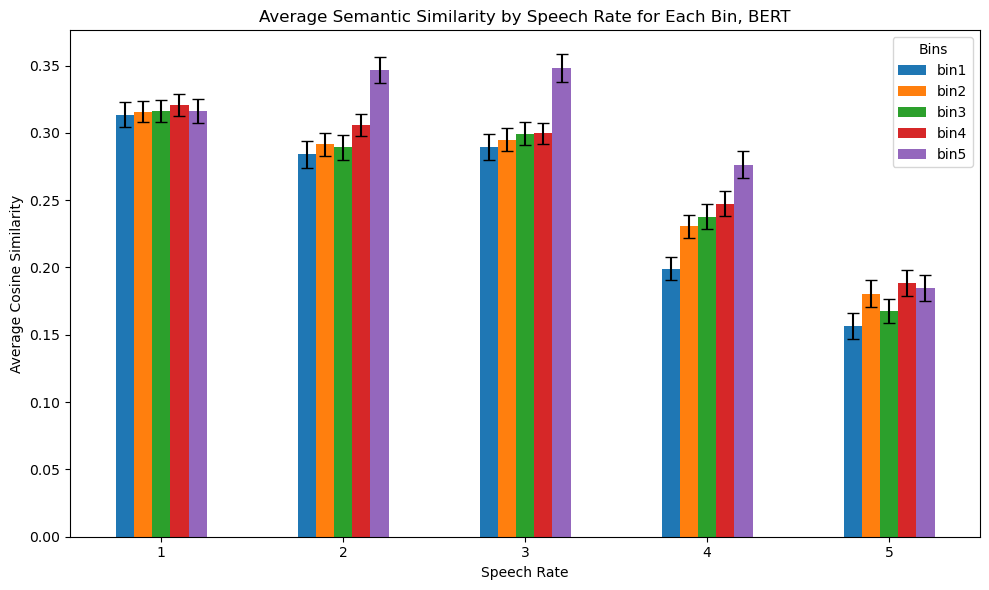

In [7]:
# Calculate the mean and standard error for each bin
grouped = df.groupby('speech_rate')[['cosine_similarity_bin1', 'cosine_similarity_bin2', 'cosine_similarity_bin3', 'cosine_similarity_bin4', 'cosine_similarity_bin5']].agg(['mean', 'sem'])

# Flatten the MultiIndex columns
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]

# Reset the index so 'speech_rate' becomes a regular column
grouped.reset_index(inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes.

# Extract means and standard errors
means = grouped[['cosine_similarity_bin1_mean', 'cosine_similarity_bin2_mean', 'cosine_similarity_bin3_mean', 'cosine_similarity_bin4_mean', 'cosine_similarity_bin5_mean']]
errors = grouped[['cosine_similarity_bin1_sem', 'cosine_similarity_bin2_sem', 'cosine_similarity_bin3_sem', 'cosine_similarity_bin4_sem', 'cosine_similarity_bin5_sem']]

# Plot data
means.plot(kind='bar', yerr=errors.to_numpy().T, ax=ax, capsize=4, legend=False)

# Setting plot labels and title
ax.set_xlabel('Speech Rate')
ax.set_ylabel('Average Cosine Similarity')
ax.set_title('Average Semantic Similarity by Speech Rate for Each Bin, BERT')
ax.set_xticklabels(grouped['speech_rate'], rotation=0)

# Modify the legend labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [label.replace('_mean', '').replace('cosine_similarity_', '') for label in labels]
ax.legend(handles, new_labels, title='Bins')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Save the DataFrame to a CSV file locally within Colab
df.to_csv('df_semantic.csv', index=False)

# Dowload
files.download('df_semantic.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
df = pd.read_csv('/Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/data/organized_data/df_semantic.csv')

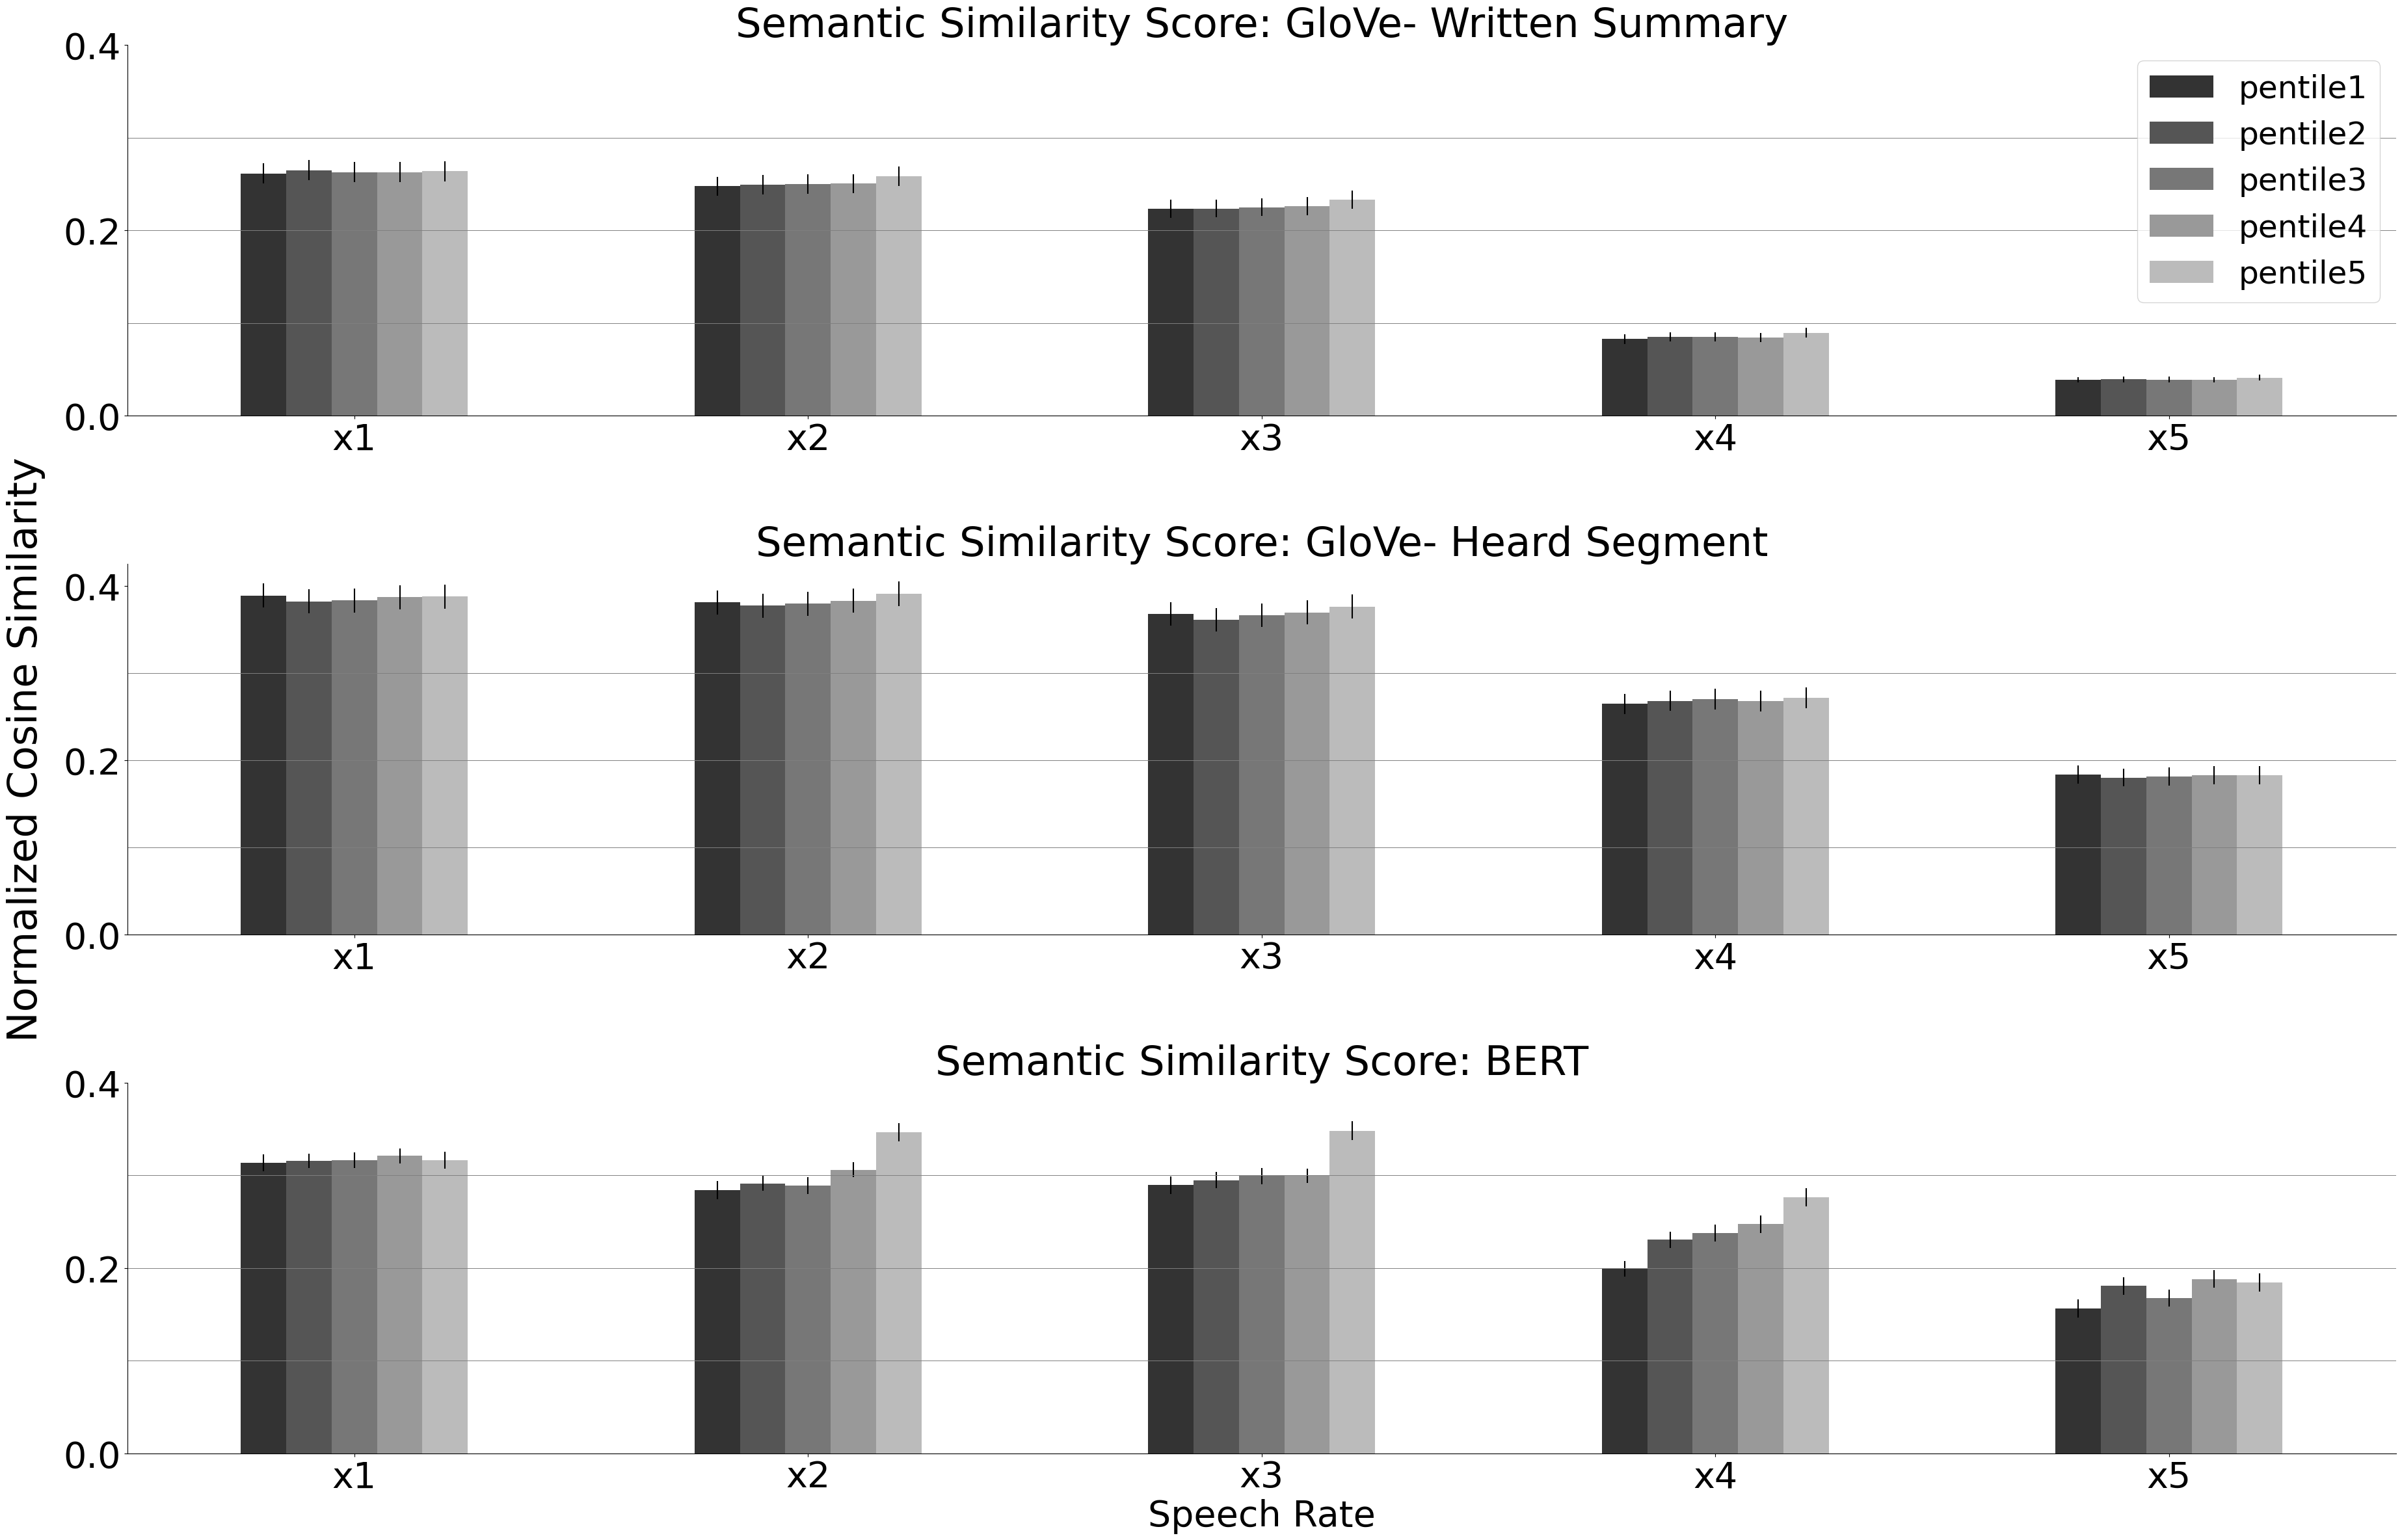

In [15]:
# Plot semantic similiarity of each pentile per speech rate for each calculation method

# Function to calculate mean and sem for grouped data
def calculate_grouped_means_and_errors(df, columns, group_by='speech_rate'):
    grouped = df.groupby(group_by)[columns].agg(['mean', 'sem'])
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
    grouped.reset_index(inplace=True)
    return grouped

# Set the figure size to 75% of the original size while maintaining the aspect ratio
fig, axes = plt.subplots(3, 1, figsize=(45, 28.125))  # 75% of 60x37.5

# Convert to grayscale color palette (no white)
grayscale_palette = ['#333333', '#555555', '#777777', '#999999', '#bbbbbb']

# Plot 1: Rescaled GloVe bins
columns = ['rescaled_glove_bin1', 'rescaled_glove_bin2', 'rescaled_glove_bin3', 'rescaled_glove_bin4', 'rescaled_glove_bin5']
grouped = calculate_grouped_means_and_errors(df, columns)
means = grouped[[f'{col}_mean' for col in columns]]
errors = grouped[[f'{col}_sem' for col in columns]]
means.plot(kind='bar', yerr=errors.to_numpy().T, ax=axes[0], capsize=0, legend=False, color=grayscale_palette)  # capsize=0 to remove error bar tails
axes[0].set_xlabel('', fontsize=40)  # no label
axes[0].set_ylabel('', fontsize=40)  # Labels font size = 40
axes[0].set_title('Semantic Similarity Score: GloVe- Written Summary', fontsize=45)  # Titles font size = 45
axes[0].set_xticklabels([f'x{label}' for label in grouped['speech_rate']], rotation=0, fontsize=40)  # Ticks font size = 40
axes[0].tick_params(axis='both', which='major', labelsize=40)  # Ticks font size = 40
axes[0].set_yticks([0, 0.2, 0.4])  # Set y-ticks to 0, 0.2, 0.4
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))  # Format y-axis to 1 decimal place

# Remove right and upper spines
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
# add faint horizontal lines for y=0.1, 0.2, 0.3, 0.4
axes[0].axhline(0.1, color='gray', linestyle='-', linewidth=0.7)
axes[0].axhline(0.2, color='gray', linestyle='-', linewidth=0.7)
axes[0].axhline(0.3, color='gray', linestyle='-', linewidth=0.7)

# Add a custom legend to the first plot (top-right corner), remove title, and use pentile labels
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [f'pentile{idx+1}' for idx, label in enumerate(columns)]  # Renaming to pentile1, pentile2, ...
axes[0].legend(handles, new_labels, loc='upper right', fontsize=35)  # Legend font size = 35, no title

# Plot 2: GloVe2 bins
columns = ['glove2_bin1', 'glove2_bin2', 'glove2_bin3', 'glove2_bin4', 'glove2_bin5']
grouped = calculate_grouped_means_and_errors(df, columns)
means = grouped[[f'{col}_mean' for col in columns]]
errors = grouped[[f'{col}_sem' for col in columns]]
means.plot(kind='bar', yerr=errors.to_numpy().T, ax=axes[1], capsize=0, legend=False, color=grayscale_palette)  # capsize=0 to remove error bar tails
axes[1].set_xlabel('', fontsize=40)  # no label
axes[1].set_ylabel('Normalized Cosine Similarity', fontsize=45, labelpad=20)  # Labels font size = 45, move label further away with labelpad
axes[1].set_title('Semantic Similarity Score: GloVe- Heard Segment', fontsize=45)  # Titles font size = 45
axes[1].set_xticklabels([f'x{label}' for label in grouped['speech_rate']], rotation=0, fontsize=40)  # Ticks font size = 40
axes[1].tick_params(axis='both', which='major', labelsize=40)  # Ticks font size = 40
axes[1].set_yticks([0, 0.2, 0.4])  # Set y-ticks to 0, 0.2, 0.4
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))  # Format y-axis to 1 decimal place

# Remove right and upper spines
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
# add faint horizontal lines for y=0.1, 0.2, 0.3, 0.4
axes[1].axhline(0.1, color='gray', linestyle='-', linewidth=0.7)
axes[1].axhline(0.2, color='gray', linestyle='-', linewidth=0.7)
axes[1].axhline(0.3, color='gray', linestyle='-', linewidth=0.7)

# Plot 3: BERT bins
columns = ['cosine_similarity_bin1', 'cosine_similarity_bin2', 'cosine_similarity_bin3', 'cosine_similarity_bin4', 'cosine_similarity_bin5']
grouped = calculate_grouped_means_and_errors(df, columns)
means = grouped[[f'{col}_mean' for col in columns]]
errors = grouped[[f'{col}_sem' for col in columns]]
means.plot(kind='bar', yerr=errors.to_numpy().T, ax=axes[2], capsize=0, legend=False, color=grayscale_palette)  # capsize=0 to remove error bar tails
axes[2].set_xlabel('Speech Rate', fontsize=40)  # Labels font size = 40
axes[2].set_ylabel('', fontsize=40)  # Labels font size = 40
axes[2].set_title('Semantic Similarity Score: BERT', fontsize=45)  # Titles font size = 45
axes[2].set_xticklabels([f'x{label}' for label in grouped['speech_rate']], rotation=0, fontsize=40)  # Ticks font size = 40
axes[2].tick_params(axis='both', which='major', labelsize=40)  # Ticks font size = 40
axes[2].set_yticks([0, 0.2, 0.4])  # Set y-ticks to 0, 0.2, 0.4
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))  # Format y-axis to 1 decimal place

# Remove right and upper spines
axes[2].spines['right'].set_visible(False)
axes[2].spines['top'].set_visible(False)
# add faint horizontal lines for y=0.1, 0.2, 0.3, 0.4
axes[2].axhline(0.1, color='gray', linestyle='-', linewidth=0.7)
axes[2].axhline(0.2, color='gray', linestyle='-', linewidth=0.7)
axes[2].axhline(0.3, color='gray', linestyle='-', linewidth=0.7)
# Adjust layout to make sure everything fits nicely
plt.subplots_adjust(hspace=0.4)  # Increase space between plots

# Display the plots
plt.show()
